> Notebook com o carregamento dos dados brutos, realização do pré-processamento e treinamento dos modelos de ML

---

# **Libraries**

Import of all libraries used in the project. 

In [ ]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle # Save models
seed = 10 # seed for the random state

In [ ]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

In [ ]:
# Classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

## **General**

In [ ]:
def read_csv(path):
  """Read csv files

  :param path str: path to the csv file.

  :return: dataframe from the csv file.
  :rtype: pd.DataFrame
  """

  df = pd.read_csv(path)
  print(df.shape)

  return df

In [ ]:
def save_csv(df, path):
  """Save csv files

  :param df pd.DataFrame: dataframe to be saved.
  :param path str: path to save the csv file.

  :return: no value
  :rtype: none
  """

  df.to_csv(path, encoding='utf-8', index=False)
  print('CSV file saved successfully!')

In [ ]:
def get_dates_diff(df):
  """Get the difference, in days, between columns with dates

  :param df pd.DataFrame: DataFrame to get the dates difference.

  :return: DataFrame with dates difference in nine new columns 
  :rtype: pd.DataFrame
  """
  
  df_aux = df.copy()
  
  df_aux.dropna(subset=['DTTRAT','DTULTINFO'], inplace=True)

  lista_datas = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA']
  
  for c in lista_datas:
    if c == 'DTTRAT': # Has a different date format 
      fmt = '%d/%m/%Y'
    else:
      fmt = '%Y-%m-%d'
    df_aux[c] = pd.to_datetime(df_aux[c], format=fmt)

  df_aux['delta_t1'] = (df_aux.DTDIAG - df_aux.DTCONSULT).dt.days
  df_aux['delta_t2'] = (df_aux.DTTRAT - df_aux.DTDIAG).dt.days
  df_aux['delta_t3'] = (df_aux.DTTRAT - df_aux.DTCONSULT).dt.days

  df_aux['delta_t4'] = (df_aux.DTRECIDIVA - df_aux.DTCONSULT).dt.days
  df_aux['delta_t5'] = (df_aux.DTRECIDIVA - df_aux.DTDIAG).dt.days
  df_aux['delta_t6'] = (df_aux.DTRECIDIVA - df_aux.DTTRAT).dt.days

  df_aux['delta_t7'] = (df_aux.DTULTINFO - df_aux.DTCONSULT).dt.days
  df_aux['delta_t8'] = (df_aux.DTULTINFO - df_aux.DTDIAG).dt.days
  df_aux['delta_t9'] = (df_aux.DTULTINFO - df_aux.DTTRAT).dt.days

  return df_aux

In [ ]:
def get_labels(df):
  """Create death labels acording to the last information year.

  :param df pd.DataFrame: dataframe to be processed.

  :return: DataFrame with the new labels
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  # Label de óbito
  df_aux['ob'] = 0

  # Label de óbito de acordo com o ano
  df_aux['ano_ob'] = 0
  
  for index, row in df_aux.iterrows():
    if row.ULTINFO > 2:
      df_aux.loc[index, 'ob'] = 1
      if row.delta_t8 < 365:
        df_aux.loc[index, 'ano_ob'] = 1
      elif row.delta_t8 < 2*365:
        df_aux.loc[index, 'ano_ob'] = 2
      elif row.delta_t8 < 3*365:
        df_aux.loc[index, 'ano_ob'] = 3
      elif row.delta_t8 < 4*365:
        df_aux.loc[index, 'ano_ob'] = 4
      elif row.delta_t8 < 5*365:
        df_aux.loc[index, 'ano_ob'] = 5
      else:
        df_aux.loc[index, 'ano_ob'] = 6

  return df_aux

In [ ]:
def get_label_rec(df):
  """Create the labels analyzing whether there was recurrence.
  
  :param df pd.DataFrame: dataframe to be processed.

  :return: DataFrame with the new labels
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  df_aux['ob_com_rec'] = 0
  df_aux['ob_sem_rec'] = 0
  df_aux['vivo_com_rec'] = 0
  df_aux['vivo_sem_rec'] = 0

  for i, row in df.iterrows():
    if row['ob'] == 1:
      if row.RECNENHUM == 1:
        df_aux.loc[i, 'ob_sem_rec'] = 1
      else:
        df_aux.loc[i, 'ob_com_rec'] = 1
        
    else:
      if row.RECNENHUM == 1:
        df_aux.loc[i, 'vivo_sem_rec'] = 1
      else:
        df_aux.loc[i, 'vivo_com_rec'] = 1

  return df_aux

## **Models**

In [ ]:
def variables_preprocessing(df):
  """Do some preprocessing on the DataFrame like strings splits, fill NaN values,
     replace values and drop some columns.

  :param df pd.DataFrame: DataFrame to be preprocessed.

  :return: DataFrame after be preprocessed and get some columns removed
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()
  no_info = '**Sem informação**'

  # DRS
  DRS_expand = df_aux.DRS.str.split(' ', expand=True)
  df_aux['DRS'] = DRS_expand[1]
  df_aux.DRS = df_aux.DRS.fillna(0).astype('int64')

  # META
  df_aux.META01.fillna(no_info, inplace=True)
  df_aux.META02.fillna(no_info, inplace=True)
  df_aux.META03.fillna(no_info, inplace=True)
  df_aux.META04.fillna(no_info, inplace=True)

  # REC
  df_aux.REC01.fillna(no_info, inplace=True)
  df_aux.REC02.fillna(no_info, inplace=True)
  df_aux.REC03.fillna(no_info, inplace=True)
  df_aux.REC04.fillna(no_info, inplace=True)

  # PT
  df_aux.PT = df_aux.PT.replace([1.0],'1')
  df_aux.PT = df_aux.PT.str.upper()
  df_aux.PT.fillna(no_info, inplace=True)

  # PN
  df_aux.PN = df_aux.PN.replace([0.0],'0')
  df_aux.PN = df_aux.PN.str.upper()
  df_aux.PN = df_aux.PN.replace(['1BI','IBII','O'],['1B1','1B2','0'])
  df_aux.PN.fillna(no_info, inplace=True)

  # PM
  df_aux.PM = df_aux.PM.replace([0.0],'0')
  df_aux.PM.fillna(no_info, inplace=True)

  # CICI
  df_aux.CICI.fillna(no_info, inplace=True)

  # CICIGRUP
  CICIGRUP_expand = df_aux.CICIGRUP.str.split('  ', expand=True)
  df_aux['CICIGRUP'] = CICIGRUP_expand[0]
  df_aux.CICIGRUP.fillna(no_info, inplace=True)

  # Colunas com valores únicos 
  col = df_aux.columns
  drop_cols = ['S','QUIMIOANT','HORMOANT','TMOANT','IMUNOANT','OUTROANT','ERRO',
               'CIDO', 'UFNASC','CIDADE','DESCTOPO','DESCMORFO','DSCCIDO','CICISUBGRU',
               'INSTORIG', 'OUTRACLA']

  col = col.drop(drop_cols)

  return df_aux[col]

In [ ]:
def get_train_test(df, drop_cols, label, test_size=0.25, random_state=10):
  """Get features and label, and then returns train and test dataframes.

  :param df pd.DataFrame: dataframe that will be splitted.
  :param drop_cols list: columns to be removed from the DataFrame.
  :param label str: name of the label column.
  :param test_size float: size of test (default=0.25).
  :param random_state int: value for train_test_split random_state (default=10).

  :return: train and test DataFrames, X_train, X_test, y_train, y_test
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  cols = df_aux.columns.drop(drop_cols)
  lb = df_aux[label].copy()
  cols = cols.drop(label)
  feat = df_aux[cols]

  X_train, X_test, y_train, y_test = train_test_split(feat, lb, test_size=test_size, random_state=random_state)
  print(f'X_train = {X_train.shape}, X_test = {X_test.shape}')
  print(f'y_train = {y_train.shape}, y_test = {y_test.shape}')

  return X_train, X_test, y_train, y_test

In [ ]:
def train_preprocessing(df, normalizer='StandardScaler', pca=False, pca_components=None, random_state=10):
  """Preprocessing the train dataset.

  :param df pd.DataFrame: DataFrame to be preprocessed.
  :param normalizer str: which normalizer to be fitted to the data (default='StandardScaler').
    options:
      * 'MinMaxScaler'
      * 'MaxAbsScaler'
      * 'PowerTransformer'
      * 'QuantileTransformer'
  :param pca bool: if want to use PCA components set True (default=False).
  :param pca_components int: number of PCA components (default=None).
  :param random_state int: value for pca random_state (default=10).

  :return df: preprocessed train DataFrame 
  :rtype: pd.DataFrame
  :return enc: trained LabelEncoder 
  :rtype: dict
  :return norm: trained normalizer 
  :rtype: object
  :return pca if param pca=True: trained PCA 
  :rtype: object
  """

  df_aux = df.copy()

  list_categorical = df_aux.select_dtypes(include='object').columns

  enc = dict()
  for col in list_categorical:
    enc[col] = LabelEncoder()
    df_aux[col] = enc[col].fit_transform(df_aux[col])

  if normalizer == 'StandardScaler':
    norm = StandardScaler()
  elif normalizer == 'MinMaxScaler':
    norm = MinMaxScaler()
  elif normalizer == 'MaxAbsScaler':
    norm = MaxAbsScaler()
  elif normalizer == 'PowerTransformer':
    norm = PowerTransformer()
  elif normalizer == 'QuantileTransformer':
    norm = QuantileTransformer(output_distribution='normal')
  
  df_aux = norm.fit_transform(df_aux)

  if pca:
    pca = PCA(pca_components, random_state=random_state)
    df_aux = pca.fit_transform(df_aux)

    return df_aux, enc, norm, pca

  else:
    return df_aux, enc, norm

In [ ]:
def test_preprocessing(df, enc, norm, pca=None):
  """Preprocessing the test dataset.

  :param df pd.DataFrame: DataFrame to be preprocessed.
  :param enc: trained encoder with the categorical features.
  :param norm: trained normalizer.
  :param pca: trained PCA (default=None).

  :return: preprocessed test DataFrame 
  :rtype: pd.DataFrame
  """

  df_aux = df.copy()

  df_aux.fillna(0, inplace=True)

  list_categorical = df_aux.select_dtypes(include='object').columns

  for col in list_categorical:
    df_aux.loc[~df_aux[col].isin(enc[col].classes_), col] = -1 
    df_aux.loc[df_aux[col].isin(enc[col].classes_), col] = enc[col].transform(df_aux[col][df_aux[col].isin(enc[col].classes_)])

  df_aux = norm.transform(df_aux)

  if pca != None:
    df_aux = pca.transform(df_aux)

  return df_aux 

In [ ]:
def plot_feat_importances(model, X_test, n=25):
  """Shows the features importances for the model.

  :param model: machine learning model.
  :param X_test pd.DataFrame: X_test for the model, before preprocessing.
  :param n int: number of features to be shown (default=25).

  :return: no value
  :rtype: none
  """

  feat_import = pd.Series(model.feature_importances_, index=X_test.columns)
  feat_import.nlargest(n).plot(kind='barh', figsize=(10,10))
  plt.show()

In [ ]:
def validate_regression(X_test, model, y_test):
  """Validate the regression.

  :param X_test pd.DataFrame: values to be validated 
  :param model: trained machine learning model
  :param y_test array-like: true labels for the regression

  :return: DataFrame comparing the real and predicted values
  :rtype: pd.DataFrame
  """

  y_pred = model.predict(X_test)
  df = pd.DataFrame({'Real': y_test, 'Predict': y_pred})

  print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}')
  print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
  print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
  print(f'Score: {model.score(X_test, y_test):.3f}')

  return df

# **Data dictionary**

*   **ESCOLARI**: Código para escolaridade do paciente (int = 1).

      1 – ANALFABETO

      2 – ENS. FUND. INCOMPLETO

      3 – ENS. FUND. COMPLETO

      4 – ENSINO MÉDIO

      5 – SUPERIOR

      9 – IGNORADA
*   **IDADE**: Idade do paciente (int = 3).
*   **SEXO**: Sexo do paciente (int = 1). 

      1 – MASCULINO

      2 – FEMININO
*   **UFNASC**: UF de nascimento (char = 2). Outras opções: SI - Sem informação; OP - Outro país.	
*   **UFRESID**: UF de residência (char = 2). Outras opções: OP - Outro país.
*   **IBGE**: Código da cidade de residência do paciente segundo IBGE com digito verificador (char = 7).
*   **CIDADE**: Cidade de residência do paciente (char = 200).
*   **CATEATEND**: Categoria de atendimento ao diagnóstico (int = 1). 

      1 - CONVENIO

      2 - SUS

      3 – PARTICULAR

      9 – SEM INFORMAÇÃO
*   **DTCONSULT**: Data da 1ª consulta (date = 10). Formato: DD/MM/YYYY	
*   **CLINICA**: Código da clinica (int = 2).

      1 – ALERGIA/IMUNOLOGIA

      2 – CIRURGIA CARDIACA

      3 – CIRURGIA CABEÇA E PESCOÇO

      4 – CIRURGIA GERAL

      5 – CIRURGIA PEDIATRICA

      6 – CIRURGIA PLASTICA

      7 – CIRURGIA TORAXICA

      8 – CIRURGIA VASCULAR

      9 – CLINICA MEDICA

      10 – DERMATOLOGIA

      11 – ENDOCRINOLOGIA

      12 – GASTROCIRURGIA
      
      13 – GASTROENTEROLOGIA
      
      14 – GERIATRIA
      
      15 – GINECOLOGIA
      
      16 – GINECOLOGIA / OBSTETRICIA
      
      17 – HEMATOLOGIA
      
      18 – INFECTOLOGIA
      
      19 – NEFROLOGIA
      
      20 – NEUROCIRURGIA
      
      21 – NEUROLOGIA
      
      22 – OFTALMOLOGIA
      
      23 – ONCOLOGIA CIRURGICA
      
      24 – ONCOLOGIA CLINICA
      
      25 – ONCOLOGIA PEDIATRICA
      
      26 – ORTOPEDIA
      
      27 – OTORRINOLARINGOLOGIA
      
      28 – PEDIATRIA
      
      29 – PNEUMOLOGIA
      
      30 – PROCTOLOGIA
      
      31 – RADIOTERAPIA
      
      32 – UROLOGIA
      
      33 – MASTOLOGIA
      
      34 – ONCOLOGIA CUTANEA
      
      35 – CIRURGIA PELVICA
      
      36 – CIRURGIA ABDOMINAL
      
      37 – ODONTOLOGIA
      
      38 – TRANSPLANTE HEPATICO
      
      99 – IGNORADO	
*   **DIAGPREV**: Diagnóstico e tratamento anterior (int = 1).

      1 – SEM DIAGNÓSTICO / SEM TRATAMENTO
      
      2 – COM DIAGNÓSTICO / SEM TRATAMENTO
      
      3 – COM DIAGNÓSTICO / COM TRATAMENTO
      
      4 – OUTROS	
*   **DTDIAG**: Data do diagnóstico (date = 10). Formato: DD/MM/YYYY	
*   **BASEDIAG**: Código da base do diagnóstico (int = 1).
      
      1 – EXAME CLINICO
      
      2 – RECURSOS AUXILIARES NÃO MICROSCÓPICOS
      
      3 – CONFIRMAÇÃO MICROSCÓPICA
      
      4 – SEM INFORMAÇÃO	
*   **TOPO**: Código da topografia (char = 4). Formato: C999 	
*   **TOPOGRUP**: Grupo da topografia	(char = 3). Formato: C99	
*   **DESCTOPO**: Descrição da Topografia (char = 80).
*   **MORFO**: Código da morfologia (char = 5). Formato: 99999
*   **DESCMORFO**: Descrição da morfologia (char = 80).
*   **EC**: Estádio clínico (char = 5).
*   **ECGRUP**: Grupo do estadiamento clínico (char = 3).

      0 - Tumores primários, classificados como in situ

      I - Tumores localizados

      II - Tumores com envolvimento regional por extensão direta

      III - Tumores com envolvimento regional de linfonodos
      
      IV - Tumores com metástase à distância 

      X - Para tumores não avaliados pelo profissional responsável ou sem informação sobre estadiamento anotada no prontuário

      Y - Para tumores em que não se aplica a classificação TNM. São os tumores não sólidos (por exemplo, as leucemias)
*   **T**: Classificação TNM - T (char = 5).
*   **N**: Classificação TNM - N (char = 5).	
*   **M**: Classificação TNM - M (char = 3).	
*   **PT**: Estadiamento pós cirúrgico (char = 5).
*   **PN**: Estadiamento pós cirúrgico (char = 5).	
*   **PM**: Estadiamento pós cirúrgico (char = 3).	
*   **S**: Classificação TNM - S (int = 1). Domínio: 0; 1; 2; 3; 8 – NÃO SE APLICA; 9 – X
*   **G**: Classificação TNM – G (Grau) (char = 5). 

      Domínio (exceto C40, C41, C381, C382, C383, C47, C48 e C49):
      0; 1; 2; 3; 4; 8 – NÃO SE APLICA; 9 – X

      Domínio (somente C40, C41, C381, C382, C383, C47, C48 e C49):
      ALTO; BAIXO; 8 – NÃO SE APLICA; 9 – X
	
*   **LOCALTNM**: Classificação TNM - Localização (int = 1).
      
      1 – SUPERIOR
      
      2 – MEDIO
      
      3 – INFERIOR
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **IDMITOTIC**: Classificação TNM – Índice Mitótico (int = 1).
      
      1 – ALTA
      
      2 – BAIXA
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **PSA**: Classificação TNM - PSA (int = 1).
      
      1 – MENOR QUE 10
      
      2 – MAIOR OU IGUAL A 10 E MENOR QUE 20
      
      3 – MAIOR OU IGUAL A 20
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **GLEASON**: Classificação TNM - Gleason (int = 1).
      
      1 – MENOR OU IGUAL A 6
      
      2 – IGUAL A 7
      
      3 – MAIOR OU IGUAL A 8
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **OUTRACLA**: Outra classificação de estadiamento (char = 20).
*   **META01**: Metástase (char = 3).	Formato: C99
*   **META02**: Metástase (char = 3).	Formato: C99
*   **META03**: Metástase (char = 3).	Formato: C99
*   **META04**: Metástase (char = 3).	Formato: C99
*   **DTTRAT**: Data de inicio do tratamento (date = 10). Formato: DD/MM/YYYY	
*   **NAOTRAT**: Código da razão para não realização do tratamento (int = 1).
      
      1 – RECUSA DO TRATAMENTO
      
      2 – DOENÇA AVANÇADA, FALTA DE CONDIÇÕES CLINICAS
      
      3 – OUTRAS DOENÇAS ASSOCIADAS
      
      4 – ABANDONO DE TRATAMENTO
      
      5 – OBITO POR CANCER
      
      6 – OBITO POR OUTRAS CAUSAS, SOE
      
      7 – OUTRAS
      
      8 – NÃO SE APLICA (CASO TENHA TRATAMENTO)
      
      9 – SEM INFORMAÇÃO	
*   **TRATAMENTO**: Código de combinação dos tratamentos realizados (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado	
*   **TRATHOSP**: Código de combinação dos tratamentos realizados no hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento

      J – Nenhum tratamento realizado	
*   **TRATFANTES**: Código de combinação dos tratamentos realizados antes/durante admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação
*   **TRATFAPOS**: Código de combinação dos tratamentos realizados após admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação
*   **NENHUM**: Tratamento recebido no hospital = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURGIA**: Tratamento recebido no hospital = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIO**: Tratamento recebido no hospital = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIO**: Tratamento recebido no hospital = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMONIO**: Tratamento recebido no hospital = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMO**: Tratamento recebido no hospital = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNO**: Tratamento recebido no hospital = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROS**: Tratamento recebido no hospital = outros (int = 1). 0 – NÃO; 1 – SIM
*   **NENHUMANT**: Tratamento recebido fora do hospital e antes da admissão = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURANT**: Tratamento recebido fora do hospital e antes da admissão = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIOANT**: Tratamento recebido fora do hospital e antes da admissão = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIOANT**: Tratamento recebido fora do hospital e antes da admissão = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMOANT**: Tratamento recebido fora do hospital e antes da admissão = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMOANT**: Tratamento recebido fora do hospital e antes da admissão = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNOANT**: Tratamento recebido fora do hospital e antes da admissão = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROANT**: Tratamento recebido fora do hospital e antes da admissão = outros (int = 1). 0 – NÃO; 1 – SIM	
*   **NENHUMAPOS**: Tratamento recebido fora do hospital e durante/após admissão = nenhum	(int = 1). 0 – NÃO; 1 – SIM	
*   **CIRURAPOS**: Tratamento recebido fora do hospital e durante/após admissão = cirurgia	(int = 1). 0 – NÃO; 1 – SIM	
*   **RADIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = radioterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **QUIMIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = quimioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **HORMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = hormonioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **TMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = tmo	(int = 1). 0 – NÃO; 1 – SIM		
*   **IMUNOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = imunoterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **OUTROAPOS**: Tratamento recebido fora do hospital e durante/após admissão = outros	(int = 1). 0 – NÃO; 1 – SIM	
*   **DTULTINFO**: Data da última informação do paciente (date = 10). Formato: DD/MM/YYYY
*   **ULTINFO**: Última informação sobre o paciente (int = 1).
      
      1 – VIVO, COM CÂNCER
      
      2 – VIVO, SOE
      
      3 – OBITO POR CANCER
      
      4 – OBITO POR OUTRAS CAUSAS, SOE
*   **CONSDIAG**: Diferença em dias entre as datas de consulta o diagnóstico (num = dias).
*   **TRATCONS**: Diferença em dias entre as datas de consulta e tratamento (num = dias).	
*   **DIAGTRAT**: Diferença em dias entre as datas de tratamento e diagnóstico (num = dias).
*   **ANODIAG**: Ano de diagnóstico (int = 4). Formato: 9999
*   **CICI**: Tumor infantil (char = 5).	
*   **CICIGRUP**: Tumor infantil – Grupo (char = 80).	
*   **CICISUBGRU**: Tumor infantil – Sub grupo (char = 80).	
*   **FAIXAETAR**: Faixa etária do paciente (char = 5).	
*   **LATERALI**: Lateralidade (int = 1).
      
      1 – DIREITA
      
      2 – ESQUERDA
      
      3 – BILATERAL
      
      8 - NÃO SE APLICA	
*   **INSTORIG**: Instituição de origem (char = 200). Obrigatório somente se DIAGPREV = 03 – COM DIAGNÓSTICO / COM TRATAMENTO
*   **DRS**: Departamentos Regionais de Saúde (char = 200).
*   **RRAS**: RRAS (char = 200).	
*   **PERDASEG**: Perda de seguimento (int = 1). 
      
      0 – Não
      
      1 – Sim
      
      8 – Não se aplica (excluído do cálculo para o indicador perda de seguimento)	
*   **ERRO**: Admissão com erro (int = 1). 0 – Sem; 1 – Com
*   **DTRECIDIVA**: Data da última ocorrência de recidiva (date = 10). Formato: DD/MM/YYYY	
*   **RECNENHUM**: Sem recidiva (int = 1). 0 - Não; 1 - Sim
*   **RECLOCAL**: Recidiva local (int = 1). 0 - Não; 1 - Sim	
*   **RECREGIO**: Recidiva regional (int = 1). 0 - Não; 1 - Sim	
*   **RECDIST**: Recidiva a distância / metástase (int = 1). 0 - Não; 1 - Sim	
*   **REC01**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC02**: Local da recidiva/metástase (char = 3). Formato: C99 	
*   **REC03**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC04**: Local da recidiva/metástase (char = 3). Formato: C99 	
*   **IBGEATEN**: Código IBGE da instituição (int = 7).	
*   **CIDO**: Código da morfologia 3ª Edição (int = 5). Formato: 99999	
*   **DSCCIDO**: Descrição da morfologia 3ª Edição (char = 89).




# **Reading the data**

Reading the raw data, these data have already been transformed into a csv file, because when downloading the data from the [FOSP website](http://www.fosp.saude.sp.gov.br/publicacoes/downloadarquivos) we have a dbf file. Below we have the code for this conversion, it takes some time to make the transformation because the dataset has almost 950 thousand lines.

```
pip install simpledbf
from simpledbf import Dbf5

dbf = Dbf5('your_file.dbf', codec='cp1250')
df = dbf.to_dataframe()
df.to_csv('new_csv_file.csv', encoding='utf-8', index=False)
```

In [ ]:
data = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/pacigeral.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (23,24,25,32,36,78,91) have mixed types.Specify dtype option on import or set low_memory=False.



(943660, 95)


# **Data analysis**

In this section we will analyze some data information with graphs, missing values and each column of the dataset individually.

## **Information**

To start we have the most basic information of the data, such as the size of the dataset, the first lines, type of each column and the describe function that brings some statistical information for each column.

In [ ]:
data.shape

(943660, 95)

In [ ]:
data.head()

,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,DESCTOPO,MORFO,DESCMORFO,EC,ECGRUP,T,N,M,PT,PN,PM,S,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,OUTRACLA,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,...,HORMOANT,TMOANT,IMUNOANT,OUTROANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,CICISUBGRU,FAIXAETAR,LATERALI,INSTORIG,DRS,RRAS,PERDASEG,ERRO,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,CIDO,DSCCIDO
0,4,40.0,2,SP,SP,3530805,MOGIMIRIM,9,2000-01-03,15,1,2000-01-10,3,C539,C53,COLO DO UTERO,81402,ADENOCARCINOMA IN SITU SOE,0,0,X,X,0,IS,0,0,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,07/04/2000,8,A,...,0,0,0,0,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,NaN,NaN,NaN,40-49,8,NaN,DRS 14 SĂO JOĂO DA BOA VISTA,15,1,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,81402.0,ADENOCARCINOMA IN SITU SOE
1,9,45.0,2,RJ,SP,3509502,CAMPINAS,9,2000-01-05,15,1,2000-01-17,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,20/01/2000,8,F,...,0,0,0,0,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,NaN,NaN,NaN,40-49,8,NaN,DRS 07 CAMPINAS,15,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE
2,2,63.0,2,MG,SP,3509502,CAMPINAS,9,2000-01-19,15,1,2000-01-25,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,03/02/2000,8,B,...,0,0,0,0,1,0,0,0,0,0,0,0,2001-03-20,3,6,15.0,9.0,2000,NaN,NaN,NaN,60-69,8,NaN,DRS 07 CAMPINAS,15,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE
3,9,64.0,2,SP,SP,3545803,SANTA BARBARA D OESTE,9,2000-01-28,15,1,2000-02-03,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,01/03/2000,8,B,...,0,0,0,0,1,0,0,0,0,0,0,0,2002-07-15,3,6,33.0,27.0,2000,NaN,NaN,NaN,60-69,8,NaN,DRS 07 CAMPINAS,15,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE
4,1,48.0,2,SP,SP,3530805,MOGIMIRIM,9,2000-01-04,15,2,2000-01-04,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,15/05/2000,8,B,...,0,0,0,0,1,0,0,0,0,0,0,0,2016-03-10,2,0,132.0,132.0,2000,NaN,NaN,NaN,40-49,8,NaN,DRS 14 SĂO JOĂO DA BOA VISTA,15,1,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943660 entries, 0 to 943659
Data columns (total 95 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ESCOLARI    943660 non-null  int64  
 1   IDADE       943659 non-null  float64
 2   SEXO        943660 non-null  int64  
 3   UFNASC      943660 non-null  object 
 4   UFRESID     943660 non-null  object 
 5   IBGE        943660 non-null  int64  
 6   CIDADE      943660 non-null  object 
 7   CATEATEND   943660 non-null  int64  
 8   DTCONSULT   943660 non-null  object 
 9   CLINICA     943660 non-null  int64  
 10  DIAGPREV    943660 non-null  int64  
 11  DTDIAG      943660 non-null  object 
 12  BASEDIAG    943660 non-null  int64  
 13  TOPO        943660 non-null  object 
 14  TOPOGRUP    943660 non-null  object 
 15  DESCTOPO    943660 non-null  object 
 16  MORFO       943660 non-null  int64  
 17  DESCMORFO   943657 non-null  object 
 18  EC          943660 non-null  object 
 19  EC

In [ ]:
data.describe()

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,CLINICA,DIAGPREV,BASEDIAG,MORFO,S,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,NAOTRAT,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,CIRURANT,RADIOANT,QUIMIOANT,HORMOANT,TMOANT,IMUNOANT,OUTROANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,LATERALI,RRAS,PERDASEG,ERRO,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,IBGEATEN,CIDO
count,943660.00000,943659.000000,943660.000000,9.436600e+05,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.0,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.0,943660.0,943660.0,943660.0,943660.0,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.000000,868764.000000,868764.000000,943660.000000,943660.000000,943660.000000,943660.000000,943660.0,943660.000000,943660.000000,943660.000000,943660.000000,9.436600e+05,943631.000000
mean,4.37267,59.832544,1.500366,3.545901e+06,4.925719,21.468955,1.371384,2.987796,83645.271036,8.0,7.851896,7.980918,7.997274,7.803760,7.806778,7.796074,0.083336,0.624015,0.260059,0.350319,0.122043,0.003889,0.006654,0.063399,0.999332,0.000001,0.000001,0.0,0.0,0.0,0.0,0.0,0.942144,0.004360,0.029190,0.008128,0.002320,0.000252,0.000152,0.006662,2.436262,52.378192,68.910686,65.945955,2010.314762,6.889584,16.035628,0.173644,0.0,0.917301,0.040326,0.024385,0.022254,3.533473e+06,83645.472312
std,2.94082,16.869766,0.500000,3.686201e+05,3.541344,12.621792,0.483175,0.245657,4587.585415,0.0,0.952922,0.354786,0.134579,1.124976,1.086837,0.895393,0.276390,0.484376,0.438667,0.477070,0.327336,0.062241,0.081300,0.243679,0.025830,0.001029,0.001029,0.0,0.0,0.0,0.0,0.0,0.233470,0.065883,0.168338,0.089788,0.048107,0.015879,0.012309,0.081351,0.860431,166.758604,151.221891,149.361384,5.264743,2.453975,23.992836,0.378803,0.0,0.275427,0.196723,0.154241,0.147508,1.905791e+04,4588.360210
min,1.00000,0.000000,1.000000,1.100015e+06,1.000000,1.000000,1.000000,1.000000,80001.000000,8.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.502804e+06,80001.000000
25%,2.00000,51.000000,1.000000,3.517505e+06,2.000000,12.000000,1.000000,3.000000,80762.000000,8.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,11.000000,0.000000,2006.000000,8.000000,6.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,3.509502e+06,80762.000000
50%,3.00000,62.000000,2.000000,3.540606e+06,2.000000,24.000000,1.000000,3.000000,81403.000000,8.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,22.000000,39.000000,32.000000,2011.000000,8.000000,10.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,3.543402e+06,81403.000000
75%,9.00000,72.000000,2.000000,3.550308e+06,9.000000,29.000000,2.000000,3.000000,85003.000000,8.0,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,53.000000,81.000000,84.000000,2015.000000

The first graph shows the number of patients per year of diagnosis, a low number of patients is perceived in recent years, probably due to the fact that these cases are still being followed up.

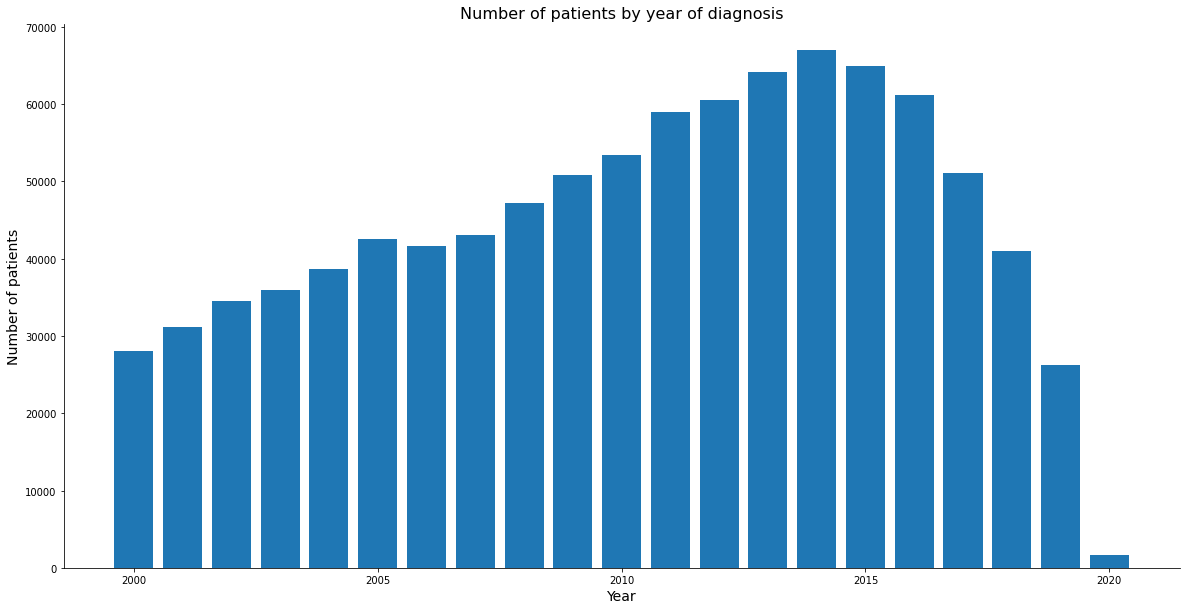

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(height = data.ANODIAG.value_counts().sort_index(), x=np.sort(data.ANODIAG.unique()))
plt.xlabel('Year', size=14)
plt.ylabel('Number of patients', size=14)
plt.title('Number of patients by year of diagnosis', size=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
fig = px.bar(x = np.sort(data.ANODIAG.unique()), y = data.ANODIAG.value_counts().sort_index(), labels={'x':'Ano', 'y':'Quantidade de casos'},
             title = 'Número de casos por ano')
fig.show()

In the following graph we have the number of patients by sex, it's possible to notice that in each year the values are close for men and women.

In [ ]:
masc = data[data.SEXO == 1]
fem = data[data.SEXO == 2]

mascx = np.sort(masc.ANODIAG.unique())
mascy = masc.ANODIAG.value_counts().sort_index()

femx = np.sort(fem.ANODIAG.unique())
femy = fem.ANODIAG.value_counts().sort_index()

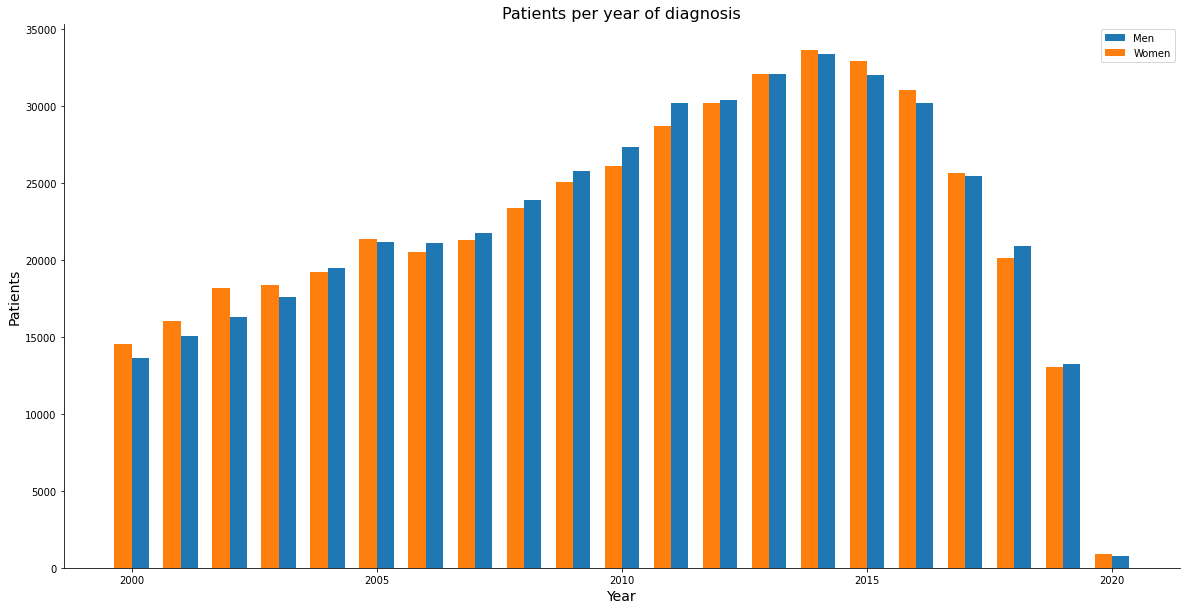

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
width = 0.35
ax1 = ax.bar(mascx + width/2, mascy, width, label='Men')
ax2 = ax.bar(femx - width/2, femy, width, label='Women')
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Patients', size=14)
ax.set_title('Patients per year of diagnosis', size=16)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(x = mascx,
                     y = mascy,
                     name = 'Masculino',
              ))

fig.add_trace(go.Bar(x = femx,
                     y = femy,
                     name = 'Feminino',
              ))

fig.update_layout(barmode = 'group', title_text='Pacientes por ano',
                  yaxis_title = 'Indivíduos', xaxis_title = 'Ano')

fig.show()

Analyzing the percentage of patients by age, we can see that women present the disease earlier, we have 23% of women from 30 to 49 years old against 11% of men in the same age group, but after 60 years old the number of men is higher in relation to women. It is also noticed that there is a higher incidence of cancer after 40 years old, with more than 85% of cases in both genders being in this age group.

In [ ]:
# Using replace to change the string format for the age group column
masc.FAIXAETAR = masc.FAIXAETAR.replace(['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69'],
                                        ['00 to 09', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59', '60 to 69'])
fem.FAIXAETAR = fem.FAIXAETAR.replace(['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69'],
                                      ['00 to 09', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59', '60 to 69'])

In [ ]:
mascx = np.sort(masc.FAIXAETAR.unique())
mascy = masc.FAIXAETAR.value_counts().sort_index()

femx = np.sort(fem.FAIXAETAR.unique())
femy = fem.FAIXAETAR.value_counts().sort_index()

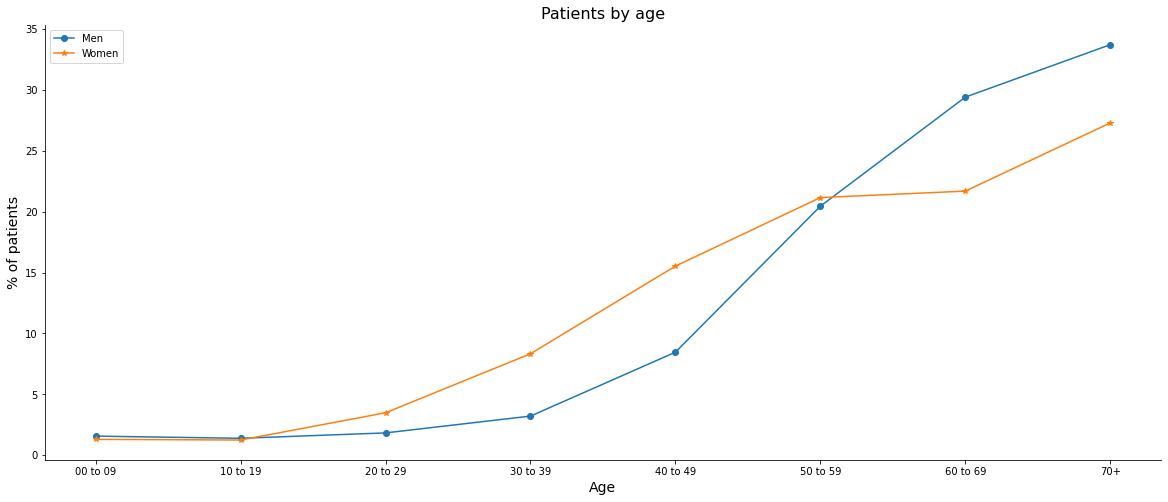

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax1 = ax.plot(mascx, (mascy/masc.shape[0])*100, label='Men', marker='o')
ax2 = ax.plot(femx, (femy/fem.shape[0])*100, label='Women', marker='*')
ax.set_xlabel('Age', size=14)
ax.set_ylabel('% of patients', size=14)
ax.set_title('Patients by age', size=16)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
mascx = np.sort(masc.FAIXAETAR.unique())
mascy = masc.FAIXAETAR.value_counts().sort_index()

femx = np.sort(fem.FAIXAETAR.unique())
femy = fem.FAIXAETAR.value_counts().sort_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x = mascx,
                         y = (mascy/masc.shape[0])*100,
                         name = 'Masculino',
                         mode = 'lines+markers',
              ))

fig.add_trace(go.Scatter(x = femx,
                         y = (femy/fem.shape[0])*100,
                         name = 'Feminino',
                         mode = 'lines+markers',
              ))

fig.update_layout(title_text='Pacientes por faixa etária',
                  yaxis_title = '% Pacientes total por sexo', xaxis_title = 'Faixa etária')

fig.show()

Looking at the clinical stage by sex, lower values for staging represent less aggressive diseases, we see women with more cases for stages 0 and 1 and men with higher numbers in stage 2 and much higher in stage 4.

The clinical stage assists the doctors in the therapeutic planning and in the evaluation of the proposed treatment, in addition to serving for the prediction of the prognosis.

In the analysis of the data according to staging, cases reported as X (cases which it is not possible to perform staging or without information) and Y (type of cancer which the classification of malignant TNM tumors are not applied) were excluded.

In [ ]:
EC = list(np.sort(data.ECGRUP.unique()))[:5] # Categories 0, I, II, III, IV, without X and Y

mascEC = masc.loc[masc.ECGRUP.isin(EC)]
femEC = fem.loc[fem.ECGRUP.isin(EC)]

mascx = np.sort(mascEC.ECGRUP.unique())
mascy = mascEC.ECGRUP.value_counts().sort_index()

femx = np.sort(femEC.ECGRUP.unique())
femy = femEC.ECGRUP.value_counts().sort_index()

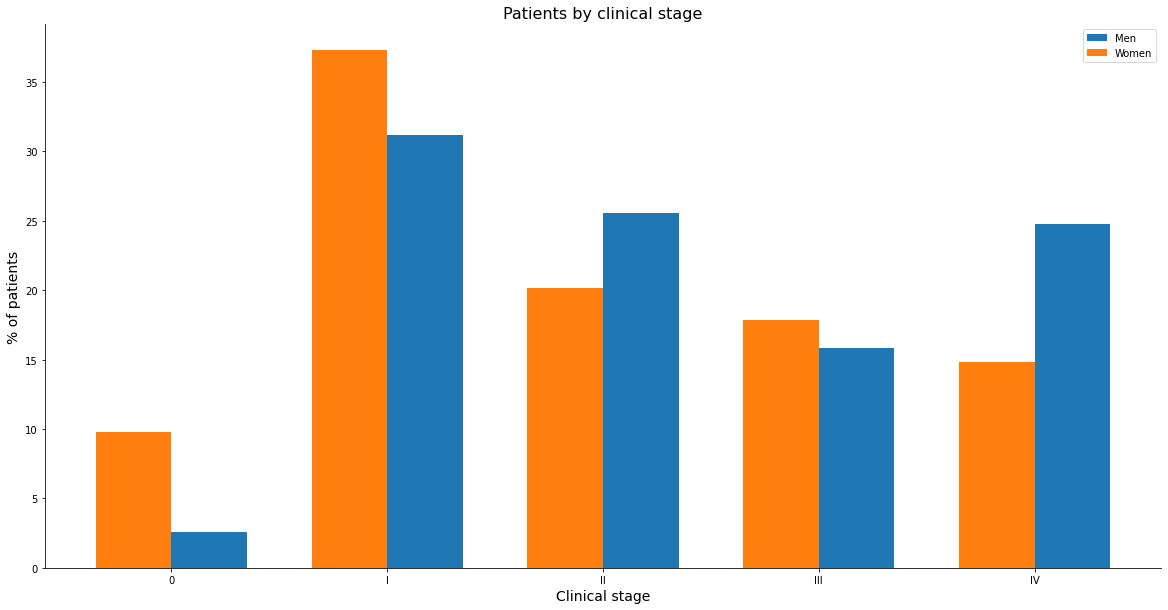

In [ ]:
x = np.arange(len(mascx))
fig, ax = plt.subplots(figsize=(20,10))
width = 0.35
ax1 = ax.bar(x + width/2, (mascy/mascEC.shape[0])*100, width, label='Men')
ax2 = ax.bar(x - width/2, (femy/femEC.shape[0])*100, width, label='Women')
ax.set_xlabel('Clinical stage', size=14)
ax.set_ylabel('% of patients', size=14)
ax.set_title('Patients by clinical stage', size=16)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(list(mascx))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
# O estádio clínico auxilia o médico no planejamento terapêutico e na avaliação 
# do tratamento proposto, além de servir para a predição do prognóstico.
## Na análise dos dados segundo estadiamento foram excluídos os casos informados 
## como X (casos nos quais não é possível realizar o estadiamento ou sem informação)
## e Y (tipo de câncer em que não se aplica a classificação de tumores malignos TNM).

EC = list(np.sort(data.ECGRUP.unique()))[:5] # Categories 0, I, II, III, IV

mascEC = masc.loc[masc.ECGRUP.isin(EC)]
femEC = fem.loc[fem.ECGRUP.isin(EC)]

mascx = np.sort(mascEC.ECGRUP.unique())
mascy = mascEC.ECGRUP.value_counts().sort_index()

femx = np.sort(femEC.ECGRUP.unique())
femy = femEC.ECGRUP.value_counts().sort_index()

fig = go.Figure()

fig.add_trace(go.Bar(x = mascx,
                     y = (mascy/mascEC.shape[0])*100,
                     name = 'Masculino',
              ))

fig.add_trace(go.Bar(x = femx,
                     y = (femy/femEC.shape[0])*100,
                     name = 'Feminino',
              ))

fig.update_layout(barmode = 'group', title_text='Pacientes por estádio clínico',
                  yaxis_title = '% de indivíduos', xaxis_title = 'Estádio clínico')

fig.show()

To analyze the time between consultation and diagnosis, the median number of days for each year was used, looking only at patients without diagnosis and without treatment in this first graph. For 2020 we have less data, so the median was much higher compared to other years.

In [ ]:
df_diag1 = data[data.DIAGPREV == 1] # without diagnosis/without treatment
df_diag2 = data[data.DIAGPREV == 2] # with diagnosis/without treatment

In [ ]:
x = np.sort(df_diag1.ANODIAG.unique())
y = df_diag1.groupby('ANODIAG')['CONSDIAG'].median()

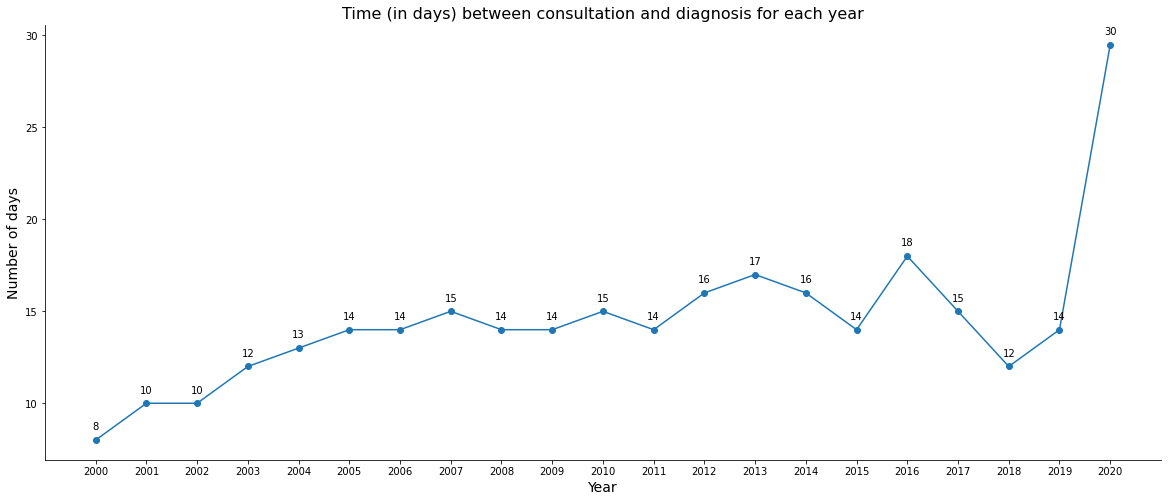

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(x, y, marker='o')
plt.xlabel('Year', size=14)
plt.xticks(x)
plt.ylabel('Number of days', size=14)
plt.title('Time (in days) between consultation and diagnosis for each year', size=16)
for xi, yi in zip(x,y):
    label = "{:.0f}".format(yi)
    plt.annotate(label, # this is the text
                 (xi, yi), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [ ]:
x = np.sort(df_diag1.ANODIAG.unique())
y = df_diag1.groupby('ANODIAG')['CONSDIAG'].median() #mediana do número de dias entre consulta e diagnóstico

fig = go.Figure(go.Scatter(x=x, y=y, mode = 'lines+markers+text', text=y, textposition='top center'))
fig.update_layout(title='Mediana do número de dias entre consulta e diagnóstico por ano',
                   xaxis_title='Ano',
                   yaxis_title='Número de dias')
fig.show()

Now comparing patients without previous diagnosis with those who had the diagnosis, we can a much higher number of days to start treatment for people who already had the diagnosis of the disease, probably because they may have sought after other medical opinions, having gone to more than one hospital, delaying the start of cancer treatment.

In this analysis, C44 topographies (with morphologies between 80101 and 81103), who did not undergo any treatment (NAOTRAT = 8) and morphology 80001 (neoplasms with uncertain behavior) were excluded.

In [ ]:
df1 = df_diag1[(df_diag1.TOPOGRUP == 'C44') & (df_diag1.MORFO > 80101) & (df_diag1.MORFO < 81103)]
df2 = df_diag2[(df_diag2.TOPOGRUP == 'C44') & (df_diag2.MORFO > 80101) & (df_diag2.MORFO < 81103)]

id1 = df1.index
df_diag1 = df_diag1.drop(id1)

id2 = df2.index
df_diag2 = df_diag2.drop(id2)

df_diag1 = df_diag1[(df_diag1.NAOTRAT == 8) & (df_diag1.MORFO != 80001)] 
df_diag2 = df_diag2[(df_diag2.NAOTRAT == 8) & (df_diag2.MORFO != 80001)]

x1 = np.sort(df_diag1.ANODIAG.unique())
y1 = df_diag1.groupby('ANODIAG')['DIAGTRAT'].median()

x2 = np.sort(df_diag2.ANODIAG.unique())
y2 = df_diag2.groupby('ANODIAG')['DIAGTRAT'].median()

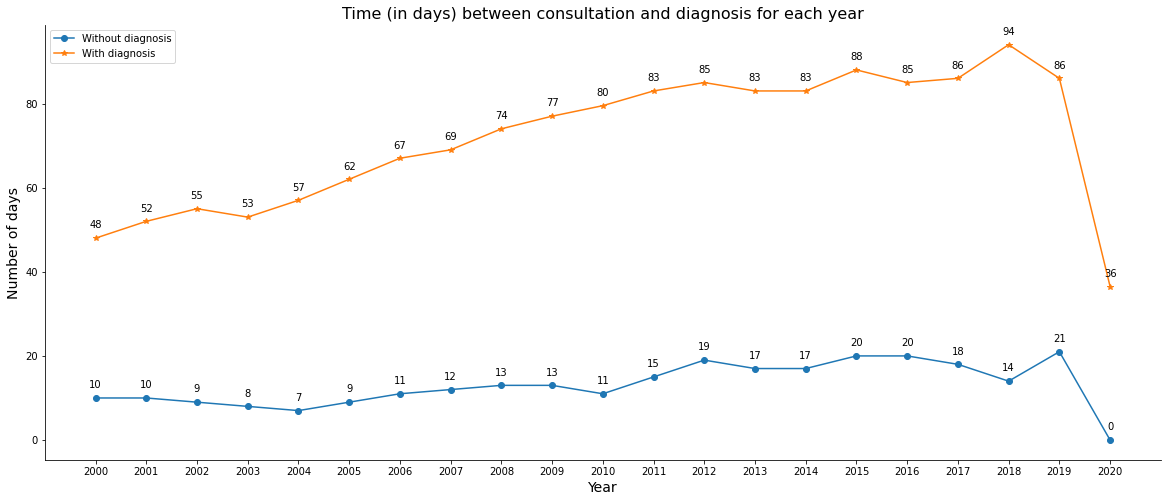

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax1 = ax.plot(x1, y1, label='Without diagnosis', marker='o')
ax2 = ax.plot(x2, y2, label='With diagnosis', marker='*')
ax.set_xlabel('Year', size=14)
ax.set_xticks(x1)
ax.set_ylabel('Number of days', size=14)
ax.set_title('Time (in days) between consultation and diagnosis for each year', size=16)
ax.legend()
for xi1, yi1, xi2, yi2 in zip(x1, y1, x2, y2):
    label1 = '{:.0f}'.format(yi1)
    label2 = '{:.0f}'.format(yi2)
    ax.annotate(label1, # this is the text
                (xi1, yi1), # this is the point to label
                textcoords='offset points', # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    ax.annotate(label2, # this is the text
                (xi2, yi2), # this is the point to label
                textcoords='offset points', # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = x1,
                         y = y1,
                         name = 'Sem diagnóstico',
                         mode = 'lines+markers+text', 
                         text=y1, textposition='top center',
              ))

fig.add_trace(go.Scatter(x = x2,
                         y = y2,
                         name = 'Com diagnóstico',
                         mode = 'lines+markers+text', 
                         text=y2, textposition='top center',
              ))

fig.update_layout(title_text='Número de dias entre diagnóstico e tratamento por ano',
                  yaxis_title = 'Número de dias', xaxis_title = 'Ano')

fig.show()

Now looking at the data from the latest patient information, we have a higher number of women in the category alive and of men in the two categories related to patient death, by cancer and other causes.

In [ ]:
# 1 – Alive with cancer; 2 – Alive, without other specifications;
# 3 – Death by cancer; 4 – Death by other causes, without other specifications
data['ULTINFO'].value_counts()

2    435227
3    275159
4    123266
1    110008
Name: ULTINFO, dtype: int64

In [ ]:
mascx = np.sort(masc.ULTINFO.unique())
mascy = masc.ULTINFO.value_counts().sort_index()

femx = np.sort(fem.ULTINFO.unique())
femy = fem.ULTINFO.value_counts().sort_index()

x_ticks = ["Alive with cancer", "Alive, without other specifications", "Death by cancer", "Death by other causes"]

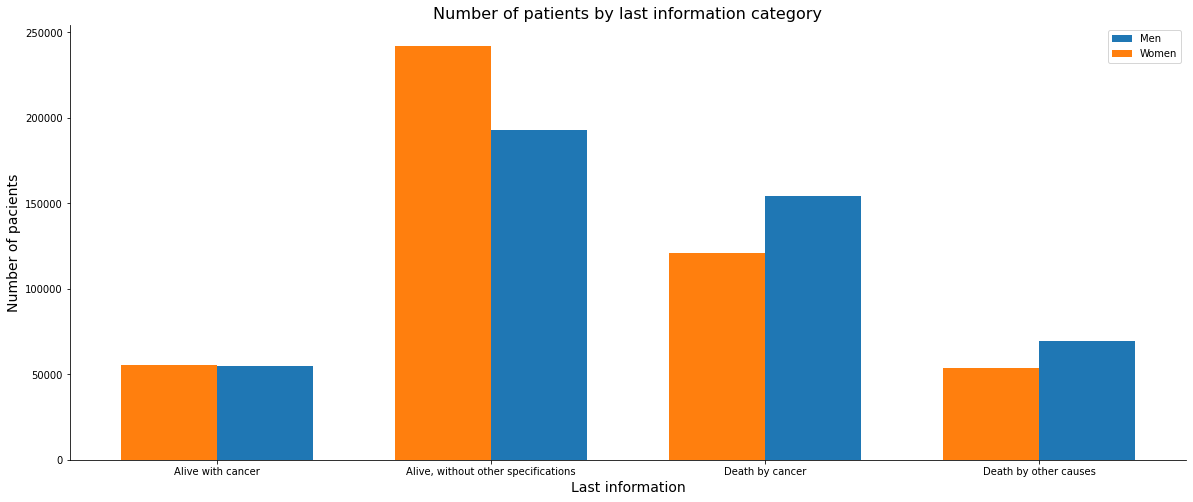

In [ ]:
x = np.arange(len(x_ticks))
fig, ax = plt.subplots(figsize=(20, 8))
width = 0.35
ax1 = ax.bar(x + width/2, mascy, width, label='Men')
ax2 = ax.bar(x - width/2, femy, width, label='Women')
ax.set_xlabel('Last information', size=14)
ax.set_ylabel('Number of pacients', size=14)
ax.set_title('Number of patients by last information category', size=16)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(list(x_ticks))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
mascx = np.sort(masc.ULTINFO.unique())
mascy = masc.ULTINFO.value_counts().sort_index()

femx = np.sort(fem.ULTINFO.unique())
femy = fem.ULTINFO.value_counts().sort_index()

fig = go.Figure()

fig.add_trace(go.Bar(x = mascx,
                     y = mascy,
                     name = 'Masculino',
              ))

fig.add_trace(go.Bar(x = femx,
                     y = femy,
                     name = 'Feminino',
              ))

fig.update_xaxes(
    ticktext=["Vivo, com câncer", "Vivo, SOE", "Óbito por câncer", "Óbito outras causa, SOE"],
    tickvals=[1, 2, 3, 4],
)

fig.update_layout(barmode = 'group', title_text='Última informação dos pacientes',
                  yaxis_title = 'Indivíduos', xaxis_title = 'Última informação')

fig.show()

Now we will analyze the correlation of the `ULTINFO` column with the others in this dataset, we notice a good correlation with `PERDASEG`, which indicates whether the patient is being monitored by the hospital, and with the `ANODIAG` column, which has the year of the patient's diagnosis, otherwise we don't have such high correlations. 


In [ ]:
corr_matrix = data.corr()
corr_matrix['ULTINFO'].sort_values(ascending = False)

ULTINFO       1.000000
CATEATEND     0.209677
IDADE         0.179051
GLEASON       0.123226
PSA           0.118750
NENHUM        0.108192
LATERALI      0.077999
RECREGIO      0.068783
QUIMIO        0.054078
NENHUMAPOS    0.052510
RADIO         0.037872
RECLOCAL      0.034662
RECDIST       0.019467
G             0.019415
IDMITOTIC     0.011788
NENHUMANT     0.008194
CIRURANT     -0.000522
RADIOANT     -0.000522
TMO          -0.003801
IMUNO        -0.004610
OUTROS       -0.004980
TMOAPOS      -0.006424
IMUNOAPOS    -0.007243
BASEDIAG     -0.016254
IBGE         -0.016555
LOCALTNM     -0.018795
TRATCONS     -0.021244
CIRURAPOS    -0.024802
HORMOAPOS    -0.029185
IBGEATEN     -0.037029
OUTROAPOS    -0.042629
RRAS         -0.043626
RADIOAPOS    -0.044204
CONSDIAG     -0.045605
DIAGPREV     -0.049736
QUIMIOAPOS   -0.049821
DIAGTRAT     -0.055853
HORMONIO     -0.060877
CIDO         -0.062996
MORFO        -0.063005
CLINICA      -0.063309
RECNENHUM    -0.068966
ESCOLARI     -0.069296
SEXO       

In the correlation matrix we can see the correlations between all columns and as described above for the case of the analysis only for `ULTINFO`, we do not have very high correlations. 

It is important to note that the data has not been processed yet, so after preprocessing a more explanatory matrix for the data should be obtained.

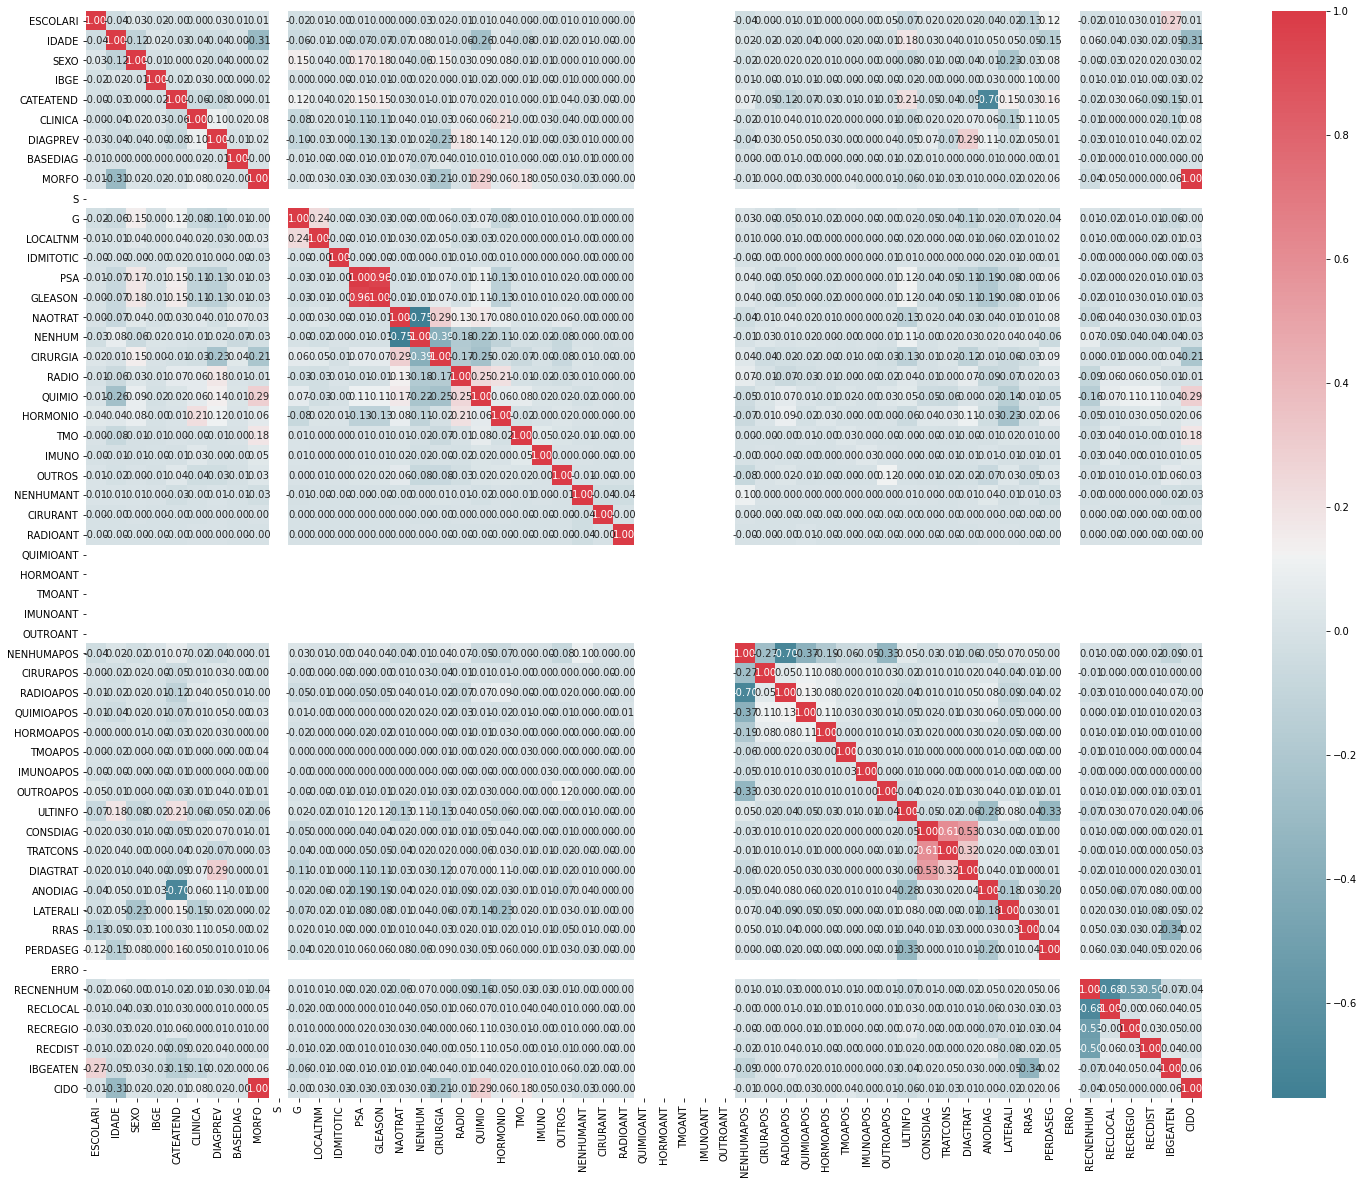

In [ ]:
fig, ax = plt.subplots(figsize = (25,20))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
 
sns.heatmap(corr_matrix, cmap = colormap, annot = True, fmt = '.2f')
fig.show()

With the histograms you can see how the distributions of the dataset columns are, but since we have most of them with categorical data, the histograms bring information about the amount of data in the respective categories.

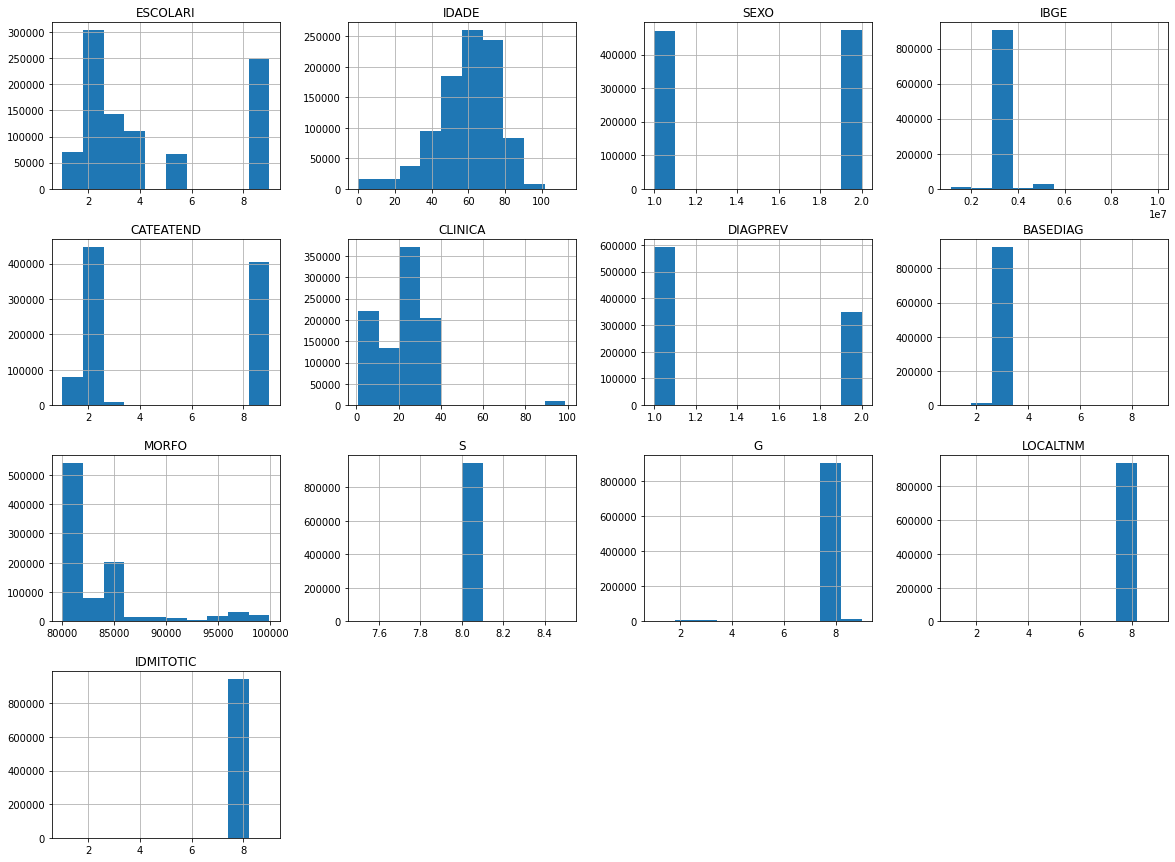

In [ ]:
data.iloc[:,:30].hist(bins=10,figsize=(20,15))
plt.show()

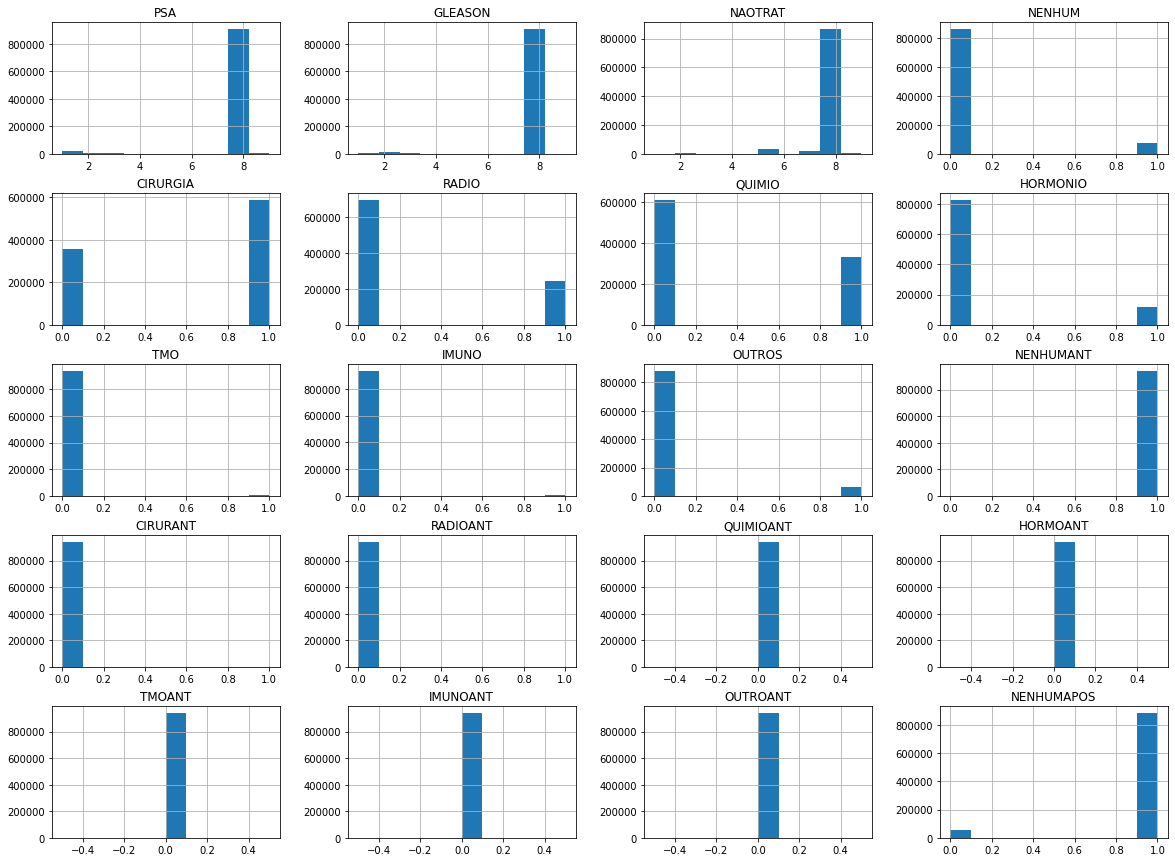

In [ ]:
data.iloc[:,30:60].hist(bins=10,figsize=(20,15))
plt.show()

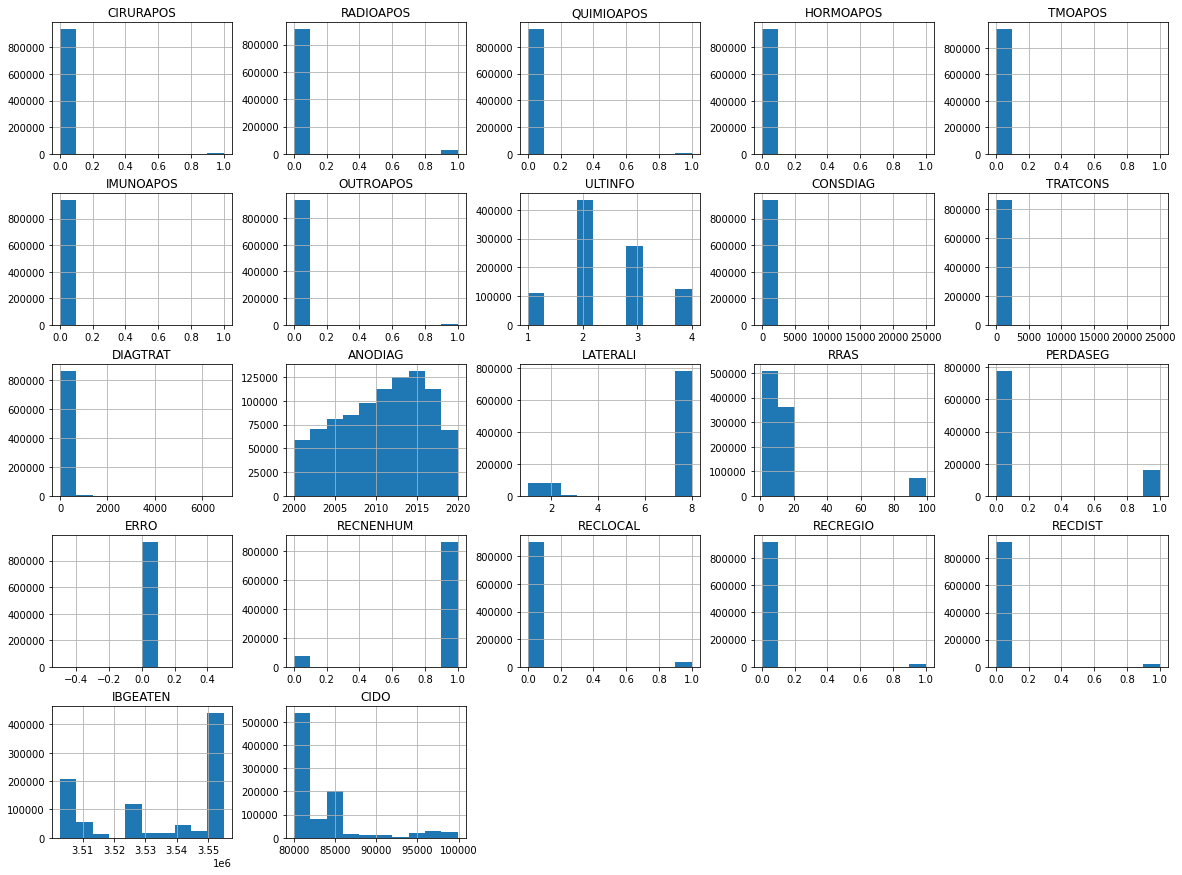

In [ ]:
data.iloc[:,60:].hist(bins=10,figsize=(20,15))
plt.show()

### **Análise cidade de residência e não realização do tratamento**

In [ ]:
data.head(3)

,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,DESCTOPO,MORFO,DESCMORFO,EC,ECGRUP,T,N,M,PT,PN,PM,S,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,OUTRACLA,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,...,HORMOANT,TMOANT,IMUNOANT,OUTROANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,CICISUBGRU,FAIXAETAR,LATERALI,INSTORIG,DRS,RRAS,PERDASEG,ERRO,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,CIDO,DSCCIDO
0,4,40.0,2,SP,SP,3530805,MOGIMIRIM,9,2000-01-03,15,1,2000-01-10,3,C539,C53,COLO DO UTERO,81402,ADENOCARCINOMA IN SITU SOE,0,0,X,X,0,IS,0,0,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,07/04/2000,8,A,...,0,0,0,0,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,NaN,NaN,NaN,40-49,8,NaN,DRS 14 SĂO JOĂO DA BOA VISTA,15,1,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,81402.0,ADENOCARCINOMA IN SITU SOE
1,9,45.0,2,RJ,SP,3509502,CAMPINAS,9,2000-01-05,15,1,2000-01-17,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,20/01/2000,8,F,...,0,0,0,0,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,NaN,NaN,NaN,40-49,8,NaN,DRS 07 CAMPINAS,15,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE
2,2,63.0,2,MG,SP,3509502,CAMPINAS,9,2000-01-19,15,1,2000-01-25,3,C539,C53,COLO DO UTERO,80703,CARCINOMA ESCAMOCELULAR SOE,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,03/02/2000,8,B,...,0,0,0,0,1,0,0,0,0,0,0,0,2001-03-20,3,6,15.0,9.0,2000,NaN,NaN,NaN,60-69,8,NaN,DRS 07 CAMPINAS,15,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3509502,80703.0,CARCINOMA ESCAMOCELULAR SOE


In [ ]:
df_muni = data[['UFRESID', 'IBGE', 'NAOTRAT']]
df_muni = df_muni[df_muni.UFRESID != 'OP']
df_muni.head(3)

,UFRESID,IBGE,NAOTRAT
0,SP,3530805,8
1,SP,3509502,8
2,SP,3509502,8


In [ ]:
df_cities = pd.read_csv('https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv')
df_cities = df_cities[['codigo_ibge', 'nome', 'latitude', 'longitude']]
df_cities.head()

,codigo_ibge,nome,latitude,longitude
0,5200050,Abadia de Goiás,-16.75730,-49.4412
1,3100104,Abadia dos Dourados,-18.48310,-47.3916
2,5200100,Abadiânia,-16.19700,-48.7057
3,3100203,Abaeté,-19.15510,-45.4444
4,1500107,Abaetetuba,-1.72183,-48.8788


In [ ]:
df_muni = df_muni.merge(df_cities, how='left', left_on='IBGE', right_on='codigo_ibge')
df_muni.head(5)

,UFRESID,IBGE,NAOTRAT,codigo_ibge,nome,latitude,longitude
0,SP,3530805,8,3530805,Mogi Mirim,-22.4332,-46.9532
1,SP,3509502,8,3509502,Campinas,-22.9053,-47.0659
2,SP,3509502,8,3509502,Campinas,-22.9053,-47.0659
3,SP,3545803,8,3545803,Santa Bárbara d'Oeste,-22.7553,-47.4143
4,SP,3530805,8,3530805,Mogi Mirim,-22.4332,-46.9532


In [ ]:
df_muni.NAOTRAT.value_counts()

8    868164
5     30655
7     20391
2      9166
9      7323
6      2474
3      1892
4      1718
1      1581
Name: NAOTRAT, dtype: int64

In [ ]:
df_muni['razao'] = df_muni.NAOTRAT.replace([1,2,3,4,5,6,7,8,9],
                                           ['RECUSA DO TRATAMENTO','DOENÇA AVANÇADA, FALTA DE CONDIÇÕES CLINICAS','OUTRAS DOENÇAS ASSOCIADAS',
                                            'ABANDONO DE TRATAMENTO','OBITO POR CANCER','OBITO POR OUTRAS CAUSAS, SOE','OUTRAS','NÃO SE APLICA',
                                            'SEM INFORMAÇÃO'])
df_muni.head(3)

,UFRESID,IBGE,NAOTRAT,codigo_ibge,nome,latitude,longitude,razao
0,SP,3530805,8,3530805,Mogi Mirim,-22.4332,-46.9532,NÃO SE APLICA
1,SP,3509502,8,3509502,Campinas,-22.9053,-47.0659,NÃO SE APLICA
2,SP,3509502,8,3509502,Campinas,-22.9053,-47.0659,NÃO SE APLICA


In [ ]:
df_naotrat = df_muni[df_muni.NAOTRAT.isin([1,4,7])]
df_naotrat.shape

(23690, 8)

In [ ]:
df_hosp = pd.DataFrame()
df_hosp['Hospitais'] = data.IBGEATEN.unique()
df_hosp.head(2)

,Hospitais
0,3509502
1,3543402


In [ ]:
df_hosp = df_hosp.merge(df_cities, how='left', left_on='Hospitais', right_on='codigo_ibge')
df_hosp.head()

,Hospitais,codigo_ibge,nome,latitude,longitude
0,3509502,3509502,Campinas,-22.9053,-47.0659
1,3543402,3543402,Ribeirão Preto,-21.1699,-47.8099
2,3554102,3554102,Taubaté,-23.0104,-45.5593
3,3550308,3550308,São Paulo,-23.5329,-46.6395
4,3506003,3506003,Bauru,-22.3246,-49.0871


In [ ]:
fig = px.scatter_geo(df_naotrat, 
                     lat='latitude', 
                     lon='longitude',
                     color='razao',
                     scope='south america',
                     projection='natural earth'
                     )

fig.add_scattergeo(lat=df_hosp.latitude, 
                   lon=df_hosp.longitude,
                   name='Hospitais',
                   marker=dict(color='orange', size=7, symbol='diamond')
                   )

fig.update_layout(template='xgridoff', 
                  margin={"r":0,"l":0,"b":0}, 
                  title_text="Razão para não tratamento")
fig.update_layout()

fig.show()

## **Missing values**

Now let's see the amount of missing values per column, we have 17 columns with more than 50% of missing data, if we want to use any of these for the machine learning models, it will be necessary to treat the missing values, placing 0 or some string that indicates that the value is missing, for example. Another option is not using the columns in the analysis, we will see later in this project the proposed solutions to solve this problem.

In [ ]:
missing = data.isna().sum().sort_values(ascending=False)
prop = missing[missing > 0]/data.shape[0]
prop

INSTORIG      0.999511
REC04         0.998494
META04        0.996361
REC03         0.994401
META03        0.987246
REC02         0.982164
CICI          0.972926
CICIGRUP      0.972926
CICISUBGRU    0.972926
META02        0.960153
REC01         0.937256
OUTRACLA      0.935571
DTRECIDIVA    0.899434
META01        0.868684
PM            0.579580
PN            0.556207
PT            0.551369
TRATCONS      0.079368
DIAGTRAT      0.079368
DTTRAT        0.079368
DRS           0.075212
DTULTINFO     0.000048
CIDO          0.000031
DSCCIDO       0.000031
DESCMORFO     0.000003
IDADE         0.000001
dtype: float64

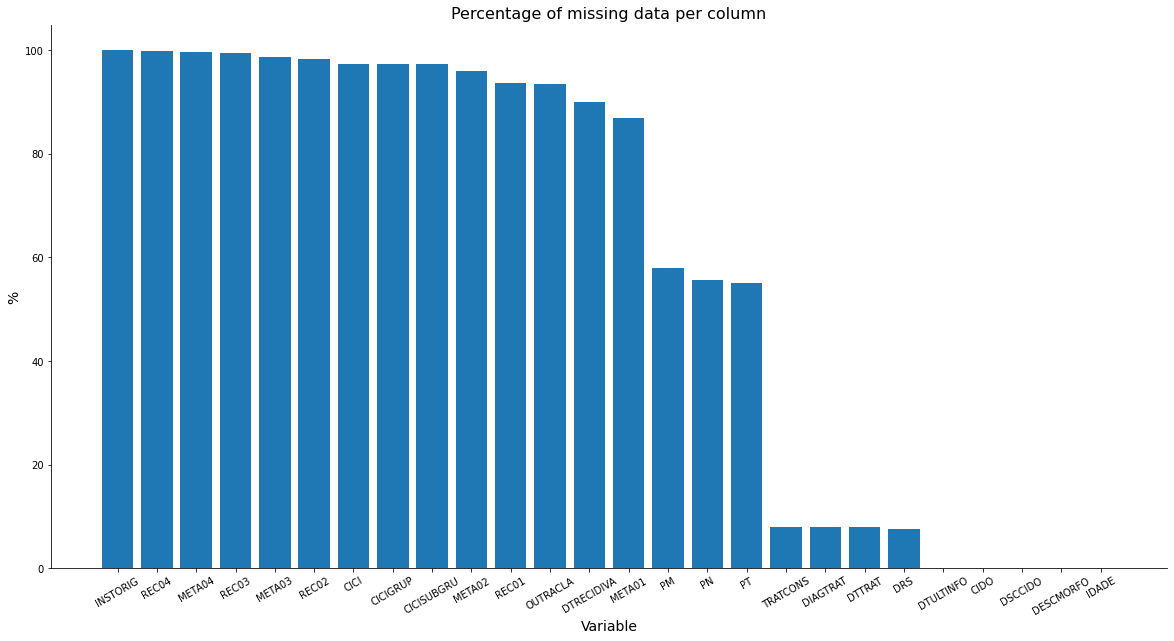

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(height = prop*100, x=prop.index)
plt.xlabel('Variable', size=14)
plt.ylabel('%', size=14)
plt.title('Percentage of missing data per column', size=16)
plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
fig = px.bar(x = prop.index, y = prop*100, labels={'y': '%', 'x':'Variable'},
             title='Percentage of missing data per column')
fig.show()

In [ ]:
# INSTORIG - Instituição de origem. Obrigatório somente se DIAGPREV = 03 – COM DIAGNÓSTICO / COM TRATAMENTO
data[data['INSTORIG'].isna() == False]['INSTORIG'].shape

(461,)

In [ ]:
# REC04 - Local da recidiva/metástase. Formato: C99
data[data['REC04'].isna() == False]['REC04'].shape

(1421,)

In [ ]:
# META04 - Metástase. Formato: C99
data[data['META04'].isna() == False]['META04'].shape

(3434,)

In [ ]:
# REC03 - Local da recidiva/metástase. Formato: C99
data[data['REC03'].isna() == False]['REC03'].shape

(5284,)

In [ ]:
# META03 - Metástase. Formato: C99
data[data['META03'].isna() == False]['META03'].shape

(12035,)

In [ ]:
# REC02 - Local da recidiva/metástase. Formato: C99
data[data['REC02'].isna() == False]['REC02'].shape

(16831,)

In [ ]:
# CICI - Tumor infantil
data[data['CICI'].isna() == False]['CICI'].shape

(25549,)

In [ ]:
# CICIGRUP - Tumor infantil - Grupo
data[data['CICIGRUP'].isna() == False]['CICIGRUP'].shape

(25549,)

In [ ]:
# CICISUBGRU - Tumor infantil - Sub grupo
data[data['CICISUBGRU'].isna() == False]['CICISUBGRU'].shape

(25549,)

In [ ]:
# META02 - Metástase. Formato: C99
data[data['META02'].isna() == False]['META02'].shape

(37602,)

In [ ]:
# REC01 - Local da recidiva/metástase. Formato: C99
data[data['REC01'].isna() == False]['REC01'].shape

(59209,)

In [ ]:
# OUTRACLA - Outra classificação de estadiamento
data[data['OUTRACLA'].isna() == False]['OUTRACLA'].shape

(60799,)

In [ ]:
# DTRECIDIVA - Data da última ocorrência de recidiva
data[data['DTRECIDIVA'].isna() == False]['DTRECIDIVA'].shape

(94900,)

In [ ]:
# META01 - Metástase. Formato: C99
data[data['META01'].isna() == False]['META01'].shape

(123918,)

In [ ]:
# PM - Estadiamento pós cirúrgico
data[data['PM'].isna() == False]['PM'].shape

(396734,)

In [ ]:
# PN - Estadiamento pós cirúrgico
data[data['PN'].isna() == False]['PN'].shape

(418790,)

In [ ]:
# PT - Estadiamento pós cirúrgico
data[data['PT'].isna() == False]['PT'].shape

(423355,)

In [ ]:
# TRATCONS - Diferença em dias entre as datas de consulta e tratamento
data[data['TRATCONS'].isna() == False]['TRATCONS'].shape

(868764,)

In [ ]:
# DIAGTRAT - Diferença em dias entre as datas de tratamento e diagnóstico
data[data['DIAGTRAT'].isna() == False]['DIAGTRAT'].shape

(868764,)

In [ ]:
# DTTRAT - Data de inicio do tratamento 
data[data['DTTRAT'].isna() == False]['DTTRAT'].shape

(868764,)

In [ ]:
# DRS - DRS 
data[data['DRS'].isna() == False]['DRS'].shape

(872685,)

In [ ]:
# DTULTINFO - Data da última informação do paciente
data[data['DTULTINFO'].isna() == False]['DTULTINFO'].shape

(943615,)

In [ ]:
# CIDO - Código da morfologia 3ª Edição
data[data['CIDO'].isna() == False]['CIDO'].shape 

(943631,)

In [ ]:
# DSCCIDO - Descrição da morfologia 3ª Edição
data[data['DSCCIDO'].isna() == False]['DSCCIDO'].shape 

(943631,)

In [ ]:
# DESCMORFO - Descrição da morfologia
data[data['DESCMORFO'].isna() == False]['DESCMORFO'].shape

(943657,)

In [ ]:
# IDADE - Idade do paciente
data[data['IDADE'].isna() == False]['IDADE'].shape

(943659,)

## **Columns analysis**

In this section, the columns will be analyzed individually, with the aim of examining each one of them and obtaining a function that will be used in the data before starting the study with the machine learning models.

The columns were divided according to the type of each one, resulting in the categories: dates, numeric categories, letters categories, numbers, strings, letters and numbers categories.

Columns with unique values will be dropped from the dataset in the function called `variables_preprocessing`. Another treatment that will be done in the columns is the filling of string columns with missing values with ** Sem informação **, being the columns:

* `META01`;

* `META02`;

* `META03`;

* `META04`;

* `REC01`;

* `REC02`;

* `REC03`;

* `REC04`;

* `PT`;

* `PN`;

* `PM`;

* `CICI`;

* `CICIGRUP`.

The `DRS` column will have the missing values filled with 0, after using the split method to obtain only the numbers in this column, just as done for the `CICIGRUP` column.

Finally, the columns that were dropped from the dataset, because they have unique values or because they are descriptions of the disease, are the following:

* `S`;

* `QUIMIOANT`;

* `HORMOANT`;

* `TMOANT`;

* `IMUNOANT`;

* `OUTROANT`;

* `ERRO`;

* `CIDO`;

* `UFNASC`;

* `CIDADE`;

* `DESCTOPO`;

* `DESCMORFO`;

* `DSCCIDO`;

* `CICISUBGRU`;

* `INSTORIG`;

* `OUTRACLA`.

> Check the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

In [ ]:
df_aux = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/pacigeral.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (23,24,25,32,36,78,91) have mixed types.Specify dtype option on import or set low_memory=False.



(943660, 95)


### **Dates**

*   **DTCONSULT**: Data da 1ª consulta (date = 10). Formato: DD/MM/YYYY	
*   **DTDIAG**: Data do diagnóstico (date = 10). Formato: DD/MM/YYYY
*   **DTTRAT**: Data de inicio do tratamento (date = 10). Formato: DD/MM/YYYY	
*   **DTULTINFO**: Data da última informação do paciente (date = 10). Formato: DD/MM/YYYY
*   **DTRECIDIVA**: Data da última ocorrência de recidiva (date = 10). Formato: DD/MM/YYYY

In [ ]:
# Data - DTCONSULT, DTDIAG, DTTRAT, DTULTINFO, DTRECIDIVA
dates = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA']
df_aux[dates].isna().sum()

DTCONSULT          0
DTDIAG             0
DTTRAT         74896
DTULTINFO         45
DTRECIDIVA    848760
dtype: int64

In [ ]:
(df_aux[dates].isna().sum()/df_aux.shape[0])*100

DTCONSULT      0.000000
DTDIAG         0.000000
DTTRAT         7.936757
DTULTINFO      0.004769
DTRECIDIVA    89.943412
dtype: float64

### **Numerical categories**

*   **ESCOLARI**: Código para escolaridade do paciente (int = 1).

      1 – ANALFABETO

      2 – ENS. FUND. INCOMPLETO

      3 – ENS. FUND. COMPLETO

      4 – ENSINO MÉDIO

      5 – SUPERIOR

      9 – IGNORADA

In [ ]:
df_aux.ESCOLARI.value_counts()

2    303175
9    249236
3    142196
4    110885
1     71032
5     67136
Name: ESCOLARI, dtype: int64

*   **SEXO**: Sexo do paciente (int = 1). 

      1 – MASCULINO

      2 – FEMININO

In [ ]:
df_aux.SEXO.value_counts()

2    472175
1    471485
Name: SEXO, dtype: int64

*   **CATEATEND**: Categoria de atendimento ao diagnóstico (int = 1). 

      1 - CONVENIO

      2 - SUS

      3 – PARTICULAR

      9 – SEM INFORMAÇÃO

In [ ]:
df_aux.CATEATEND.value_counts()

2    448124
9    404512
1     80862
3     10162
Name: CATEATEND, dtype: int64

*   **CLINICA**: Código da clinica (int = 2).

      1 – ALERGIA/IMUNOLOGIA

      2 – CIRURGIA CARDIACA

      3 – CIRURGIA CABEÇA E PESCOÇO

      4 – CIRURGIA GERAL

      5 – CIRURGIA PEDIATRICA

      6 – CIRURGIA PLASTICA

      7 – CIRURGIA TORAXICA

      8 – CIRURGIA VASCULAR

      9 – CLINICA MEDICA

      10 – DERMATOLOGIA

      11 – ENDOCRINOLOGIA

      12 – GASTROCIRURGIA
      
      13 – GASTROENTEROLOGIA
      
      14 – GERIATRIA
      
      15 – GINECOLOGIA
      
      16 – GINECOLOGIA / OBSTETRICIA
      
      17 – HEMATOLOGIA
      
      18 – INFECTOLOGIA
      
      19 – NEFROLOGIA
      
      20 – NEUROCIRURGIA
      
      21 – NEUROLOGIA
      
      22 – OFTALMOLOGIA
      
      23 – ONCOLOGIA CIRURGICA
      
      24 – ONCOLOGIA CLINICA
      
      25 – ONCOLOGIA PEDIATRICA
      
      26 – ORTOPEDIA
      
      27 – OTORRINOLARINGOLOGIA
      
      28 – PEDIATRIA
      
      29 – PNEUMOLOGIA
      
      30 – PROCTOLOGIA
      
      31 – RADIOTERAPIA
      
      32 – UROLOGIA
      
      33 – MASTOLOGIA
      
      34 – ONCOLOGIA CUTANEA
      
      35 – CIRURGIA PELVICA
      
      36 – CIRURGIA ABDOMINAL
      
      37 – ODONTOLOGIA
      
      38 – TRANSPLANTE HEPATICO
      
      99 – IGNORADO

In [ ]:
np.sort(df_aux.CLINICA.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 99])

*   **DIAGPREV**: Diagnóstico e tratamento anterior (int = 1).

      1 – SEM DIAGNÓSTICO / SEM TRATAMENTO
      
      2 – COM DIAGNÓSTICO / SEM TRATAMENTO
      
      3 – COM DIAGNÓSTICO / COM TRATAMENTO
      
      4 – OUTROS

In [ ]:
df_aux.DIAGPREV.value_counts()

1    593200
2    350460
Name: DIAGPREV, dtype: int64

*   **BASEDIAG**: Código da base do diagnóstico (int = 1).
      
      1 – EXAME CLINICO
      
      2 – RECURSOS AUXILIARES NÃO MICROSCÓPICOS
      
      3 – CONFIRMAÇÃO MICROSCÓPICA
      
      9 – SEM INFORMAÇÃO

In [ ]:
df_aux.BASEDIAG.value_counts()

3    927294
2     13320
1      2059
9       987
Name: BASEDIAG, dtype: int64

*   **S**: Classificação TNM - S (int = 1). Domínio: 0; 1; 2; 3; 8 – NÃO SE APLICA; 9 – X
*   **G**: Classificação TNM – G (Grau) (char = 5). 

      Domínio (exceto C40, C41, C381, C382, C383, C47, C48 e C49):
      0; 1; 2; 3; 4; 8 – NÃO SE APLICA; 9 – X

      Domínio (somente C40, C41, C381, C382, C383, C47, C48 e C49):
      ALTO; BAIXO; 8 – NÃO SE APLICA; 9 – X

In [ ]:
df_aux.S.value_counts() ### drop

8    943660
Name: S, dtype: int64

In [ ]:
df_aux.G.value_counts()

8    903222
9     12770
3     10600
2      8549
1      4720
4      3799
Name: G, dtype: int64

In [ ]:
# 8 - Not applicable, 9 - X
df_aux.G[df_aux.G < 8].count()

27668

*   **LOCALTNM**: Classificação TNM - Localização (int = 1).
      
      1 – SUPERIOR
      
      2 – MEDIO
      
      3 – INFERIOR
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **IDMITOTIC**: Classificação TNM – Índice Mitótico (int = 1).
      
      1 – ALTA
      
      2 – BAIXA
      
      8 – NÃO SE APLICA
      
      9 – X	

In [ ]:
df_aux.LOCALTNM.value_counts()

8    939049
2      2006
9      1384
1       625
3       596
Name: LOCALTNM, dtype: int64

In [ ]:
# 8 - Not applicable, 9 - X
df_aux.LOCALTNM[df_aux.LOCALTNM < 8].count()

3227

In [ ]:
df_aux.IDMITOTIC.value_counts()

8    943155
2       267
1       151
9        87
Name: IDMITOTIC, dtype: int64

In [ ]:
# 8 - Not applicable, 9 - X
df_aux.IDMITOTIC[df_aux.IDMITOTIC < 8].count()

418

*   **PSA**: Classificação TNM - PSA (int = 1).
      
      1 – MENOR QUE 10
      
      2 – MAIOR OU IGUAL A 10 E MENOR QUE 20
      
      3 – MAIOR OU IGUAL A 20
      
      8 – NÃO SE APLICA
      
      9 – X	
*   **GLEASON**: Classificação TNM - Gleason (int = 1).
      
      1 – MENOR OU IGUAL A 6
      
      2 – IGUAL A 7
      
      3 – MAIOR OU IGUAL A 8
      
      8 – NÃO SE APLICA
      
      9 – X	

In [ ]:
df_aux.PSA.value_counts()

8    911114
1     17698
2      6282
3      5362
9      3204
Name: PSA, dtype: int64

In [ ]:
# 8 - Not applicable, 9 - X
df_aux.PSA[df_aux.PSA < 8].count()

29342

In [ ]:
df_aux.GLEASON.value_counts()

8    911114
2     13794
1     10079
3      6282
9      2391
Name: GLEASON, dtype: int64

In [ ]:
# 8 - Não se aplica, 9 - X
df_aux.GLEASON[df_aux.GLEASON < 8].count()

30155

*   **NAOTRAT**: Código da razão para não realização do tratamento (int = 1).
      
      1 – RECUSA DO TRATAMENTO
      
      2 – DOENÇA AVANÇADA, FALTA DE CONDIÇÕES CLINICAS
      
      3 – OUTRAS DOENÇAS ASSOCIADAS
      
      4 – ABANDONO DE TRATAMENTO
      
      5 – OBITO POR CANCER
      
      6 – OBITO POR OUTRAS CAUSAS, SOE
      
      7 – OUTRAS
      
      8 – NÃO SE APLICA (CASO TENHA TRATAMENTO)
      
      9 – SEM INFORMAÇÃO

In [ ]:
df_aux.NAOTRAT.value_counts()

8    868397
5     30655
7     20453
2      9166
9      7324
6      2474
3      1892
4      1718
1      1581
Name: NAOTRAT, dtype: int64

*   **NENHUM**: Tratamento recebido no hospital = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURGIA**: Tratamento recebido no hospital = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIO**: Tratamento recebido no hospital = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIO**: Tratamento recebido no hospital = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMONIO**: Tratamento recebido no hospital = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMO**: Tratamento recebido no hospital = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNO**: Tratamento recebido no hospital = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROS**: Tratamento recebido no hospital = outros (int = 1). 0 – NÃO; 1 – SIM

In [ ]:
df_aux.NENHUM.unique()

array([0, 1])

In [ ]:
df_aux.CIRURGIA.unique()

array([1, 0])

In [ ]:
df_aux.RADIO.unique()

array([0, 1])

In [ ]:
df_aux.QUIMIO.unique()

array([0, 1])

In [ ]:
df_aux.HORMONIO.unique()

array([0, 1])

In [ ]:
df_aux.TMO.unique()

array([0, 1])

In [ ]:
df_aux.IMUNO.unique()

array([0, 1])

In [ ]:
df_aux.OUTROS.unique()

array([0, 1])

*   **NENHUMANT**: Tratamento recebido fora do hospital e antes da admissão = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURANT**: Tratamento recebido fora do hospital e antes da admissão = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIOANT**: Tratamento recebido fora do hospital e antes da admissão = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIOANT**: Tratamento recebido fora do hospital e antes da admissão = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMOANT**: Tratamento recebido fora do hospital e antes da admissão = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMOANT**: Tratamento recebido fora do hospital e antes da admissão = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNOANT**: Tratamento recebido fora do hospital e antes da admissão = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROANT**: Tratamento recebido fora do hospital e antes da admissão = outros (int = 1). 0 – NÃO; 1 – SIM	

In [ ]:
df_aux.NENHUMANT.unique()

array([1, 0])

In [ ]:
df_aux.CIRURANT.unique()

array([0, 1])

In [ ]:
df_aux.RADIOANT.unique()

array([0, 1])

In [ ]:
df_aux.QUIMIOANT.unique() ### drop

array([0])

In [ ]:
df_aux.HORMOANT.unique() ### drop

array([0])

In [ ]:
df_aux.TMOANT.unique() ### drop

array([0])

In [ ]:
df_aux.IMUNOANT.unique() ### drop

array([0])

In [ ]:
df_aux.OUTROANT.unique() ### drop

array([0])

*   **NENHUMAPOS**: Tratamento recebido fora do hospital e durante/após admissão = nenhum	(int = 1). 0 – NÃO; 1 – SIM	
*   **CIRURAPOS**: Tratamento recebido fora do hospital e durante/após admissão = cirurgia	(int = 1). 0 – NÃO; 1 – SIM	
*   **RADIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = radioterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **QUIMIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = quimioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **HORMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = hormonioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **TMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = tmo	(int = 1). 0 – NÃO; 1 – SIM		
*   **IMUNOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = imunoterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **OUTROAPOS**: Tratamento recebido fora do hospital e durante/após admissão = outros	(int = 1). 0 – NÃO; 1 – SIM	

In [ ]:
df_aux.NENHUMAPOS.unique()

array([1, 0])

In [ ]:
df_aux.CIRURAPOS.unique()

array([0, 1])

In [ ]:
df_aux.RADIOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.QUIMIOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.HORMOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.TMOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.IMUNOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.OUTROAPOS.unique()

array([0, 1])

*   **ULTINFO**: Última informação sobre o paciente (int = 1).
      
      1 – VIVO, COM CÂNCER
      
      2 – VIVO, SOE
      
      3 – OBITO POR CANCER
      
      4 – OBITO POR OUTRAS CAUSAS, SOE

In [ ]:
df_aux.ULTINFO.value_counts()

2    435227
3    275159
4    123266
1    110008
Name: ULTINFO, dtype: int64

*   **LATERALI**: Lateralidade (int = 1).
      
      1 – DIREITA
      
      2 – ESQUERDA
      
      3 – BILATERAL
      
      8 - NÃO SE APLICA	

In [ ]:
df_aux.LATERALI.value_counts()

8    782219
1     81545
2     77560
3      2336
Name: LATERALI, dtype: int64

*   **PERDASEG**: Perda de seguimento (int = 1). 
      
      0 – Não
      
      1 – Sim
      
      8 – Não se aplica (excluído do cálculo para o indicador perda de seguimento)	

In [ ]:
df_aux.PERDASEG.value_counts()

0    779799
1    163861
Name: PERDASEG, dtype: int64

In [ ]:
df_aux[df_aux.PERDASEG == 1]['ULTINFO'].value_counts()

2    135234
1     28626
3         1
Name: ULTINFO, dtype: int64

*   **ERRO**: Admissão com erro (int = 1). 0 – Sem; 1 – Com
*   **RECNENHUM**: Sem recidiva (int = 1). 0 - Não; 1 - Sim
*   **RECLOCAL**: Recidiva local (int = 1). 0 - Não; 1 - Sim	
*   **RECREGIO**: Recidiva regional (int = 1). 0 - Não; 1 - Sim	
*   **RECDIST**: Recidiva a distância / metástase (int = 1). 0 - Não; 1 - Sim

In [ ]:
df_aux.ERRO.unique() ### drop

array([0])

In [ ]:
df_aux.RECNENHUM.value_counts()

1    865620
0     78040
Name: RECNENHUM, dtype: int64

In [ ]:
df_aux.RECLOCAL.value_counts()

0    905606
1     38054
Name: RECLOCAL, dtype: int64

In [ ]:
df_aux.RECREGIO.value_counts()

0    920649
1     23011
Name: RECREGIO, dtype: int64

In [ ]:
df_aux.RECDIST.value_counts()

0    922660
1     21000
Name: RECDIST, dtype: int64

### **Letter categories**

*   **TRATAMENTO**: Código de combinação dos tratamentos realizados (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado	
*   **TRATHOSP**: Código de combinação dos tratamentos realizados no hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento

      J – Nenhum tratamento realizado
*   **TRATFANTES**: Código de combinação dos tratamentos realizados antes/durante admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação
*   **TRATFAPOS**: Código de combinação dos tratamentos realizados após admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação

In [ ]:
df_aux.TRATAMENTO.unique()

array(['A', 'F', 'B', 'D', 'G', 'I', 'J', 'C', 'E', 'H'], dtype=object)

In [ ]:
df_aux.TRATHOSP.unique()

array(['A', 'F', 'B', 'D', 'G', 'I', 'J', 'C', 'E', 'H'], dtype=object)

In [ ]:
df_aux.TRATFANTES.unique()

array(['J', 'A', 'B'], dtype=object)

In [ ]:
df_aux.TRATFAPOS.unique()

array(['J', 'B', 'C', 'I', 'F', 'A', 'D', 'E', 'G', 'H'], dtype=object)

### **Numbers**

*   **IDADE**: Idade do paciente (int = 3).


In [ ]:
df_aux.IDADE.nunique()

109

In [ ]:
df_aux[df_aux.IDADE.isnull() == True]

,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,DESCTOPO,MORFO,DESCMORFO,EC,ECGRUP,T,N,M,PT,PN,PM,S,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,OUTRACLA,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,...,HORMOANT,TMOANT,IMUNOANT,OUTROANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,CICISUBGRU,FAIXAETAR,LATERALI,INSTORIG,DRS,RRAS,PERDASEG,ERRO,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,CIDO,DSCCIDO
125874,9,NaN,1,BA,SP,3549904,SAO JOSE DOS CAMPOS,9,2011-11-16,24,2,2011-03-11,3,C619,C61,PROSTATA,85503,CARCINOMA DE CELULAS ACINOSAS,IV,IV,4,0,0,NaN,NaN,NaN,8,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN,18/11/2011,8,I,...,0,0,0,0,1,0,0,0,0,0,0,0,2015-08-28,3,250,2.0,252.0,2011,XIF,XI OUTROS NEOPLASMAS MALIGNOS EPITELIAIS E OU...,F OUTROS CARCINOMAS E CARCINOMAS NAO ESPECIFI...,70+,8,NaN,DRS 17 TAUBATÉ,17,0,0,NaN,1,0,0,0,NaN,NaN,NaN,NaN,3549904,85503.0,CARCINOMA DE CELULAS ACINOSAS


*   **CONSDIAG**: Diferença em dias entre as datas de consulta o diagnóstico (num = dias).
*   **TRATCONS**: Diferença em dias entre as datas de consulta e tratamento (num = dias).	
*   **DIAGTRAT**: Diferença em dias entre as datas de tratamento e diagnóstico (num = dias).


In [ ]:
df_aux.CONSDIAG.isna().sum()

0

In [ ]:
df_aux.TRATCONS.isna().sum()

74896

In [ ]:
df_aux.TRATCONS.median()

39.0

In [ ]:
df_aux.DIAGTRAT.isna().sum()

74896

In [ ]:
df_aux.DIAGTRAT.median()

32.0

*   **ANODIAG**: Ano de diagnóstico (int = 4). Formato: 9999


In [ ]:
np.sort(df_aux.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

*   **IBGE**: Código da cidade de residência do paciente segundo IBGE com digito verificador (int = 7).
*   **IBGEATEN**: Código IBGE da instituição (int = 7).	


In [ ]:
df_aux.IBGE.nunique()

2955

In [ ]:
df_aux.IBGE.isna().sum()

0

In [ ]:
df_aux.IBGEATEN.isna().sum()

0

In [ ]:
df_aux.IBGEATEN.unique()

array([3509502, 3543402, 3554102, 3550308, 3506003, 3510609, 3530706,
       3547809, 3549904, 3552205, 3548708, 3548500, 3504503, 3507506,
       3507605, 3525904, 3503307, 3526902, 3538709, 3503208, 3505500,
       3516200, 3548906, 3525300, 3511102, 3549805, 3541406, 3529005,
       3524402, 3502804, 3522406, 3536208, 3552809, 3555000, 3530607,
       3518404, 3548807, 3543907, 3504008, 3513801, 3549102, 3518701,
       3534708, 3524808])

*   **CIDO**: Código da morfologia 3ª Edição (int = 5). Formato: 99999	
*   **MORFO**: Código da morfologia (char = 5). Formato: 99999


In [ ]:
df_aux.CIDO.isna().sum()

29

In [ ]:
df_aux.CIDO.unique()

array([81402., 80703., 81403., 84803., 80102., 85003., 85303., 85202.,
       89303., 86201., 85203., 85002., 83803., 83103., 85603., 80763.,
       80103., 89803., 89503., 80723., 84403., 80503., 85103., 85703.,
       80772., 80203., 82113., 80702., 82603., 85901., 88003., 90703.,
       88903., 85033., 89333., 91001., 85043., 84413., 84603., 87203.,
       84621., 86231., 82013., 85223., 88013., 84421., 90203., 90603.,
       85012., 90803., 82303., 82513., 91013., 85423., 80713., 86501.,
       80903., 80413., 95913., 80513., 82003., 80333., 90201., 80013.,
       80003., 80001., 84721., 86203., 88323., 90003., 84703., 82012.,
       87303., 86211., 90801., 95813., 80502., 86301., 82463., 80753.,
       91203., 90713., 80762., 85403., 82623., 89103., 82302., 80743.,
       80223., 80983., 81203., 83843., 90643., 82403., 85233., 85013.,
       90813., 85042., 91003., 89313., 80053., 84823., 88913., 84013.,
       85753., 86401., 85133., 84713., 86313., 85032., 80523., 90853.,
      

In [ ]:
df_aux.MORFO.unique()

array([81402, 80703, 81403, 84803, 80102, 85003, 85303, 85202, 89303,
       86201, 85203, 85002, 83803, 83103, 85603, 80763, 80103, 89803,
       89503, 80723, 84403, 80503, 85103, 85703, 80772, 80203, 82113,
       80702, 82603, 85901, 88003, 90703, 88903, 85033, 89333, 91001,
       85043, 84413, 84603, 87203, 84623, 86231, 82013, 85223, 88013,
       84423, 90203, 90603, 85012, 90803, 82303, 82513, 91013, 85423,
       80713, 86501, 80903, 80413, 95913, 80513, 82003, 80333, 90201,
       80013, 80003, 80001, 84723, 86203, 88323, 90003, 84703, 82012,
       87303, 86211, 90801, 95813, 80502, 86301, 82463, 80753, 91203,
       90713, 80762, 85403, 82623, 89103, 82302, 80743, 80223, 80983,
       81203, 84421, 83843, 90643, 82403, 85233, 85013, 90813, 85042,
       91003, 89313, 80053, 84823, 88913, 84013, 85753, 86401, 85133,
       84713, 86313, 85032, 80523, 90853, 89361, 85213, 83203, 86403,
       86703, 85222, 88053, 89353, 80133, 83233, 90503, 84073, 89013,
       81482, 84721,

In [ ]:
(df_aux.CIDO == df_aux.MORFO).value_counts()

True     940168
False      3492
dtype: int64

In [ ]:
df_aux[(df_aux.CIDO == df_aux.MORFO) == False][['MORFO','CIDO']].head(10)

,MORFO,CIDO
628,84623,84621.0
740,84423,84421.0
812,84423,84421.0
1652,84423,84421.0
1739,84423,84421.0
1793,84423,84421.0
1843,84623,84621.0
2007,84423,84421.0
2016,84423,84421.0
2021,84423,84421.0


*   **RRAS**: RRAS (int = 200). [1,2,3, ... ,16,17,99]

In [ ]:
np.sort(df_aux.RRAS.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       99])

In [ ]:
df_aux.RRAS.value_counts()

6     243705
12    105621
13    103141
9      79553
99     70975
15     59522
10     38266
1      31728
14     31086
17     30800
8      28936
2      27409
5      21975
7      19548
16     18373
4      14259
11     14104
3       4659
Name: RRAS, dtype: int64

### **Strings**

*   **UFNASC**: UF de nascimento (char = 2). Outras opções: SI - Sem informação; OP - Outro país.	
*   **UFRESID**: UF de residência (char = 2). Outras opções: OP - Outro país.
*   **CIDADE**: Cidade de residência do paciente (char = 200).

In [ ]:
df_aux.UFNASC.unique()

array(['SP', 'RJ', 'MG', 'MA', 'AL', 'SE', 'CE', 'PE', 'PR', 'PB', 'BA',
       'PI', 'SI', 'OP', 'RS', 'MS', 'ES', 'GO', 'SC', 'AM', 'MT', 'RN',
       'TO', 'AP', 'DF', 'PA', 'RR', 'AC', 'RO'], dtype=object)

In [ ]:
df_aux.UFRESID.unique()

array(['SP', 'MG', 'TO', 'MS', 'CE', 'BA', 'RO', 'PB', 'AL', 'ES', 'SC',
       'PR', 'MA', 'RJ', 'PI', 'RS', 'GO', 'MT', 'PE', 'SE', 'DF', 'PA',
       'AM', 'RN', 'RR', 'AC', 'OP', 'AP'], dtype=object)

In [ ]:
df_aux.CIDADE.value_counts().head(10)

SAO PAULO                243705
SAO JOSE DO RIO PRETO     17339
CAMPINAS                  16972
RIBEIRAO PRETO            16260
GUARULHOS                 13592
JAU                       11695
BOTUCATU                  10102
OSASCO                     9686
PIRACICABA                 9518
BARRETOS                   9334
Name: CIDADE, dtype: int64

*   **FAIXAETAR**: Faixa etária do paciente (char = 5).

      00-09 

      10-19

      20-29

      30-39

      40-49

      50-59

      60-69

      70+

In [ ]:
df_aux.FAIXAETAR.unique()

array(['40-49', '60-69', '30-39', '70+', '50-59', '20-29', '10-19',
       '00-09'], dtype=object)

*   **DRS**: Departamentos Regionais de Saúde (char = 200).
      
      DRS 01  SĂO PAULO
      
      DRS 15  SĂO JOSÉ DO RIO PRETO
      
      DRS 06  BAURU
      
      DRS 07  CAMPINAS
      
      DRS 09  MARÍLIA
      
      DRS 13  RIBEIRĂO PRETO
      
      DRS 10  PIRACICABA
      
      DRS 17  TAUBATÉ
      
      DRS 16  SOROCABA
      
      DRS 05  BARRETOS
      
      DRS 03  ARARAQUARA
      
      DRS 02  ARAÇATUBA
      
      DRS 04  SANTOS
      
      DRS 14  SĂO JOĂO DA BOA VISTA
      
      DRS 08  FRANCA
      
      DRS 11  PRESIDENTE PRUDENTE
      
      DRS 12  REGISTRO

In [ ]:
df_aux.DRS.unique()

array(['DRS 14  SĂO JOĂO DA BOA VISTA', 'DRS 07  CAMPINAS',
       'DRS 13  RIBEIRĂO PRETO', nan, 'DRS 10  PIRACICABA',
       'DRS 01  SĂO PAULO', 'DRS 17  TAUBATÉ', 'DRS 16  SOROCABA',
       'DRS 03  ARARAQUARA', 'DRS 04  SANTOS', 'DRS 06  BAURU',
       'DRS 15  SĂO JOSÉ DO RIO PRETO', 'DRS 12  REGISTRO',
       'DRS 09  MARÍLIA', 'DRS 02  ARAÇATUBA',
       'DRS 11  PRESIDENTE PRUDENTE', 'DRS 08  FRANCA',
       'DRS 05  BARRETOS'], dtype=object)

In [ ]:
df_aux.DRS.isna().sum()

70975

*   **DESCTOPO**: Descrição da Topografia (char = 80).
*   **DESCMORFO**: Descrição da morfologia (char = 80).
*   **DSCCIDO**: Descrição da morfologia 3ª Edição (char = 89).
*   **CICISUBGRU**: Tumor infantil – Sub grupo (char = 80).	[Descrição com letras e nome do tumor]

*   **INSTORIG**: Instituição de origem (char = 200). Obrigatório somente se DIAGPREV = 03 – COM DIAGNÓSTICO / COM TRATAMENTO


In [ ]:
df_aux.DESCTOPO.value_counts().head(10)

PELE DE OUTRAS PARTES E DE PARTES NAO ESPECIFICADAS DA FACE    100718
PROSTATA                                                       100166
MAMA SOE EXCLUI PELE DA MAMA C445                               51634
COLO DO UTERO                                                   43448
MEDULA OSSEA                                                    33553
MAMA QUADRANTE SUPERIOR EXTERNO DA                              30512
PELE DO OMBRO E MEMBROS SUPERIORES                              27308
RETO SOE                                                        26979
PELE DO TRONCO                                                  22454
PULMAO SOE                                                      21971
Name: DESCTOPO, dtype: int64

In [ ]:
df_aux.DESCMORFO.value_counts().head(10)

CARCINOMA ESCAMOCELULAR SOE            148805
ADENOCARCINOMA SOE                     131221
CARCINOMA BASOCELULAR SOE               97765
CARCINOMA DUCTAL INFILTRANTE SOE        91999
CARCINOMA DE CELULAS ACINOSAS           64829
ADENOCARCINOMA TUBULAR                  28346
CARCINOMA BASOCELULAR NODULAR           23730
CARCINOMA SOE                           23522
CARCINOMA ESCAMOCELULAR IN SITU SOE     16637
ADENOCARCINOMA PAPILAR SOE              10133
Name: DESCMORFO, dtype: int64

In [ ]:
df_aux.DSCCIDO.value_counts().head(10)

CARCINOMA ESCAMOCELULAR SOE            152682
ADENOCARCINOMA SOE                     131221
CARCINOMA BASOCELULAR SOE               97765
CARCINOMA DUCTAL INFILTRANTE SOE        92006
CARCINOMA DE CELULAS ACINOSAS           64829
ADENOCARCINOMA TUBULAR                  28346
CARCINOMA BASOCELULAR NODULAR           23730
CARCINOMA SOE                           23522
CARCINOMA ESCAMOCELULAR IN SITU SOE     17026
ADENOCARCINOMA PAPILAR SOE              10133
Name: DSCCIDO, dtype: int64

In [ ]:
(df_aux.DESCMORFO == df_aux.DSCCIDO).value_counts()

True     909031
False     34629
dtype: int64

In [ ]:
df_aux[(df_aux.DESCMORFO == df_aux.DSCCIDO) == False][['DESCMORFO','DSCCIDO']].head(10)

,DESCMORFO,DSCCIDO
16,SARCOMA DO ESTROMA ENDOMETRIAL,SARCOMA DO ESTROMA ENDOMETRIAL SOE
291,NEOPLASIA INTRAEPITELIAL GRAU III DE COLO UTER...,NEOPLASIA INTRAEPITELIAL ESCAMOSA GRAU III
338,TUMOR DO ESTROMA DOS CORDOES SEXUAISL,TUMOR DO ESTROMA DOS CORDOES SEXUAIS SOE
628,CISTADENOMA SEROSO PAPILAR DE MALIGNIDADE LIMI...,TUMOR CISTICO PAPILAR SEROSO DE MALIGNIDADE LI...
740,"CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE \""...",CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE BO...
812,"CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE \""...",CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE BO...
1652,"CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE \""...",CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE BO...
1739,"CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE \""...",CISTADENOMA SEROSO DE MALIGNIDADE LIMITROFE BO...
1759,CARCINOMA PSEUDOSARCOMATOSO,CARCINOMA PSEUDOSSARCOMATOSO
1763,TUMOR FILODES SOE,TUMOR FILODES MALIGNIDADE LIMITROFE


In [ ]:
df_aux.CICISUBGRU.unique()

array([nan, 'F  OUTROS CARCINOMAS E CARCINOMAS NAO ESPECIFICADOS',
       'C  TUMORES MALIGNOS DE CELULAS GERMINATIVAS GONADAIS',
       'B  TUMORES MALIGNOS DE CELULAS GERMINATIVAS EXTRACRANIANAS E EXTRAGONADAIS',
       'E  OUTROS TUMORES GONADAIS MALIGNOS E TUMORES GONADAIS NAO ESPECIFICADOS',
       'D  OUTROS SARCOMAS DE TECIDOS MOLES ESPECIFICADOS OUTROS SARCOMAS DE PARTES MOLES ESPECIFICADOS',
       'D  CARCINOMAS GONADAIS',
       'E  SARCOMAS DE TECIDOS MOLES NAO ESPECIFICADOS SARCOMAS DE PARTES MOLES NAO ESPECIFICADOS',
       'A  RABDOMIOSSARCOMAS RABDOMIOSSARCOMA E SARCOMA EMBRIONARIO',
       'B  OUTROS TUMORES MALIGNOS NAO ESPECIFICADOS',
       'A  OUTROS TUMORES MALIGNOS ESPECIFICADOS',
       'A  LEUCEMIAS LINFOIDES',
       'A  EPENDIMOMAS E TUMOR DO PLEXO COROIDE EPENDIMOMAS',
       'B  LINFOMAS NAOHODGKIN EXCETO LINFOMA DE BURKITT',
       'A  LINFOMAS DE HODGKIN DOENCA DE HODGKIN',
       'B  CARCINOMA DE TIREOIDE',
       'A  NEUROBLASTOMA E GANGLIONEUROBLASTOMA

In [ ]:
df_aux.INSTORIG.unique()

array([nan, '020400  ASSOC FORN CANA DE PIRACICABA',
       '020737  FUND PIO XII', '999999  GOP', '999999  IGNORADO',
       '999999  AFIP GUARULHOS',
       '999999  INSTITUTO RH DE HEMATOLOGIA HEMOTERAPIA E QUIMIOTERAPIA',
       '000008  HOSP ISRAELITA ALBERT EINSTEIN', '999999  HOSPITAL LUZ',
       '999999  HOSPITAL SEPACO', '999999  HOSPITAL BRIGADEIRO',
       '999999  HOSPITAL REGIONAL DE OSASCO', '999999  HOSPITAL SAO LUIZ',
       '999999  CASA DE SAUDE SANTOS', '999999  HOSP CARLOS CHAGAS',
       '999999  HOSPITAL BENEFICENCIA PORTUGUESA', '016411  IBCC',
       '999999  HOSP PAULISTANO', '999999  IBCC',
       '999999  HOSPITAL METROPOLITANO', '999999  HOSPITAL SANTA RITA',
       '999999  HOSPITAL SAO CARLOS', '019054  HOSP REG VALE DO PARAIBA',
       '999999  HOSP REGIONAL DO VALE DO PARAIBA',
       '999999  SANTA CASA DE MISERICORDIA', '999999  HOSP SOBAM',
       '999999  HOSP PAULO SACRAMENTO', '999999  CLINICA BRAGALHA',
       '999999  BRAGALHA', '999999  IAP', '

### **Numbers and letters categories** 

*   **TOPO**: Código da topografia (char = 4). Formato: C999 	
*   **TOPOGRUP**: Grupo da topografia	(char = 3). Formato: C99

In [ ]:
df_aux.TOPO.nunique()

331

In [ ]:
df_aux.TOPOGRUP.unique()

array(['C53', 'C54', 'C50', 'C51', 'C56', 'C52', 'C55', 'C58', 'C18',
       'C80', 'C77', 'C44', 'C48', 'C57', 'C76', 'C24', 'C34', 'C16',
       'C17', 'C21', 'C64', 'C67', 'C61', 'C71', 'C42', 'C20', 'C05',
       'C00', 'C72', 'C12', 'C47', 'C70', 'C15', 'C02', 'C32', 'C10',
       'C07', 'C09', 'C62', 'C25', 'C38', 'C41', 'C40', 'C04', 'C06',
       'C73', 'C19', 'C01', 'C49', 'C69', 'C22', 'C68', 'C31', 'C11',
       'C13', 'C74', 'C30', 'C65', 'C23', 'C37', 'C66', 'C60', 'C03',
       'C33', 'C08', 'C75', 'C63', 'C14', 'C26', 'C39'], dtype=object)

*   **META01**: Metástase (char = 3).	Formato: C99
*   **META02**: Metástase (char = 3).	Formato: C99
*   **META03**: Metástase (char = 3).	Formato: C99
*   **META04**: Metástase (char = 3).	Formato: C99

In [ ]:
print(df_aux.META01.isna().sum())
print(df_aux.META02.isna().sum())
print(df_aux.META03.isna().sum())
print(df_aux.META04.isna().sum())

819742
906058
931625
940226


*   **REC01**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC02**: Local da recidiva/metástase (char = 3). Formato: C99 	
*   **REC03**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC04**: Local da recidiva/metástase (char = 3). Formato: C99

In [ ]:
print(df_aux.REC01.isna().sum())
print(df_aux.REC02.isna().sum())
print(df_aux.REC03.isna().sum())
print(df_aux.REC04.isna().sum())

884451
926829
938376
942239


*   **EC**: Estadio clínico (char = 5). [0,IIIB,IA, ...]
*   **ECGRUP**: Grupo do estadiamento clínico (char = 3). [0,I,II,III,IV,Y,X]

In [ ]:
np.sort(df_aux.EC.unique())

array(['0', '0A', '0IS', 'I', 'IA', 'IA1', 'IA2', 'IB', 'IB1', 'IB2',
       'IC', 'II', 'IIA', 'IIA1', 'IIA2', 'IIB', 'IIC', 'III', 'IIIA',
       'IIIB', 'IIIC', 'IIIC1', 'IIIC2', 'IS', 'IV', 'IVA', 'IVB', 'IVC',
       'X', 'Y'], dtype=object)

In [ ]:
np.sort(df_aux.ECGRUP.unique())

array(['0', 'I', 'II', 'III', 'IV', 'X', 'Y'], dtype=object)

*   **T**: Classificação TNM - T (char = 5). [0,1,3A,IS,PAGET, ...]
*   **N**: Classificação TNM - N (char = 5). [0,X,Y,PN0,2C, ...]
*   **M**: Classificação TNM - M (char = 3). [0,1,1A,1B,1C,X,Y]
	


In [ ]:
np.sort(df_aux['T'].unique())

array(['0', '1', '1A', '1B', '1C', '1MIC', '2', '2A', '2B', '2C', '3',
       '3A', '3B', '3C', '4', '4A', '4B', '4C', '4D', '4E', 'A', 'CDIS',
       'CLIS', 'IS', 'PAGET', 'X', 'Y'], dtype=object)

In [ ]:
np.sort(df_aux['N'].unique())

array(['0', '1', '1A', '1B', '1C', '2', '2A', '2B', '2C', '3', '3A', '3B',
       '3C', 'CN0', 'PN0', 'X', 'Y'], dtype=object)

In [ ]:
np.sort(df_aux['M'].unique())

array(['0', '1', '1A', '1B', '1C', 'X', 'Y'], dtype=object)

*   **PT**: Estadiamento pós cirúrgico (char = 5). [1,2,X,Y,IS,2A, ...]
*   **PN**: Estadiamento pós cirúrgico (char = 5). [0,1,1A,2C, ...]
*   **PM**: Estadiamento pós cirúrgico (char = 3). [0,1,1A,1B,1C,M0,X,Y]

In [ ]:
df_aux['PT'].unique()

# IC e 1C

array(['IS', 'X', nan, '2', '1', '4D', 'Y', '3', '1B', '4B', '3A', '1A',
       '1A2', '4A', '1A1', '2B', '1B1', '3B', '4C', '3C', '1C', '4', '0',
       '2A', '2C', '1B2', '1MIC', '< ...', 'A', 'CDIS', '4E', 'IC', 'PIS',
       'PAGET', 'CLIS', 'T2', 'T4B', 'T3B', 'T3', 'T1B', 'T1C', 'T1A',
       'y', '4b', '2b', '3a', 'AD', 1.0], dtype=object)

In [ ]:
df_aux[df_aux['PT'] == '< ...'].shape

(1895, 95)

In [ ]:
df_aux.PN.unique()

array(['0', 'X', nan, '1', '2', 'Y', '3', '3A', '2A', '2B', '3C', '3B',
       '< ...', '1B', '2C', '1A', '1C', 0.0, 'N0', 'N3', 'N2B', 'N1',
       '1Bi', 'PN0', '2c', 'O', '1B1', 'IBII'], dtype=object)

In [ ]:
df_aux[df_aux['PN'] == '< ...'].shape

(1910, 95)

In [ ]:
df_aux.PM.unique()

array(['0', 'X', nan, 'Y', '1', '1B', '< .', '1A', '1C', 0.0, 'M0'],
      dtype=object)

In [ ]:
df_aux[df_aux['PM'] == '< .'].shape

(1922, 95)

*   **OUTRACLA**: Outra classificação de estadiamento (char = 20). [Grau 3, Grau I, Grau III, Clark II, ...]
*   **CICI**: Tumor infantil (char = 5). [IA,VIIIA,XIF,IIC,IVB, ...]	

In [ ]:
# Filled OUTRACLA
df_aux.shape[0] - df_aux.OUTRACLA.isna().sum()

60799

In [ ]:
### GRAU II, GRAU 2, G 2, G II
df_aux.OUTRACLA.value_counts().head(20)

GRAU II       6005
GRAU 2        4368
GRAU III      4160
GRAU 3        3451
GRAU I        2962
GRAU 1        2674
GLEASON 6     1810
GLEASON 7     1725
G II          1155
IV             842
DUKES C        734
G2             623
DUKES B        622
G III          522
G 2            494
GRAU 7         439
ALTO RISCO     433
III            428
GRAU 6         427
EC IV          372
Name: OUTRACLA, dtype: int64

In [ ]:
df_aux.CICI.unique()

array([nan, 'XIF', 'XC', 'XB', 'XE', 'IXD', 'XD', 'IXE', 'IXA', 'XIIB',
       'XIIA', 'IA', 'IIIA', 'IIB', 'IIA', 'XIB', 'IVA', 'IB', 'IIIB',
       'IIID', 'VA', 'VIA', 'VIIIA', 'IIIC', 'ID', 'IC', 'IIC', 'VIIIB',
       'XA', 'IIIF', 'XIC', 'IIIE', 'VIC', 'VIIIE', 'VIB', 'IE', 'IXB',
       'XID', 'XIE', 'IID', 'VIIIC', 'VIIA', 'VIIB', 'XIA', 'IVB',
       'VIIID', 'IIE', 'VIIC', 'IXC'], dtype=object)

*   **CICIGRUP**: Tumor infantil – Grupo (char = 80).	[I,II,III, ... ,XI,XII]

In [ ]:
df_aux.CICIGRUP.unique()

array([nan,
       'XI  OUTROS NEOPLASMAS MALIGNOS EPITELIAIS E OUTROS MELANOMAS MALIGNOS',
       'X  TUMORES DE CELULAS GERMINATIVAS TUMORES TROFOBLASTICOS E NEOPLASIAS GONADAIS',
       'IX  TECIDOS MOLES E OUTROS SARCOMAS EXTRAOSSEOS',
       'XII  OUTRAS NEOPLASIAS MALIGNAS E NAO ESPECIFICADAS',
       'I  LEUCEMIAS DOENCAS MIELOPROLIFERATIVAS E DOENCAS MIELODISPLASICAS',
       'III  SNC E MISCELANIA DE NEOPLASIAS INTRACRANIANAS E INTRAESPINHAIS',
       'II  LINFOMAS E NEOPLASIAS RETICULOENDOTELIAIS',
       'IV  NEUROBLASTOMA E OUTROS TUMORES DE CELULAS NERVOSAS PERIFERICAS TUMORES DO SISTEMA NERVOSO SIMPATICO',
       'V  RETINOBLASTOMA', 'VI  TUMORES RENAIS',
       'VIII  TUMORES OSSEOS MALIGNOS', 'VII  TUMORES HEPATICOS'],
      dtype=object)

### **First preprocessing**

Here the variables_preprocessing function will be applied, obtaining a new dataset with 79 columns (the raw data has 95 columns). It appears that we still have columns with missing values (`DTRECIDIVA`, `TRATCONS`, `DTTRAT`, `DIAGTRAT`, `DTULTINFO` and `IDADE`), all will be dealt with later. 

After the function, the new dataset will be saved as a csv file, to be used in the sequence.

In [ ]:
df = variables_preprocessing(df_aux)
df.head()

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,CIRURANT,RADIOANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,07/04/2000,8,A,A,J,J,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,20/01/2000,8,F,F,J,J,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
2,2,63.0,2,SP,3509502,9,2000-01-19,15,1,2000-01-25,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,03/02/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2001-03-20,3,6,15.0,9.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
3,9,64.0,2,SP,3545803,9,2000-01-28,15,1,2000-02-03,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,01/03/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2002-07-15,3,6,33.0,27.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
4,1,48.0,2,SP,3530805,9,2000-01-04,15,2,2000-01-04,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,15/05/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-03-10,2,0,132.0,132.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502


In [ ]:
df.shape

(943660, 79)

In [ ]:
df.isna().sum().sort_values(ascending=False).head(8)

DTRECIDIVA    848760
TRATCONS       74896
DTTRAT         74896
DIAGTRAT       74896
DTULTINFO         45
IDADE              1
PSA                0
PT                 0
dtype: int64

In [ ]:
save_csv(df, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_preprocessing_dates.csv')

CSV file saved successfully!


# **Creating new columns**

In this section, new columns will be created based on the difference between the date columns, the last information column and the recurrence column.

In addition, from here we will have two datasets, one with `UFRESID` for the São Paulo state and another one for the other states.

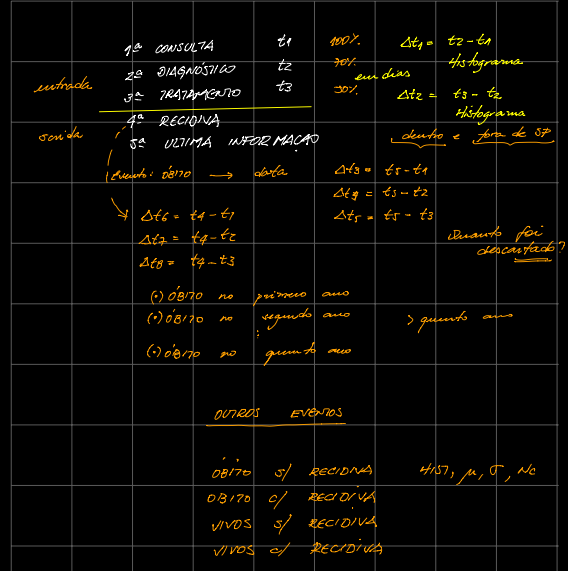

In [ ]:
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_preprocessing_dates.csv')
df.head()

(943660, 79)


,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,CIRURANT,RADIOANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,07/04/2000,8,A,A,J,J,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,20/01/2000,8,F,F,J,J,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
2,2,63.0,2,SP,3509502,9,2000-01-19,15,1,2000-01-25,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,03/02/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2001-03-20,3,6,15.0,9.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
3,9,64.0,2,SP,3545803,9,2000-01-28,15,1,2000-02-03,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,01/03/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2002-07-15,3,6,33.0,27.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
4,1,48.0,2,SP,3530805,9,2000-01-04,15,2,2000-01-04,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,15/05/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-03-10,2,0,132.0,132.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502


In [ ]:
# Dates - DTCONSULT, DTDIAG, DTTRAT, DTULTINFO, DTRECIDIVA
lista_datas = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA']
df[lista_datas].isna().sum()

DTCONSULT          0
DTDIAG             0
DTTRAT         74896
DTULTINFO         45
DTRECIDIVA    848760
dtype: int64

## **Date difference columns**

The differences between the dates of consultation, diagnosis and treatment will be calculated, and then the difference between the date of recurrence and last information and the first three.

This process will be performed by the function `get_dates_diff`, which drops the empty rows of the `DTTRAT` and `DTULTINFO` columns, converts the date columns to the datetime format and then calculates the difference between the dates in days. 

The idea is presented below.


> See the full function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General).

**Date columns**

* Consultation - $t_1$

* Diagnosis - $t_2$

* Treatment - $t_3$

* Recurrence - $t_4$

* Last information - $t_5$

---

**Difference, in days, between dates:**

$$\Delta t_1 = t_2 - t_1$$

$$\Delta t_2 = t_3 - t_2$$

$$\Delta t_3 = t_3 - t_1$$

**Recurrence:**

$$\Delta t_4 = t_4 - t_1$$

$$\Delta t_5 = t_4 - t_2$$

$$\Delta t_6 = t_4 - t_3$$

**Last information:**

$$\Delta t_7 = t_5 - t_1$$

$$\Delta t_8 = t_5 - t_2$$

$$\Delta t_9 = t_5 - t_3$$

In [ ]:
dates = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'CONSDIAG', 'DIAGTRAT', 'TRATCONS', 
         'DTULTINFO', 'DTRECIDIVA', 'delta_t1', 'delta_t2', 'delta_t3', 'delta_t4',
         'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9']

**SP - Dataset for São Paulo state**

In [ ]:
df_SP = df[df.UFRESID == 'SP'].copy()
print(df_SP.shape)
df_SP.head(3)

(872683, 79)


,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,CIRURANT,RADIOANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,07/04/2000,8,A,A,J,J,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,20/01/2000,8,F,F,J,J,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
2,2,63.0,2,SP,3509502,9,2000-01-19,15,1,2000-01-25,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,03/02/2000,8,B,B,J,J,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2001-03-20,3,6,15.0,9.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502


New columns with the dates difference

In [ ]:
df_SP = get_dates_diff(df_SP)
print(df_SP.shape)
df_SP[dates].head()

(806402, 88)


,DTCONSULT,DTDIAG,DTTRAT,CONSDIAG,DIAGTRAT,TRATCONS,DTULTINFO,DTRECIDIVA,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9
0,2000-01-03,2000-01-10,2000-04-07,7,88.0,95.0,2016-09-13,NaT,7,88,95,NaN,NaN,NaN,6098,6091,6003
1,2000-01-05,2000-01-17,2000-01-20,12,3.0,15.0,2002-08-25,NaT,12,3,15,NaN,NaN,NaN,963,951,948
2,2000-01-19,2000-01-25,2000-02-03,6,9.0,15.0,2001-03-20,NaT,6,9,15,NaN,NaN,NaN,426,420,411
3,2000-01-28,2000-02-03,2000-03-01,6,27.0,33.0,2002-07-15,NaT,6,27,33,NaN,NaN,NaN,899,893,866
4,2000-01-04,2000-01-04,2000-05-15,0,132.0,132.0,2016-03-10,NaT,0,132,132,NaN,NaN,NaN,5910,5910,5778


**Other states dataset**

In [ ]:
df_fora = df[df.UFRESID != 'SP'].copy()
print(df_fora.shape)
df_fora.head(3)

(70977, 79)


,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,CIRURANT,RADIOANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN
15,5,56.0,2,MG,3167400,9,2000-01-19,33,1,2000-01-26,3,C509,C50,85202,I,I,1,0,0,1,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,22/03/2000,8,D,D,J,J,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2018-01-24,2,7,63.0,56.0,2000,**Sem informação**,**Sem informação**,50-59,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
29,2,48.0,2,MG,3159605,9,2000-02-07,33,1,2000-03-09,3,C509,C50,80102,0,0,IS,0,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,06/04/2000,8,A,A,J,J,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-04-04,2,31,59.0,28.0,2000,**Sem informação**,**Sem informação**,40-49,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502
32,2,63.0,2,MG,3143401,9,2000-01-31,33,1,2000-02-09,2,C509,C50,80102,0,0,IS,0,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,22/03/2000,8,A,A,J,J,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2016-09-14,2,9,51.0,42.0,2000,**Sem informação**,**Sem informação**,60-69,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502


New columns with the dates difference

In [ ]:
df_fora = get_dates_diff(df_fora)
print(df_fora.shape)
df_fora[dates].head(3)

(62317, 88)


,DTCONSULT,DTDIAG,DTTRAT,CONSDIAG,DIAGTRAT,TRATCONS,DTULTINFO,DTRECIDIVA,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9
15,2000-01-19,2000-01-26,2000-03-22,7,56.0,63.0,2018-01-24,NaT,7,56,63,NaN,NaN,NaN,6580,6573,6517
29,2000-02-07,2000-03-09,2000-04-06,31,28.0,59.0,2016-04-04,NaT,31,28,59,NaN,NaN,NaN,5901,5870,5842
32,2000-01-31,2000-02-09,2000-03-22,9,42.0,51.0,2016-09-14,NaT,9,42,51,NaN,NaN,NaN,6071,6062,6020


## **Histogramas**

**SP**

In [ ]:
fig = px.histogram(df_SP, x="delta_t1", marginal='box',
                   title='Diferença de dias entre diagnóstico e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t2", marginal='box',
                   title='Diferença de dias entre tratamento e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t3", marginal='box', 
                   title='Diferença de dias entre tratamento e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t4", marginal='box',
                   title='Diferença de dias entre recidiva e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t5", marginal='box',
                   title='Diferença de dias entre recidiva e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t6", marginal='box', 
                   title='Diferença de dias entre recidiva e tratamento')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t7", marginal='box',
                   title='Diferença de dias entre última informação e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t8", marginal='box',
                   title='Diferença de dias entre última informação e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_SP, x="delta_t9", marginal='box', 
                   title='Diferença de dias entre última informação e tratamento')
fig.show(config = {'staticPlot': True})

**Other states**

In [ ]:
fig = px.histogram(df_fora, x="delta_t1", marginal='box',
                   title='Diferença de dias entre diagnóstico e consulta')

fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t2", marginal='box',
                   title='Diferença de dias entre tratamento e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t3", marginal='box', 
                   title='Diferença de dias entre tratamento e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t4", marginal='box',
                   title='Diferença de dias entre recidiva e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t5", marginal='box',
                   title='Diferença de dias entre recidiva e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t6", marginal='box', 
                   title='Diferença de dias entre recidiva e tratamento')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t7", marginal='box',
                   title='Diferença de dias entre última informação e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t8", marginal='box',
                   title='Diferença de dias entre última informação e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df_fora, x="delta_t9", marginal='box', 
                   title='Diferença de dias entre última informação e tratamento')
fig.show(config = {'staticPlot': True})

## **Creation of death label**

In this section, labels will be created based on the latest information, one column only if the person died or not (`ob`) and another with information on how many years after the diagnosis the person died (`ano_ob`). 

After creating the columns, the datasets will be saved in csv files, one for São Paulo and one for the other states.

> This process will be performed by the `get_labels` function, see the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General) to see the complete function.

**Death labels**

* Death at any time - ob

* Year of death based on year of diagnosis - ano_ob

    0 - Patient is alive;

    1 - Death in the first year;

    2 - Death in the second year;
   
    3 - Death in the third year;
   
    4 - Death in the fourth year;
   
    5 - Death in the fifth year;
   
    6 - Death over five years.

---

**Last information**

1 - Alive with cancer

2 - Alive, without other specifications

3 - Death by cancer

4 - Death by other causes


**SP**

In [ ]:
df_SP.head(2)

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,...,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-07,8,A,A,J,J,0,1,0,...,1,0,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaT,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,7,88,95,NaN,NaN,NaN,6098,6091,6003
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-01-20,8,F,F,J,J,0,0,1,...,1,0,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaT,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,12,3,15,NaN,NaN,NaN,963,951,948


In [ ]:
df_SP.ULTINFO.value_counts()

2    384562
3    216244
4    109434
1     96162
Name: ULTINFO, dtype: int64

In [ ]:
df_SP = get_labels(df_SP)

In [ ]:
columns = ['delta_t1', 'delta_t2', 'delta_t3', 'delta_t4', 'delta_t5', 'delta_t6',
           'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob']

df_SP[columns][df_SP.ob == 1].head(10)

,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob
1,12,3,15,NaN,NaN,NaN,963,951,948,1,3
2,6,9,15,NaN,NaN,NaN,426,420,411,1,2
3,6,27,33,NaN,NaN,NaN,899,893,866,1,3
5,7,14,21,347.0,340.0,326.0,488,481,467,1,2
11,7,5,12,1498.0,1491.0,1486.0,2939,2932,2927,1,6
13,0,28,28,NaN,NaN,NaN,4377,4377,4349,1,6
14,3,70,73,619.0,616.0,546.0,1061,1058,988,1,3
16,0,56,56,556.0,556.0,500.0,898,898,842,1,3
17,0,34,34,1873.0,1873.0,1839.0,1985,1985,1951,1,6
18,27,21,48,NaN,NaN,NaN,837,810,789,1,3


In [ ]:
save_csv(df_SP, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')

CSV file saved successfully!


**Other states**

In [ ]:
df_fora.ULTINFO.value_counts()

2    37045
3    12820
1     7546
4     4906
Name: ULTINFO, dtype: int64

In [ ]:
df_fora = get_labels(df_fora)

In [ ]:
columns = ['delta_t1', 'delta_t2', 'delta_t3', 'delta_t4', 'delta_t5', 'delta_t6',
           'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob']

df_fora[columns][df_fora.ob == 1].head(10)

,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob
41,13,50,63,2077.0,2064.0,2014.0,2573,2560,2510,1,6
53,29,0,29,NaN,NaN,NaN,4661,4632,4632,1,6
68,0,63,63,NaN,NaN,NaN,1068,1068,1005,1,3
79,0,64,64,NaN,NaN,NaN,639,639,575,1,2
83,7,26,33,NaN,NaN,NaN,969,962,936,1,3
87,0,102,102,NaN,NaN,NaN,197,197,95,1,1
97,0,34,34,NaN,NaN,NaN,3725,3725,3691,1,6
104,51,0,51,73.0,22.0,22.0,1252,1201,1201,1,4
116,79,0,79,NaN,NaN,NaN,518,439,439,1,2
127,0,125,125,NaN,NaN,NaN,4658,4658,4533,1,6


In [ ]:
save_csv(df_fora, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

CSV file saved successfully!


## **Creation of recurrence labels**

In this section, labels will be created based on the recurrence, two columns for people who died, one without recurrence and one with recurrence, and two for people who are alive, also one without recurrence and one with recurrence. 

After creating the columns, the datasets will be saved in csv files, one for São Paulo and one for the other states, now both datasets have 94 columns. 

> This process will be performed by the `get_labels_rec` function, see the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General) to see the complete function.

**Recurrence labels**

* Death without recurrence - ob_sem_rec

* Death with recurrence - ob_com_rec

* Alive without recurrence - vivo_sem_rec

* Alive with recurrence - vivo_com_rec

---

**Last information**

1 - Alive with cancer

2 - Alive, without other specifications

3 - Death by cancer

4 - Death by other causes


In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 90)
(62317, 90)


**SP**

In [ ]:
df_SP.head(2)

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,...,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-07,8,A,A,J,J,0,1,0,...,0,0,0,0,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,7,88,95,NaN,NaN,NaN,6098,6091,6003,0,0
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-01-20,8,F,F,J,J,0,0,1,...,0,0,0,0,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,12,3,15,NaN,NaN,NaN,963,951,948,1,3


In [ ]:
df_SP = get_label_rec(df_SP)

In [ ]:
columns = ['RECNENHUM', 'ob', 'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec']
df_SP[columns].head()

,RECNENHUM,ob,ob_com_rec,ob_sem_rec,vivo_com_rec,vivo_sem_rec
0,1,0,0,0,0,1
1,1,1,0,1,0,0
2,1,1,0,1,0,0
3,1,1,0,1,0,0
4,1,0,0,0,0,1


In [ ]:
save_csv(df_SP, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')

CSV file saved successfully!


**Other states**

In [ ]:
df_fora.head(2)

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,...,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob
0,5,56.0,2,MG,3167400,9,2000-01-19,33,1,2000-01-26,3,C509,C50,85202,I,I,1,0,0,1,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-03-22,8,D,D,J,J,0,1,1,...,0,0,0,0,0,0,2018-01-24,2,7,63.0,56.0,2000,**Sem informação**,**Sem informação**,50-59,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,7,56,63,NaN,NaN,NaN,6580,6573,6517,0,0
1,2,48.0,2,MG,3159605,9,2000-02-07,33,1,2000-03-09,3,C509,C50,80102,0,0,IS,0,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-06,8,A,A,J,J,0,1,0,...,0,0,0,0,0,0,2016-04-04,2,31,59.0,28.0,2000,**Sem informação**,**Sem informação**,40-49,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,31,28,59,NaN,NaN,NaN,5901,5870,5842,0,0


In [ ]:
df_fora = get_label_rec(df_fora)

In [ ]:
columns = ['RECNENHUM', 'ob', 'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec']
df_fora[columns].head()

,RECNENHUM,ob,ob_com_rec,ob_sem_rec,vivo_com_rec,vivo_sem_rec
0,1,0,0,0,0,1
1,1,0,0,0,0,1
2,1,0,0,0,0,1
3,0,1,1,0,0,0
4,1,1,0,1,0,0


In [ ]:
save_csv(df_fora, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

CSV file saved successfully!


## **Verificação dos dados criados**

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
df_SP.head()

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,...,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob,ob_com_rec,ob_sem_rec,vivo_com_rec,vivo_sem_rec
0,4,40.0,2,SP,3530805,9,2000-01-03,15,1,2000-01-10,3,C539,C53,81402,0,0,X,X,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-07,8,A,A,J,J,0,1,0,...,0,0,2016-09-13,2,7,95.0,88.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,7,88,95,NaN,NaN,NaN,6098,6091,6003,0,0,0,0,0,1
1,9,45.0,2,SP,3509502,9,2000-01-05,15,1,2000-01-17,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-01-20,8,F,F,J,J,0,0,1,...,0,0,2002-08-25,3,12,15.0,3.0,2000,**Sem informação**,**Sem informação**,40-49,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,12,3,15,NaN,NaN,NaN,963,951,948,1,3,0,1,0,0
2,2,63.0,2,SP,3509502,9,2000-01-19,15,1,2000-01-25,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-02-03,8,B,B,J,J,0,0,1,...,0,0,2001-03-20,3,6,15.0,9.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,6,9,15,NaN,NaN,NaN,426,420,411,1,2,0,1,0,0
3,9,64.0,2,SP,3545803,9,2000-01-28,15,1,2000-02-03,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-03-01,8,B,B,J,J,0,0,1,...,0,0,2002-07-15,3,6,33.0,27.0,2000,**Sem informação**,**Sem informação**,60-69,8,7,15,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,6,27,33,NaN,NaN,NaN,899,893,866,1,3,0,1,0,0
4,1,48.0,2,SP,3530805,9,2000-01-04,15,2,2000-01-04,3,C539,C53,80703,IIIB,III,X,X,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-05-15,8,B,B,J,J,0,0,1,...,0,0,2016-03-10,2,0,132.0,132.0,2000,**Sem informação**,**Sem informação**,40-49,8,14,15,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,0,132,132,NaN,NaN,NaN,5910,5910,5778,0,0,0,0,0,1


In [ ]:
df_fora.head()

,ESCOLARI,IDADE,SEXO,UFRESID,IBGE,CATEATEND,DTCONSULT,CLINICA,DIAGPREV,DTDIAG,BASEDIAG,TOPO,TOPOGRUP,MORFO,EC,ECGRUP,T,N,M,PT,PN,PM,G,LOCALTNM,IDMITOTIC,PSA,GLEASON,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFANTES,TRATFAPOS,NENHUM,CIRURGIA,RADIO,...,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,CICI,CICIGRUP,FAIXAETAR,LATERALI,DRS,RRAS,PERDASEG,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,delta_t1,delta_t2,delta_t3,delta_t4,delta_t5,delta_t6,delta_t7,delta_t8,delta_t9,ob,ano_ob,ob_com_rec,ob_sem_rec,vivo_com_rec,vivo_sem_rec
0,5,56.0,2,MG,3167400,9,2000-01-19,33,1,2000-01-26,3,C509,C50,85202,I,I,1,0,0,1,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-03-22,8,D,D,J,J,0,1,1,...,0,0,2018-01-24,2,7,63.0,56.0,2000,**Sem informação**,**Sem informação**,50-59,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,7,56,63,NaN,NaN,NaN,6580,6573,6517,0,0,0,0,0,1
1,2,48.0,2,MG,3159605,9,2000-02-07,33,1,2000-03-09,3,C509,C50,80102,0,0,IS,0,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-06,8,A,A,J,J,0,1,0,...,0,0,2016-04-04,2,31,59.0,28.0,2000,**Sem informação**,**Sem informação**,40-49,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,31,28,59,NaN,NaN,NaN,5901,5870,5842,0,0,0,0,0,1
2,2,63.0,2,MG,3143401,9,2000-01-31,33,1,2000-02-09,2,C509,C50,80102,0,0,IS,0,0,IS,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-03-22,8,A,A,J,J,0,1,0,...,0,0,2016-09-14,2,9,51.0,42.0,2000,**Sem informação**,**Sem informação**,60-69,8,0,99,1,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,9,42,51,NaN,NaN,NaN,6071,6062,6020,0,0,0,0,0,1
3,2,52.0,2,MG,3108305,9,2000-01-19,33,1,2000-02-01,3,C509,C50,85003,IIA,II,2,0,0,1,0,0,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-03-22,8,G,G,J,J,0,1,1,...,0,0,2007-02-04,4,13,63.0,50.0,2000,**Sem informação**,**Sem informação**,50-59,8,0,99,0,2005-09-26,0,0,1,0,C71,C22,**Sem informação**,**Sem informação**,3509502,13,50,63,2077.0,2064.0,2014.0,2573,2560,2510,1,6,1,0,0,0
4,9,52.0,2,MG,3113602,2,2000-03-28,33,1,2000-04-26,3,C509,C50,85003,IIA,II,2,0,0,X,X,X,8,8,8,8,8,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,2000-04-26,8,F,F,J,J,0,0,1,...,0,0,2012-12-31,4,29,29.0,0.0,2000,**Sem informação**,**Sem informação**,50-59,8,0,99,0,NaN,1,0,0,0,**Sem informação**,**Sem informação**,**Sem informação**,**Sem informação**,3509502,29,0,29,NaN,NaN,NaN,4661,4632,4632,1,6,0,1,0,0


### **Features das datas**

* Consulta - $t_1$

* Diagnóstico - $t_2$

* Tratamento - $t_3$

* Recidiva - $t_4$

* Última informação - $t_5$
---
**Diferenças, em dias, entre as datas:**

$$\Delta t_1 = t_2 - t_1$$

$$\Delta t_2 = t_3 - t_2$$

$$\Delta t_3 = t_3 - t_1$$

**Recidiva:**

$$\Delta t_4 = t_4 - t_1$$

$$\Delta t_5 = t_4 - t_2$$

$$\Delta t_6 = t_4 - t_3$$

**Última informação:**

$$\Delta t_7 = t_5 - t_1$$

$$\Delta t_8 = t_5 - t_2$$

$$\Delta t_9 = t_5 - t_3$$

**SP**

In [ ]:
# Diagnóstico antes da consulta
df_SP[df_SP.delta_t1 < 0].shape

(252771, 94)

In [ ]:
# Tratamento antes do diagnóstico
df_SP[df_SP.delta_t2 < 0].shape

(0, 94)

In [ ]:
# Tratamento antes da consulta
df_SP[df_SP.delta_t3 < 0].shape

(0, 94)

In [ ]:
# Recidiva antes da consulta
df_SP[df_SP.delta_t4 < 0].shape

(609, 94)

In [ ]:
df_SP.delta_t4.isna().sum()

717377

In [ ]:
# Recidiva antes do diagnóstico
df_SP[df_SP.delta_t5 < 0].shape

(124, 94)

In [ ]:
df_SP.delta_t5.isna().sum()

717377

In [ ]:
# Recidiva antes do tratamento
df_SP[df_SP.delta_t6 < 0].shape

(2159, 94)

In [ ]:
df_SP.delta_t6.isna().sum()

717377

In [ ]:
# Última informação antes da consulta
df_SP[df_SP.delta_t7 < 0].shape

(20, 94)

In [ ]:
# # Última informação antes do diagnóstico
df_SP[df_SP.delta_t8 < 0].shape

(15, 94)

In [ ]:
# Última informação antes do tratamento
df_SP[df_SP.delta_t9 < 0].shape

(468, 94)

**Other states**

In [ ]:
# Diagnóstico antes da consulta
df_fora[df_fora.delta_t1 < 0].shape

(24578, 94)

In [ ]:
# Tratamento antes do diagnóstico
df_fora[df_fora.delta_t2 < 0].shape

(0, 94)

In [ ]:
# Tratamento antes da consulta
df_fora[df_fora.delta_t3 < 0].shape

(0, 94)

In [ ]:
# Recidiva antes da consulta
df_fora[df_fora.delta_t4 < 0].shape

(12, 94)

In [ ]:
df_fora.delta_t4.isna().sum()

57799

In [ ]:
# Recidiva antes do diagnóstico
df_fora[df_fora.delta_t5 < 0].shape

(4, 94)

In [ ]:
df_fora.delta_t5.isna().sum()

57799

In [ ]:
# Recidiva antes do tratamento
df_fora[df_fora.delta_t6 < 0].shape

(62, 94)

In [ ]:
df_fora.delta_t6.isna().sum()

57799

In [ ]:
# Última informação antes da consulta
df_fora[df_fora.delta_t7 < 0].shape

(2, 94)

In [ ]:
# Última informação antes do diagnóstico
df_fora[df_fora.delta_t8 < 0].shape

(3, 94)

In [ ]:
# Última informação antes do tratamento
df_fora[df_fora.delta_t9 < 0].shape

(169, 94)

### **Labels óbito**
* Óbito em qualquer momento - ob

* Ano do óbito em relação a data do diagnóstico - ano_ob

   * 0 - Paciente está vivo;
   * 1 - Óbito no primeiro ano;
   * 2 - Óbito no segundo ano;
   * 3 - Óbito no terceiro ano;
   * 4 - Óbito no quarto ano;
   * 5 - Óbito no quinto ano;
   * 6 - Óbito com mais de 5 ano;


**SP**

In [ ]:
df_SP.ob.value_counts()

0    480724
1    325678
Name: ob, dtype: int64

In [ ]:
df_SP.ano_ob.value_counts()

0    480724
1    121819
2     67264
6     56871
3     37305
4     24567
5     17852
Name: ano_ob, dtype: int64

**Other states**

In [ ]:
df_fora.ob.value_counts()

0    44591
1    17726
Name: ob, dtype: int64

In [ ]:
df_fora.ano_ob.value_counts()

0    44591
1     7294
2     3986
6     2230
3     2048
4     1300
5      868
Name: ano_ob, dtype: int64

### **Labels recidiva**
* Óbito sem recidiva - ob_sem_rec

* Óbito com recidiva - ob_com_rec

* Vivos sem recidiva - vivo_sem_rec

* Vivos com recidiva - vivo_com_rec
---


**SP**

In [ ]:
df_SP.ob_sem_rec.value_counts()

0    532957
1    273445
Name: ob_sem_rec, dtype: int64

In [ ]:
df_SP.ob_com_rec.value_counts()

0    754169
1     52233
Name: ob_com_rec, dtype: int64

In [ ]:
df_SP.vivo_sem_rec.value_counts()

1    459188
0    347214
Name: vivo_sem_rec, dtype: int64

In [ ]:
df_SP.vivo_com_rec.value_counts()

0    784866
1     21536
Name: vivo_com_rec, dtype: int64

**Fora de SP**

In [ ]:
df_fora.ob_sem_rec.value_counts()

0    46419
1    15898
Name: ob_sem_rec, dtype: int64

In [ ]:
df_fora.ob_com_rec.value_counts()

0    60489
1     1828
Name: ob_com_rec, dtype: int64

In [ ]:
df_fora.vivo_sem_rec.value_counts()

1    43239
0    19078
Name: vivo_sem_rec, dtype: int64

In [ ]:
df_fora.vivo_com_rec.value_counts()

0    60965
1     1352
Name: vivo_com_rec, dtype: int64

# **Classification - ob**

In this section, two machine learning models will be used to classify the `ob` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['ob']).sort_values(ascending = False).head(20)

ob              1.000000
vivo_sem_rec    0.946549
ob_sem_rec      0.870247
ULTINFO         0.868236
ano_ob          0.750408
PERDASEG        0.378763
ob_com_rec      0.319736
ANODIAG         0.269601
CIRURGIA        0.249248
QUIMIO          0.244519
delta_t7        0.216269
delta_t8        0.216105
delta_t9        0.212633
CATEATEND       0.212081
RECNENHUM       0.196724
delta_t5        0.169360
delta_t4        0.167767
delta_t6        0.160751
RECREGIO        0.141924
IDADE           0.136383
Name: ob, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['ob']).sort_values(ascending = False).head(20)

ob              1.000000
vivo_sem_rec    0.949190
ob_sem_rec      0.928200
ULTINFO         0.854305
ano_ob          0.772548
PERDASEG        0.359090
ob_com_rec      0.275720
CIRURGIA        0.257715
QUIMIO          0.253681
ANODIAG         0.252079
CATEATEND       0.209850
delta_t5        0.168003
delta_t8        0.167875
delta_t4        0.166380
delta_t7        0.165922
delta_t9        0.164855
delta_t6        0.163108
RECNENHUM       0.149262
RADIO           0.139862
GLEASON         0.104262
Name: ob, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.ob.value_counts()

0    480724
1    325678
Name: ob, dtype: int64

In [ ]:
df_fora.ob.value_counts()

0    44591
1    17726
Name: ob, dtype: int64

A curiosity is in the column `PERDASEG`, because when its value is 1, in other words, treatment is not being followed up anymore, the label is always 0 (only one is different), indicating that the patient did not die. For this detail, this column will also not be used as a feature, because the model will be able to adjust many values of the label just using this column.

In [ ]:
df_SP['ob'][df_SP.PERDASEG == 1].value_counts()

0    140925
1         1
Name: ob, dtype: int64

In [ ]:
df_fora['ob'][df_fora.PERDASEG == 1].value_counts()

0    15263
Name: ob, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, it is necessary to define the columns that will be used as features and the label. For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ano_ob',
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

lb = 'ob'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP, list_drop, lb)

X_train = (604801, 70), X_test = (201601, 70)
y_train = (604801,), y_test = (201601,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 70), X_test = (15580, 70)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to perform the preprocessing in the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be the representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

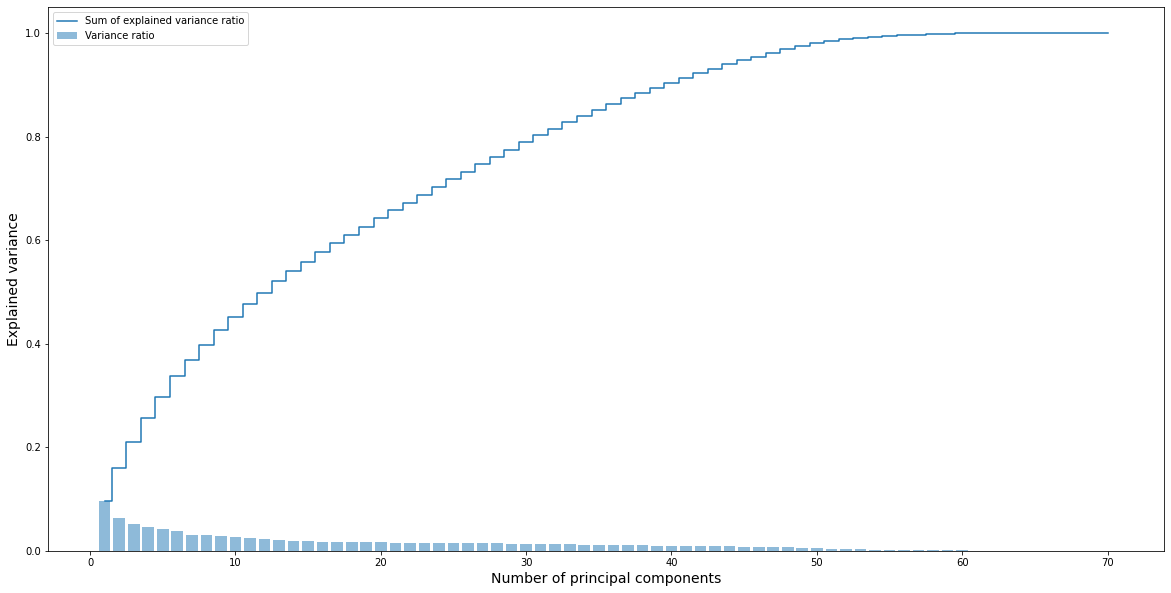

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, 70, 70), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='Variance ratio')
plt.step(np.linspace(1, 70, 70), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, 70, 70),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, 70, 70),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

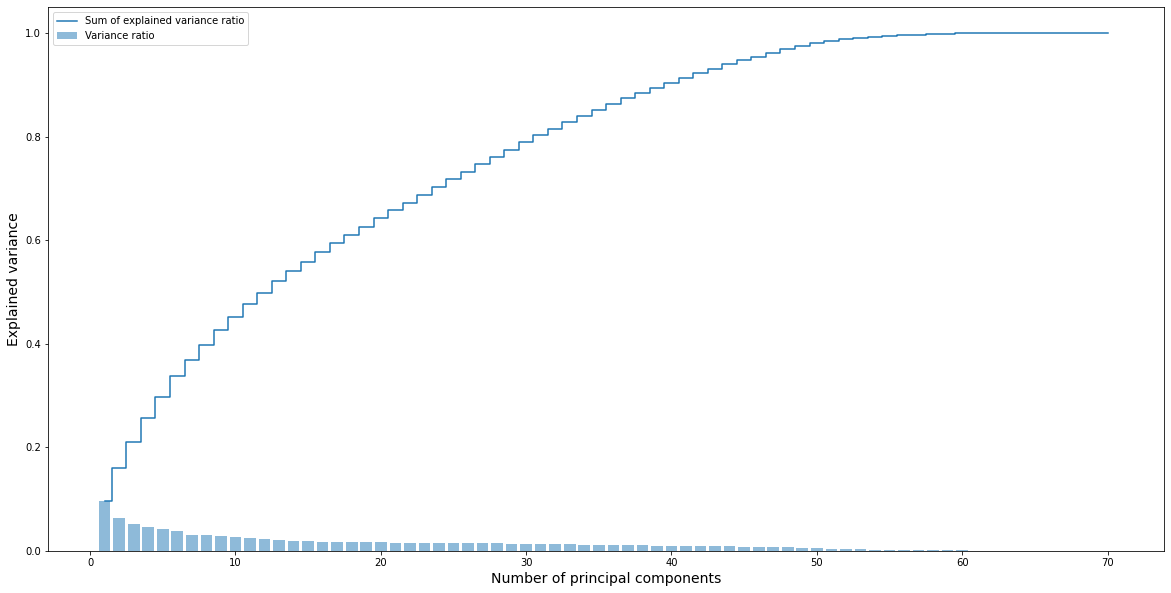

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, 70, 70), pca.explained_variance_ratio_, alpha=0.5, 
        align='center', label='Variance ratio')
plt.step(np.linspace(1, 70, 70), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, 70, 70),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, 70, 70),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 0 than with value 1. Therefore, we will use methods to balance the data.

In the case of the SP dataset, an undersampling will be used, which balances the data according to the number of values of the smallest label, in case `ob = 1`. For the dataset with data from other states, the oversampling method will be used, which creates new data for the label with less values (`ob = 1`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

0    360572
1    244229
Name: ob, dtype: int64

In [ ]:
rus = RandomUnderSampler(random_state=seed)
X_SP, y_SP = rus.fit_sample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(488458,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

0    33365
1    13372
Name: ob, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(66730,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test only the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

In the model for data outside the SP, the hyperparameter `class_weight` was also used, because even after balancing the data the model still has difficulty learning the class with fewer examples, this will be easier to understand when we check the confusion matrix for this model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed)
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, class_weight={0: 10, 1: 0.0001})
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 10, 1: 0.0001}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight = 10`, for the model with data from outside SP.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15, random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=15, scale_pos_weight=10, 
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Salvando modelos**

In [ ]:
#with open('/content/drive/MyDrive/Trabalho/Cancer/Modelos/models_SP.pkl', 'wb') as arq:
    #pickle.dump(
        #{'X_train': X_SP, 'y_train': y_SP, 'Encoders': enc_SP, 
         #'Normalizer': norm_SP, 'Random Forest': rf_sp, 'XGB': xgboost_sp}, arq)

In [ ]:
#with open('/content/drive/MyDrive/Trabalho/Cancer/Modelos/models_foraSP.pkl', 'wb') as arq:
    #pickle.dump(
        #{'X_train': X_fora, 'y_train': y_fora, 'Encoders': enc_fora, 
         #'Normalizer': norm_fora, 'Random Forest': rf_fora, 'XGB': xgboost_fora}, arq)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

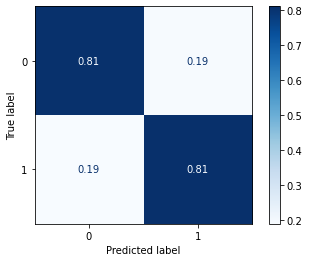

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because the model gets 81% correct for both classes, `ob = 0` and `ob = 1`.

> It is also noticed that the balance of the data worked, because it was not necessary to use a higher weight for the class with fewer examples in the training of the model and we obtained a confusion matrix with the balanced main diagonal.

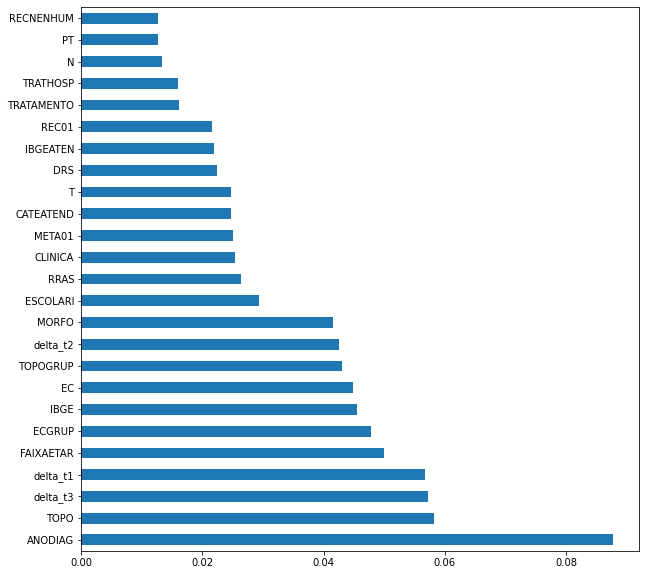

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `TOPO`, `delta_t3` and `delta_t1`, the last two being the difference, in days, between treatment and consultation and between diagnosis and consultation, respectively.

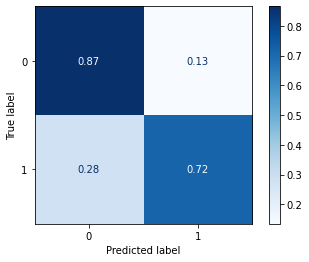

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, but we have a unbalanced main diagonal in the confusion matrix, it means that we have to adjust the class weights in the model training, in order to obtain a balanced diagonal.


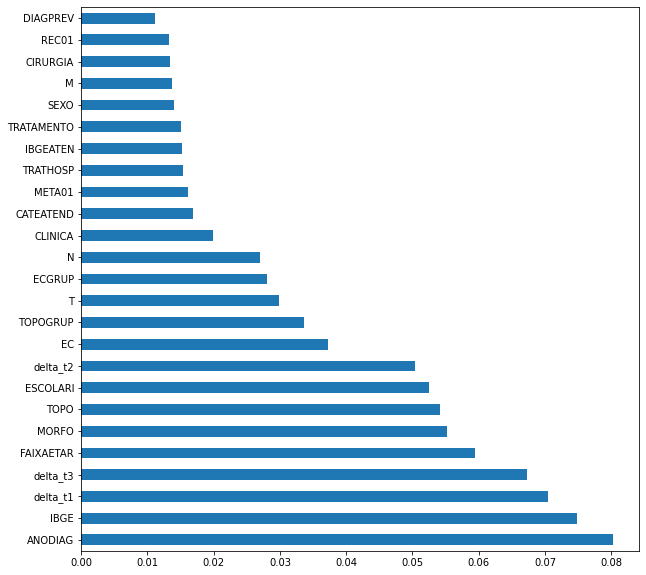

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `IBGE`, `delta_t1` and `delta_t3`, the last two being the difference, in days, between diagnosis and consultation and between treatment and consultation, respectively.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

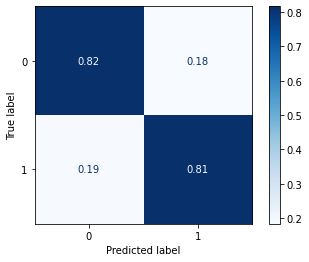

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, as well as the Random Forest model.

> We also noticed that the balance of the data worked, because it was not necessary to use a higher weight for the class with fewer examples and we obtained a confusion matrix with the balanced main diagonal.

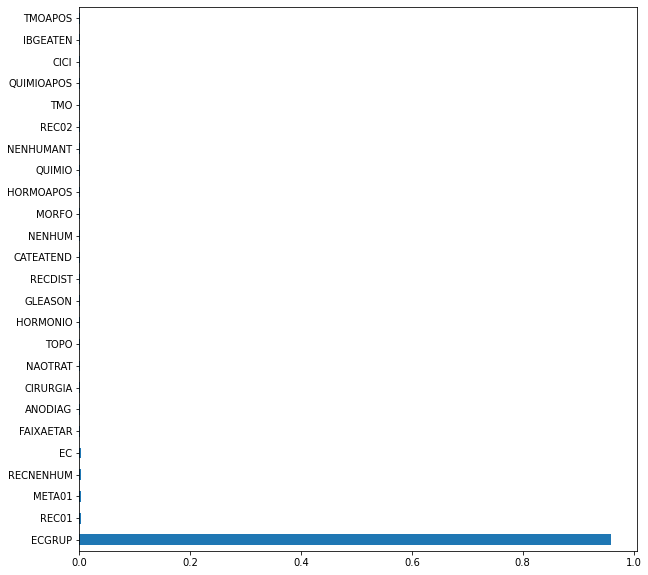

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others.

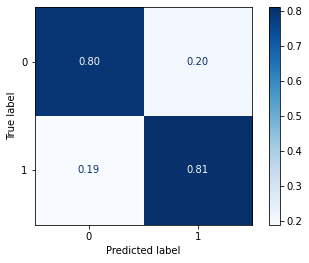

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, as well as the Random Forest model.

> We also obtained a confusion matrix with the balanced main diagonal, with 80% and 81%.

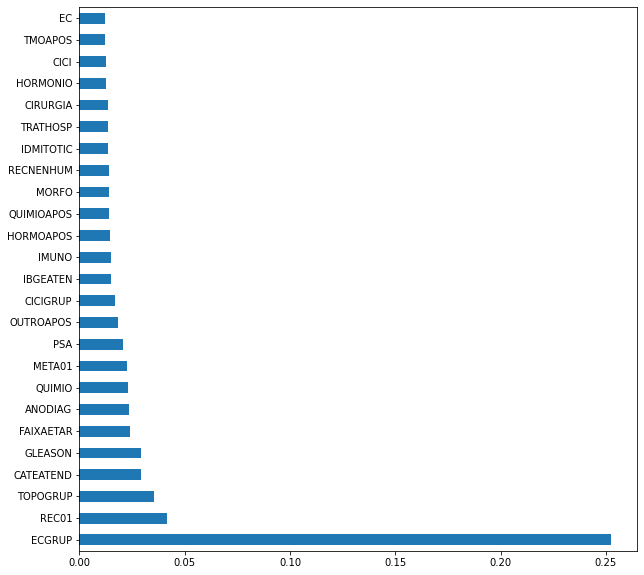

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage as seen in the previous analysis. The following most important features were `REC01`, `TOPOGRUP` and `CATEATEND`.

# **Classification - RECNENHUM**

In this section, two machine learning models will be used to classify the `RECNENHUM` column, Random Forest and XGBoost.

The label is 0 if there was a recurrence and 1 if there wasn't.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
corr_matrix = df_SP.corr()
abs(corr_matrix['RECNENHUM']).sort_values(ascending = False).head(20)

RECNENHUM       1.000000
ob_com_rec      0.829363
RECLOCAL        0.679652
RECREGIO        0.529338
vivo_com_rec    0.522025
RECDIST         0.497837
vivo_sem_rec    0.364914
ano_ob          0.242833
ob_sem_rec      0.227291
ob              0.196724
QUIMIO          0.147652
RADIO           0.085910
ULTINFO         0.081964
PERDASEG        0.070304
delta_t8        0.064934
delta_t7        0.063559
delta_t9        0.063466
IBGEATEN        0.062526
delta_t5        0.058940
delta_t4        0.055412
Name: RECNENHUM, dtype: float64

In [ ]:
corr_matrix = df_fora.corr()
abs(corr_matrix['RECNENHUM']).sort_values(ascending = False).head(20)

RECNENHUM       1.000000
ob_com_rec      0.749663
RECLOCAL        0.695533
vivo_com_rec    0.642191
RECDIST         0.579667
RECREGIO        0.430531
vivo_sem_rec    0.349104
ano_ob          0.217344
ob              0.149262
ob_sem_rec      0.135709
QUIMIO          0.130924
delta_t8        0.104972
delta_t9        0.103801
delta_t7        0.103667
delta_t5        0.087167
delta_t4        0.082168
delta_t6        0.081259
IDADE           0.074725
RADIO           0.074704
DIAGPREV        0.062018
Name: RECNENHUM, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, even higher than in the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.RECNENHUM.value_counts()

1    732633
0     73769
Name: RECNENHUM, dtype: int64

In [ ]:
df_fora.RECNENHUM.value_counts()

1    59137
0     3180
Name: RECNENHUM, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, 400 thousand examples will be selected from label 1, of more than 700 thousand that we have available, and then this subset will be concatenated with the one containing label 0. Thus, oversampling and training of the models will take less time.

In [ ]:
n_samples = 400000
df_SP_rec = df_SP[df_SP.RECNENHUM == 1].sample(n_samples, random_state=seed).sort_index()
df_SP_sem_rec = df_SP[df_SP.RECNENHUM == 0]
df_SP_menor = pd.concat([df_SP_rec, df_SP_sem_rec]).sort_index()
df_SP_menor.RECNENHUM.value_counts()

1    400000
0     73769
Name: RECNENHUM, dtype: int64

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. As the label is related to the patients' recurrence, the information related to this will be removed from the features, `RECLOCAL, RECREGIO, RECDIST, REC01, REC02, REC03, REC04`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RECLOCAL',
             'RECREGIO', 'RECDIST', 'REC01', 'REC02', 'REC03', 'REC04', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

label = 'RECNENHUM'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP_menor, list_drop, label)

X_train = (355326, 62), X_test = (118443, 62)
y_train = (355326,), y_test = (118443,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, label)

X_train = (46737, 62), X_test = (15580, 62)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

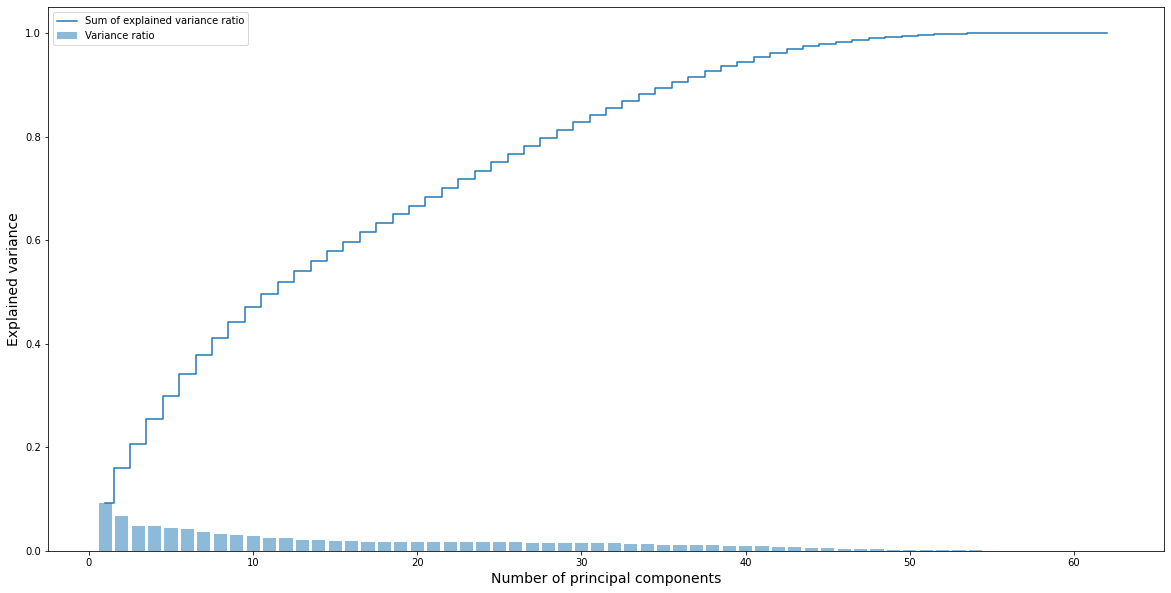

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

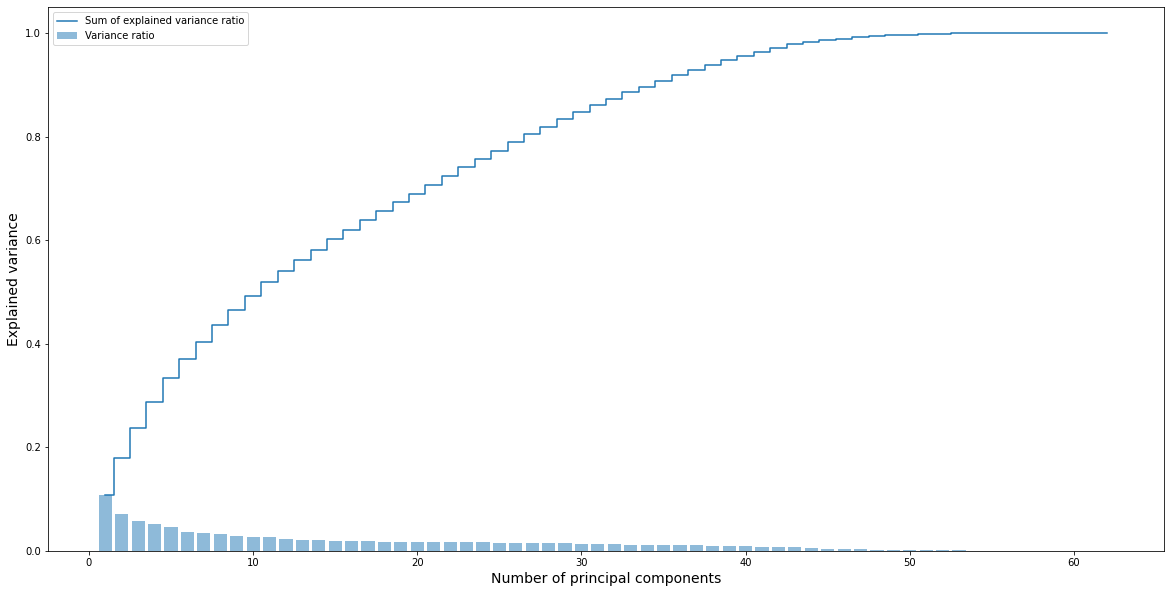

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 1 than with value 0. Therefore, we will use methods to balance the data.

In both datasets an oversampling will be used, which creates new data for the label with less values (`RECNENHUM = 0`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

1    300057
0     55269
Name: RECNENHUM, dtype: int64

In [ ]:
X_SP, y_SP = SMOTE(random_state=seed).fit_resample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(600114,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

1    44367
0     2370
Name: RECNENHUM, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(88734,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0: 19, 1: 0.00006})
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 19, 1: 6e-05}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0: 24, 1: 0.000022})
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 24, 1: 2.2e-05}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A smaller weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.15,
                               random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.15, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.02, # 0.05 - 0.01
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.02, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

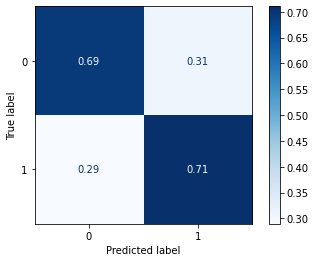

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a confusion matrix with the balanced main diagonal.

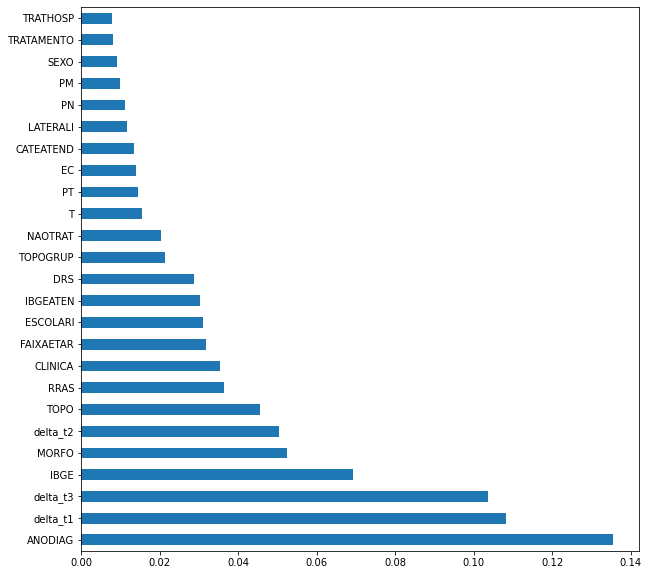

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `delta_t1`, `delta_t3` and `IBGE`. `delta_t1` is the difference, in days, between diagnosis and consultation and `delta_t3` is the differnce between treatment and consultation.

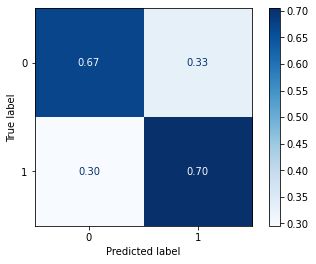

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, we have a more balanced main diagonal in the confusion matrix, with almost 70% of accuracy for both classes.

> The performance was worse in relation to the first classifiers because we removed more features in this case, representing a loss in the accuracy of the models.


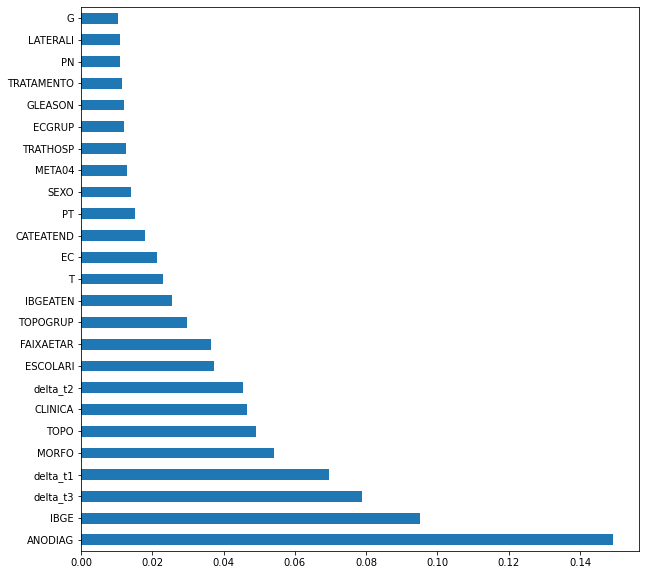

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `IBGE`, `delta_t3` and `delta_t1`, the last two being the difference, in days, between  treatment and consultation and between diagnosis and consultation, respectively.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

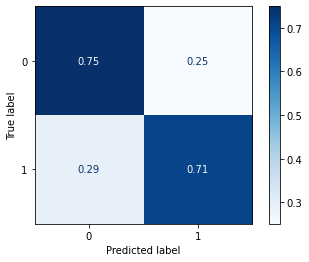

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, even better than the Random Forest model.

> We also obtained a confusion matrix with the balanced main diagonal, it is possible to refine the class weight to obtain a better balance.

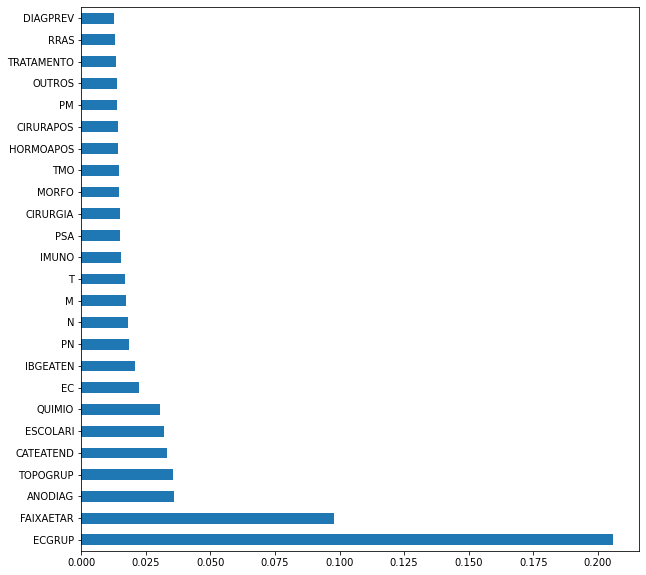

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage as seen in the previous analysis. The following most important features were `FAIXAETAR`, `ANODIAG` and `TOPOGRUP`.

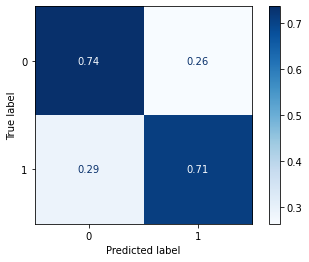

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, even better than the Random Forest model too. It is possible to refine the class weight to obtain a better balance in the main diagonal.

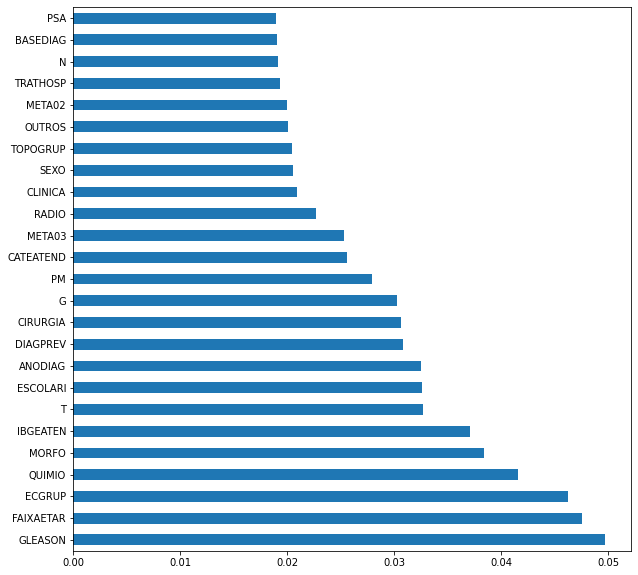

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> The four most important features in the model were `GLEASON`, `FAIXAETAR`, `ECGRUP`, and `QUIMIO`.

# **Classification - RECDIST**

In this section, two machine learning models will be used to classify the `RECDIST` column, Random Forest and XGBoost.

The label is 0 if there was no distant recurrence and 1 if there was.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
corr_matrix = df_SP.corr()
abs(corr_matrix['RECDIST']).sort_values(ascending = False).head(20)

RECDIST         1.000000
RECNENHUM       0.497837
ob_com_rec      0.427203
vivo_com_rec    0.238029
vivo_sem_rec    0.181668
ano_ob          0.119045
ob_sem_rec      0.113154
QUIMIO          0.109437
ob              0.105117
CATEATEND       0.093630
ANODIAG         0.084918
LATERALI        0.081624
RECLOCAL        0.058266
PERDASEG        0.055281
HORMONIO        0.045904
RRAS            0.043732
IBGEATEN        0.043044
RADIO           0.041206
delta_t5        0.040047
RADIOAPOS       0.038809
Name: RECDIST, dtype: float64

In [ ]:
corr_matrix = df_fora.corr()
abs(corr_matrix['RECDIST']).sort_values(ascending = False).head(20)

RECDIST         1.000000
RECNENHUM       0.579667
ob_com_rec      0.459205
vivo_com_rec    0.343707
vivo_sem_rec    0.202364
ano_ob          0.120521
QUIMIO          0.107406
ob              0.095742
CATEATEND       0.087712
ob_sem_rec      0.078666
LATERALI        0.073880
DIAGPREV        0.071119
ANODIAG         0.067613
RADIO           0.062403
RECLOCAL        0.050995
PERDASEG        0.047730
HORMONIO        0.046865
delta_t5        0.030107
DIAGTRAT        0.027065
delta_t2        0.027065
Name: RECDIST, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.RECDIST.value_counts()

0    786768
1     19634
Name: RECDIST, dtype: int64

In [ ]:
df_fora.RECDIST.value_counts()

0    61211
1     1106
Name: RECDIST, dtype: int64

## **Training and testing split**

Now we are going to divide the data into training and testing, to perform the training of the models and then their evaluation.

First, as we did in the last classification, 400 thousand examples will be selected from label 0, of almost 800 thousand that we have available, and then this subset will be concatenated with the one containing label 1. Thus, oversampling and training of the models will take less time.

In [ ]:
n_samples = 400000
df_SP_sem_rec = df_SP[df_SP.RECDIST == 0].sample(n_samples, random_state=seed).sort_index()
df_SP_rec = df_SP[df_SP.RECDIST == 1]
df_SP_menor = pd.concat([df_SP_rec, df_SP_sem_rec]).sort_index()
df_SP_menor.RECDIST.value_counts()

0    400000
1     19634
Name: RECDIST, dtype: int64

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the previous section.

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. As the label is related to the patients' recurrence, the information related to this will be removed from the features, `RECNENHUM, RECLOCAL, RECREGIO, REC01, REC02, REC03, REC04`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'RECNENHUM',
             'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'REC04', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

lb = 'RECDIST'

A function was created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP_menor, list_drop, lb)

X_train = (314725, 62), X_test = (104909, 62)
y_train = (314725,), y_test = (104909,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 62), X_test = (15580, 62)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this a function was created, `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **PCA**

Using the PCA, it is possible to reduce the dimensionality of the data, decreasing the number of features. As can be seen from the graphs below, with less features used in the models, smaller will be representativeness of the total data.

The preprocessing function of the training data already contains this possibility of using the PCA, just use the necessary parameters, see the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainSP_enc)

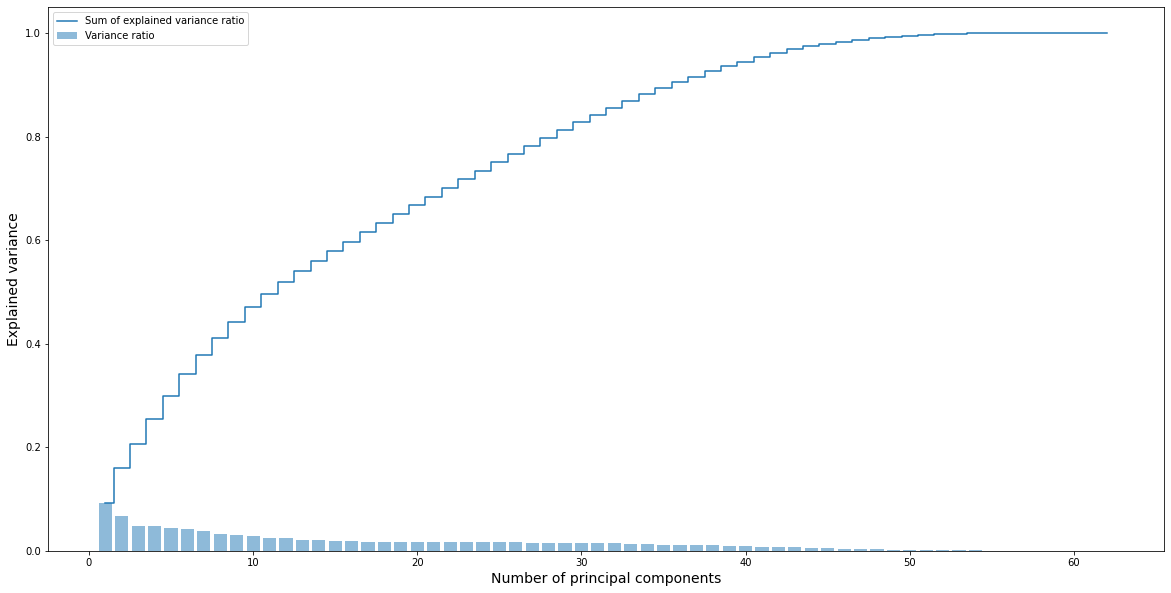

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, X_trainSP_enc.shape[1], X_trainSP_enc.shape[1]),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

**Other states**

In [ ]:
pca = PCA()
principalComponents = pca.fit_transform(X_trainFora_enc)

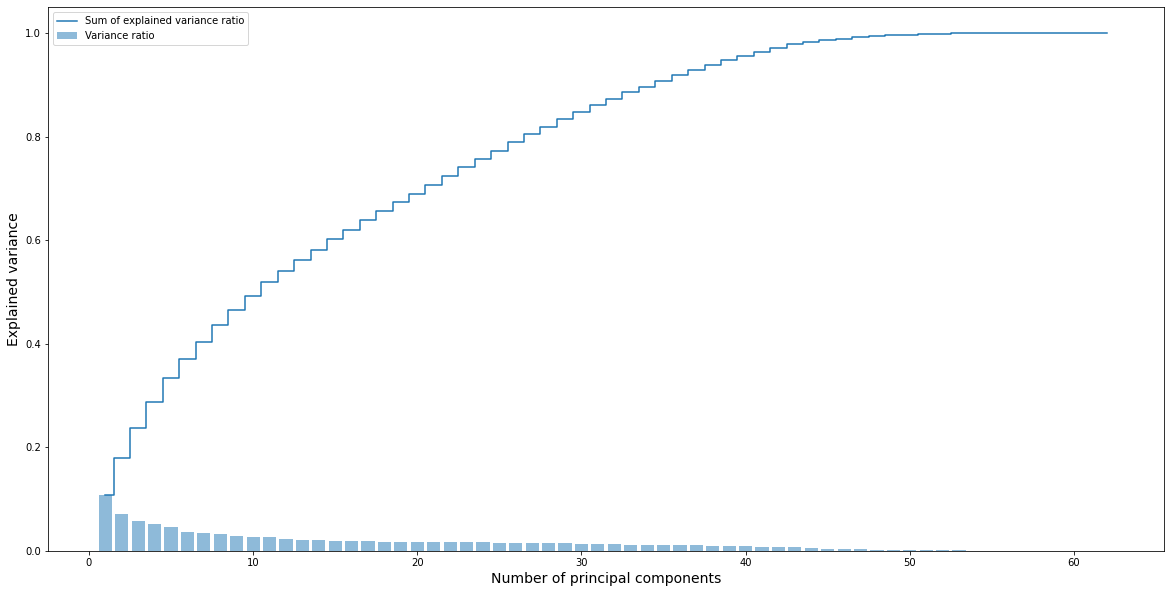

In [ ]:
plt.figure(figsize=(20,10))

plt.bar(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance ratio')

plt.step(np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]),
        y=np.cumsum(pca.explained_variance_ratio_),
        line_shape='hv',
        
    ))

fig.add_trace(
    go.Bar(
        x=np.linspace(1, X_trainFora_enc.shape[1], X_trainFora_enc.shape[1]),
        y=pca.explained_variance_ratio_
    ))
fig.update_layout(yaxis_title='Variância que pode ser "explicada"', xaxis_title='Número de componentes principais')

fig.show()

## **Balancing the data**

As mentioned earlier, we have unbalanced data, more labels with value 0 than in relation with value 1. Therefore, we will use methods to balance the data.

In both datasets an oversampling will be used, which creates new data for the label with less values (`RECDIST = 1`), after that we have both labels with the same number of examples.

**SP**

In [ ]:
# Number of values for each label in the training data
y_trainSP.value_counts()

0    300054
1     14671
Name: RECDIST, dtype: int64

In [ ]:
X_SP, y_SP = SMOTE(random_state=seed).fit_resample(X_trainSP_enc, y_trainSP)

In [ ]:
y_SP.shape

(600108,)

**Other states**

In [ ]:
# Number of values for each label in the training data
y_trainFora.value_counts()

0    45898
1      839
Name: RECDIST, dtype: int64

In [ ]:
X_fora, y_fora = SMOTE(random_state=seed).fit_resample(X_trainFora_enc, y_trainFora)

In [ ]:
y_fora.shape

(91796,)

## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing the data and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, class_weight={0: 0.00003, 1: 18})
rf_sp.fit(X_SP, y_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3e-05, 1: 18}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, class_weight={0: 0.00001, 1: 24}) 
rf_fora.fit(X_fora, y_fora)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1e-05, 1: 24}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=10_000,
                               random_state=seed)

xgboost_sp.fit(X_SP, y_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10000, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=300_000,
                                 random_state=seed)

xgboost_fora.fit(X_fora, y_fora)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=300000, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Models evaluation**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Preprocessing of testing data**


The preprocessing of the test data was also done using a function, `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
# SP
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)

In [ ]:
# Other states
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

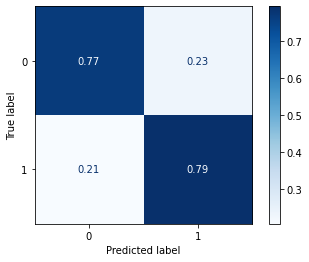

In [ ]:
plot_confusion_matrix(rf_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 78% of accuracy.

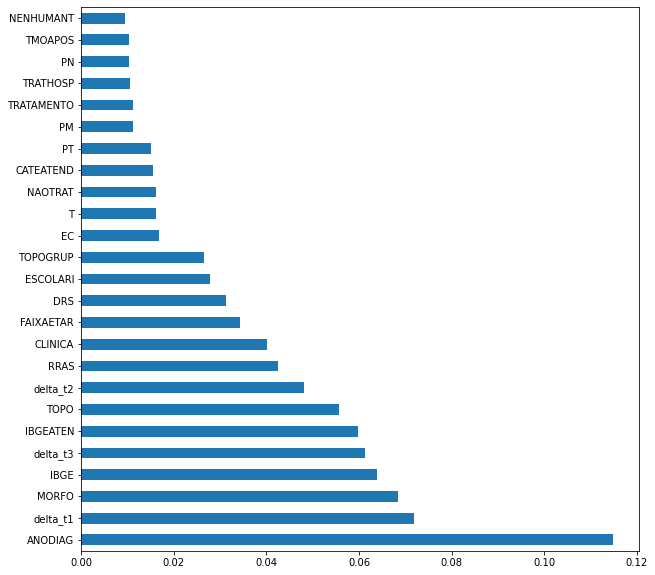

In [ ]:
plot_feat_importances(rf_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `delta_t1`, `MORFO` and `IBGE`. `delta_t1` is the difference, in days, between diagnosis and consultation.

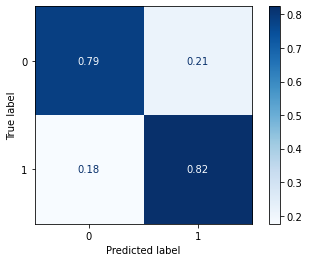

In [ ]:
plot_confusion_matrix(rf_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the data from another states also shows a good performance of the model, we have a more balanced main diagonal in the confusion matrix, with 80% of accuracy for both classes.


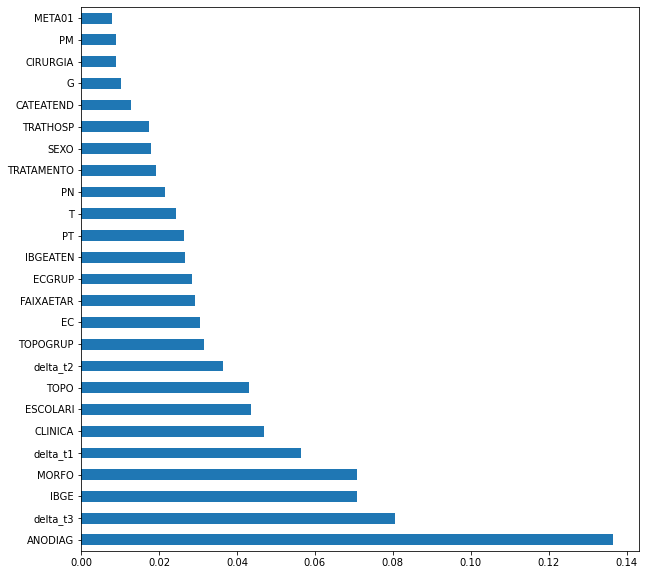

In [ ]:
plot_feat_importances(rf_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `delta_t3`, `IBGE` and `MORFO`. `delta_t3` is the differnce between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

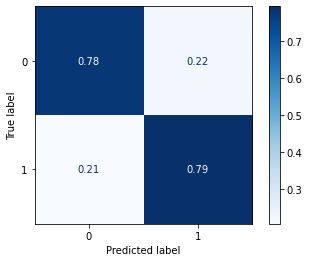

In [ ]:
plot_confusion_matrix(xgboost_sp, X_testSP_, y_testSP, cmap='Blues', normalize="true", values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, similar to the Random Forest model.

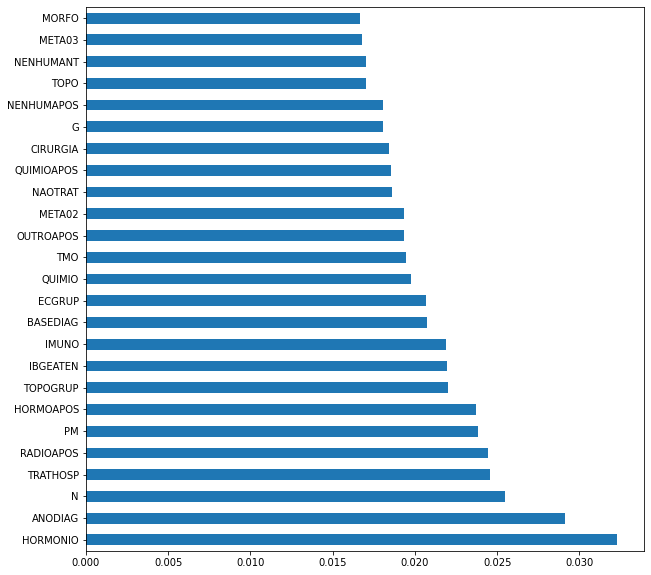

In [ ]:
plot_feat_importances(xgboost_sp, X_testSP)

> The four most important features in the model were `HORMONIO`, `ANODIAG`, `N` and `TRATHOSP`.

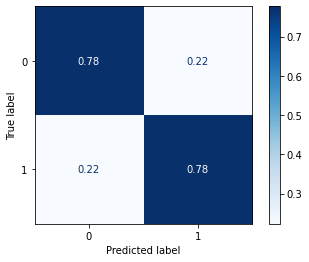

In [ ]:
plot_confusion_matrix(xgboost_fora, X_testFora_, y_testFora, cmap='Blues', normalize="true", values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 78% of accuracy. 

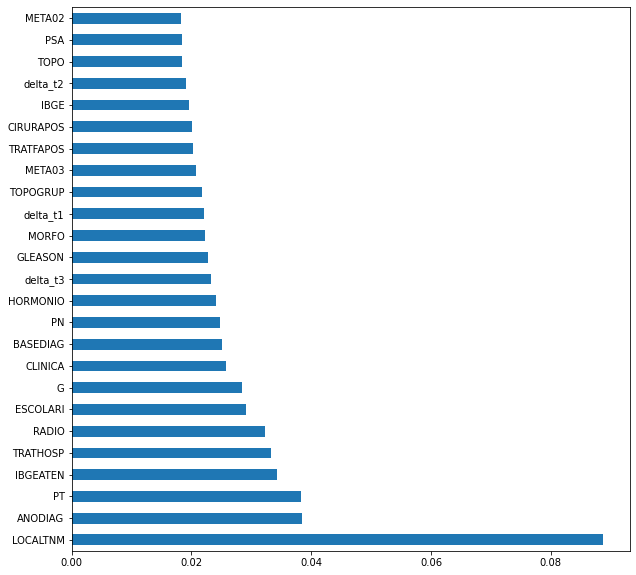

In [ ]:
plot_feat_importances(xgboost_fora, X_testFora)

> The four most important features in the model were `LOCALTNM`, `ANODIAG`, `PT` and `IBGEATEN`.

# **Regression - Delta t7**

Difference of days between last information and consultation

In this section, two machine learning models will be used to predict the `delta_t7` column, Random Forest Regressor and XGBoost Regressor.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

## **Training and testing split**

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the [classification - ob section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Classifiers.html#Reading-the-data).

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t8', 'delta_t9', 'ob', 'ano_ob',
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']

lb = 'delta_t7'

Again we will use the function created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP, list_drop, lb)

X_train = (604801, 70), X_test = (201601, 70)
y_train = (604801,), y_test = (201601,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 70), X_test = (15580, 70)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this we will use the function `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **Training and evaluation the machine learning models**

To preprocess the test data we will usa the function `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest Regressor**

The first model that will be tested is the Random Forest Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training models.

In [ ]:
# SP
rfr_sp = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_sp.fit(X_trainSP_enc, y_trainSP)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rfr_fora = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_fora.fit(X_trainFora_enc, y_trainFora)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

Below we have the metrics for the Random Forest Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, rfr_sp, y_testSP)
df.head()

Mean Absolute Error: 789.053
Mean Squared Error: 1206990.927
Root Mean Squared Error: 1098.631
Score: 0.411


,Real,Predict
400744,1601,1069.693860
369215,821,413.669676
387264,607,1397.548772
296234,450,506.058025
712621,950,1196.496278


> This first model for the São Paulo data did not perform well in predicting the difference between the last information and the medical consultation, as can be seen in the metrics used in the validation, the R² value was 0.41.

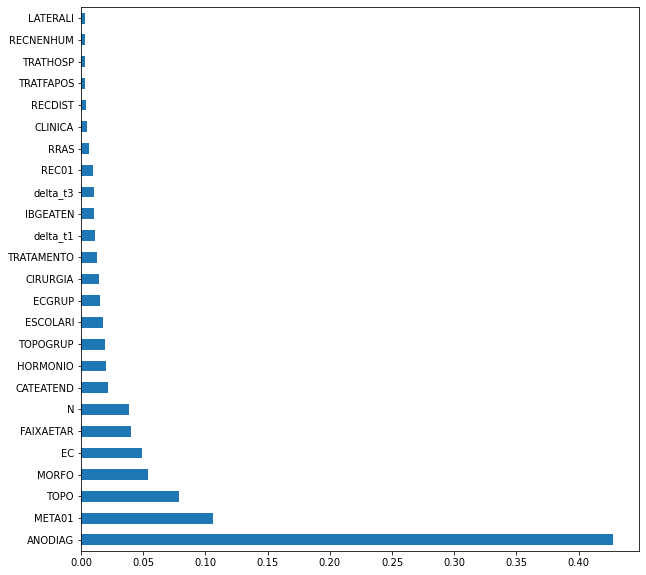

In [ ]:
plot_feat_importances(rfr_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `META01`, `TOPO` and `MORFO`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, rfr_fora, y_testFora)
df.head()

Mean Absolute Error: 666.512
Mean Squared Error: 936813.721
Root Mean Squared Error: 967.891
Score: 0.464


,Real,Predict
1077,725,599.482480
15361,937,1189.573078
3301,0,149.476432
32432,3338,2186.653566
39694,649,1563.660468


> As in the model for data from São Paulo, using data from other states, it was also not possible to obtain a good performance in predicting the difference between the last information and the medical consultation. The value of R² was 0.46, the errors were lower than in the previous model, but even so they do not represent a good regressor.

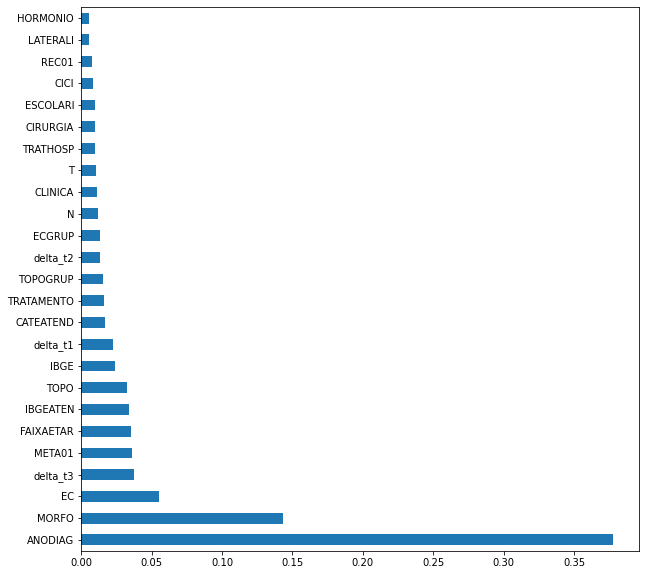

In [ ]:
plot_feat_importances(rfr_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `MORFO`, `EC` and `delta_t3`, the first one with a good difference to the others

### **XGBoost Regressor**

Here will be tested the XGBoost Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training.

In [ ]:
# SP
xgbr_sp = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_sp.fit(X_trainSP_enc, y_trainSP)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgbr_fora = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_fora.fit(X_trainFora_enc, y_trainFora)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Below we have the metrics for the XGBoost Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, xgbr_sp, y_testSP)
df.head()

Mean Absolute Error: 689.512
Mean Squared Error: 987826.482
Root Mean Squared Error: 993.895
Score: 0.518


,Real,Predict
400744,1601,1152.513794
369215,821,524.870361
387264,607,1982.705566
296234,450,311.787750
712621,950,1346.640381


> With the XGBoost regressor, a better model for SP data was obtained in relation to the Random Forest model presented in the previous section, but the score value was 0.52.

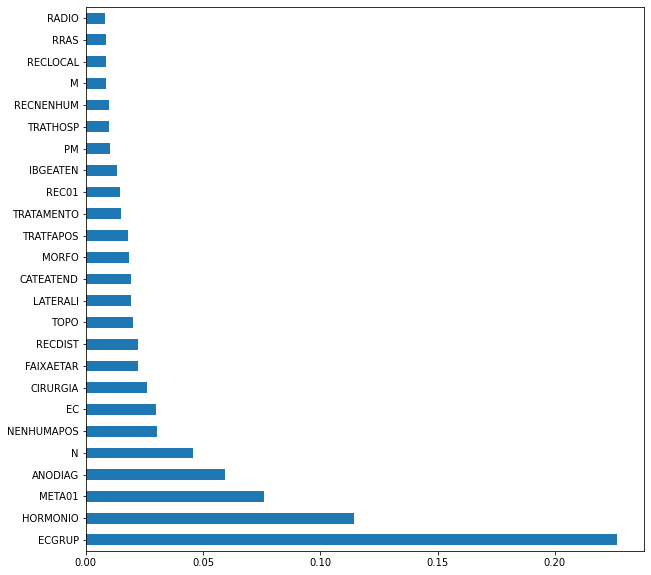

In [ ]:
plot_feat_importances(xgbr_sp, X_testSP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `META01` and `ANODIAG`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, xgbr_fora, y_testFora)
df.head()

Mean Absolute Error: 624.762
Mean Squared Error: 874175.481
Root Mean Squared Error: 934.974
Score: 0.500


,Real,Predict
1077,725,467.573486
15361,937,834.992310
3301,0,80.842232
32432,3338,2378.826904
39694,649,1536.617432


> As in the previous model, using the XGBoost regressor, a better model was obtained for data from other states in relation to the Random Forest model, with a score of 0.50, but still a model that does not present good prediction results.

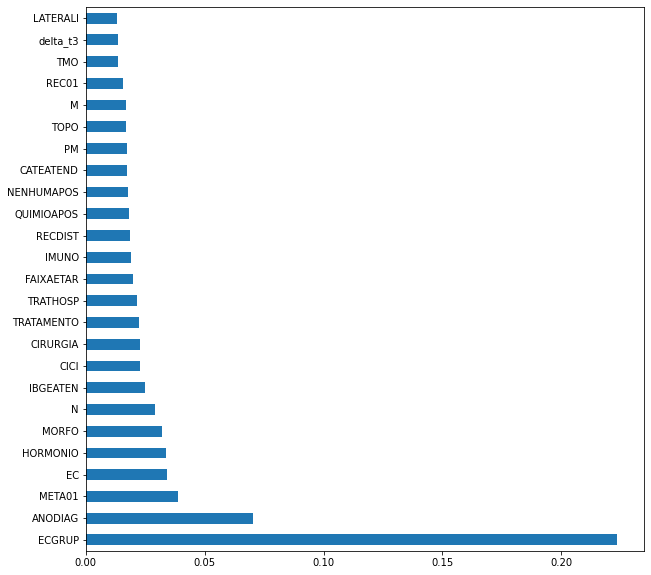

In [ ]:
plot_feat_importances(xgbr_fora, X_testFora)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `META01` and `EC`.

# **Regression - Delta t8**

Difference of days between last information and diagnosis

In this section, two machine learning models will be used to predict the `delta_t8` column, Random Forest Regressor and XGBoost Regressor.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


**SP**

In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

**Other states**

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

## **Training and testing split**

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the [classification - ob section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Classifiers.html#Reading-the-data).

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t9', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']
 
lb = 'delta_t8'

Again we will use the function created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP, list_drop, lb)

X_train = (604801, 70), X_test = (201601, 70)
y_train = (604801,), y_test = (201601,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 70), X_test = (15580, 70)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this we will use the function `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **Training and evaluation the machine learning models**

To preprocess the test data we will usa the function `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest Regressor**

The first model that will be tested is the Random Forest Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training models.

In [ ]:
# SP
rfr_sp = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_sp.fit(X_trainSP_enc, y_trainSP)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rfr_fora = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_fora.fit(X_trainFora_enc, y_trainFora)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

Below we have the metrics for the Random Forest Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, rfr_sp, y_testSP)
df.head()

Mean Absolute Error: 782.222
Mean Squared Error: 1195702.948
Root Mean Squared Error: 1093.482
Score: 0.415


,Real,Predict
400744,1601,1084.059347
369215,821,518.474025
387264,607,1377.023778
296234,433,458.217164
712621,932,1187.299115


> Using the difference in days between last information and diagnosis as label, a good predictor for SP data was also not obtained, its score was 0.41.

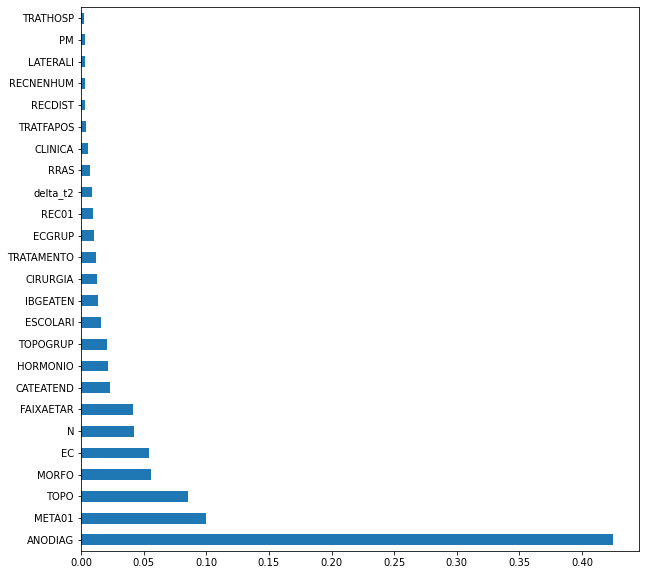

In [ ]:
plot_feat_importances(rfr_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `META01`, `TOPO` and `MORFO`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, rfr_fora, y_testFora)
df.head()

Mean Absolute Error: 663.871
Mean Squared Error: 933287.954
Root Mean Squared Error: 966.068
Score: 0.464


,Real,Predict
1077,724,560.414422
15361,936,1261.124292
3301,0,186.681097
32432,3365,2201.181639
39694,663,1631.297124


> As in the model for data from São Paulo, using data from other states, it was also not possible to obtain a good performance predicting delta_t8. The value of R² was 0.46, the errors were lower than in the previous model, but even so they do not represent a good regressor.

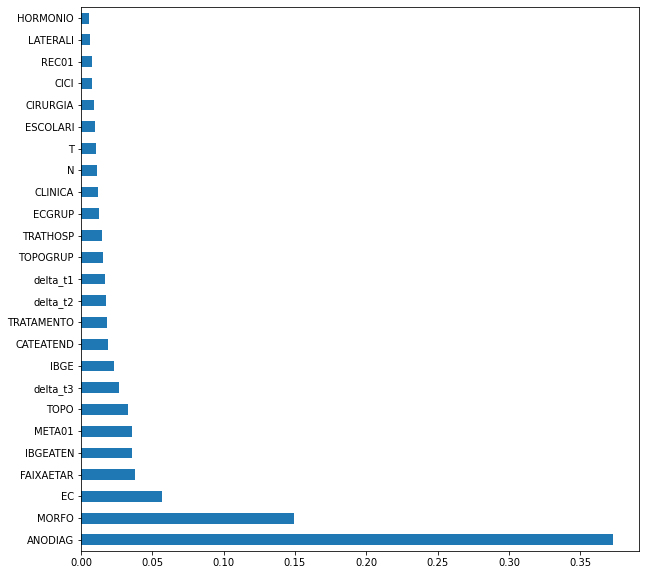

In [ ]:
plot_feat_importances(rfr_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `MORFO`, `EC` and `FAIXAETAR`.

### **XGBoost Regressor**

Here will be tested the XGBoost Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training.

In [ ]:
# SP
xgbr_sp = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_sp.fit(X_trainSP_enc, y_trainSP)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgbr_fora = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_fora.fit(X_trainFora_enc, y_trainFora)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Below we have the metrics for the XGBoost Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, xgbr_sp, y_testSP)
df.head()

Mean Absolute Error: 686.846
Mean Squared Error: 985000.332
Root Mean Squared Error: 992.472
Score: 0.518


,Real,Predict
400744,1601,1172.890869
369215,821,598.177185
387264,607,1902.172974
296234,433,345.109161
712621,932,1261.731323


> With the XGBoost regressor, a better model for SP data was obtained in relation to the Random Forest model for the same data, but the score value was 0.52, representing a not very good predictor.

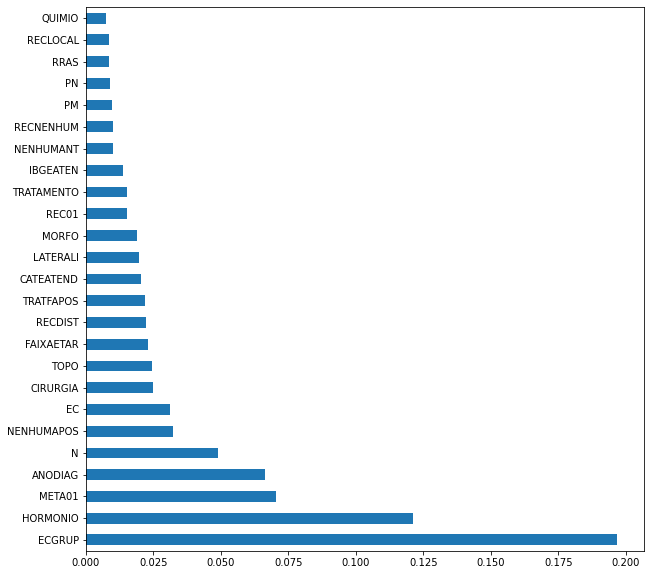

In [ ]:
plot_feat_importances(xgbr_sp, X_testSP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `META01` and `ANODIAG`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, xgbr_fora, y_testFora)
df.head()

Mean Absolute Error: 622.798
Mean Squared Error: 870268.682
Root Mean Squared Error: 932.882
Score: 0.500


,Real,Predict
1077,724,445.601044
15361,936,969.741333
3301,0,55.943726
32432,3365,2436.193848
39694,663,1578.609497


> As in the previous model, using the XGBoost regressor, a better model was obtained for data from other states in relation to the Random Forest model, with a score of 0.50, but still a model that does not present good prediction results.

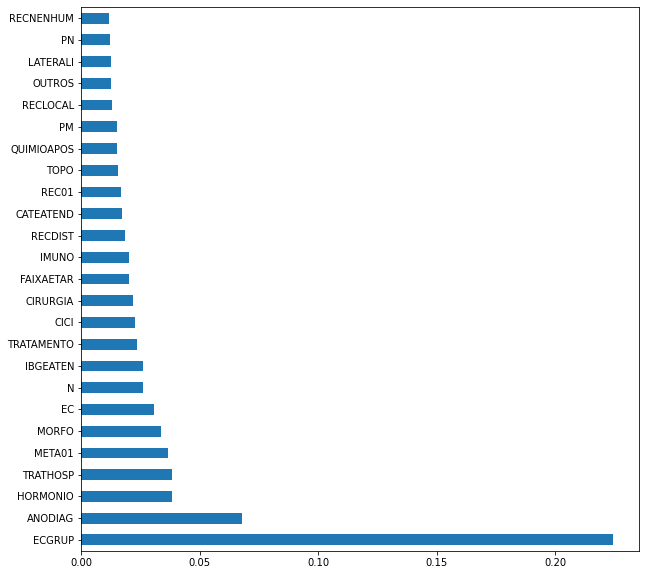

In [ ]:
plot_feat_importances(xgbr_fora, X_testFora)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `HORMONIO` and `TRATHOSP`.

# **Regression - Delta t9**

Difference of days between last information and treatment

In this section, two machine learning models will be used to predict the `delta_t9` column, Random Forest Regressor and XGBoost Regressor.

## **Reading the data**

Reading the data from SP and other states

We can see that we still have some missing values in both datasets, but the column `DTRECIDIVA` will be dropped, as well the `IDADE` column, because the column `FAIXAETAR` will be used, both have information about the age of the patients. 

The columns `delta_t4`, `delta_t5` and `delta_t6`, can be used as a label in a future analysis, so they will not be as features of the created models.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(806402, 94)
(62317, 94)


**SP**

In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    717377
delta_t6      717377
delta_t5      717377
delta_t4      717377
IDADE              1
TRATAMENTO         0
dtype: int64

**Other states**

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

DTRECIDIVA    57799
delta_t6      57799
delta_t5      57799
delta_t4      57799
NAOTRAT           0
LOCALTNM          0
dtype: int64

## **Training and testing split**

To define the columns that will be used as features and the label, the process will be similar to the one used previously. 

For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT, DTDIAG, DTTRAT, DTRECIDIVA, DTULTINFO`, because we already have the difference in days in other columns. 

It was chosen to keep the column `FAIXAETAR`, so we will not use the `IDADE`. Regarding `PERDASEG`, it has already been discussed in the [classification - ob section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Classifiers.html#Reading-the-data).

The columns `CONSDIAG, TRATCONS, DIAGTRAT` contain the same information as the `delta_t1, delta_t2, delta_t3`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'IDADE', 'PERDASEG', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4',
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'ob', 'ano_ob', 
             'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec', 'vivo_sem_rec', 'ULTINFO']
 
lb = 'delta_t9'

Again we will use the function created to perform the division of the data in training and testing, `get_train_test`. It is only necessary to pass the dataframe that will be used, a list with the columns that will not be used and a string with the name of the column that will be the label.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP, X_testSP, y_trainSP, y_testSP = get_train_test(df_SP, list_drop, lb)

X_train = (604801, 70), X_test = (201601, 70)
y_train = (604801,), y_test = (201601,)


**Other states**

In [ ]:
X_trainFora, X_testFora, y_trainFora, y_testFora = get_train_test(df_fora, list_drop, lb)

X_train = (46737, 70), X_test = (15580, 70)
y_train = (46737,), y_test = (15580,)


## **Encoder and normalization**

After dividing the data into training and testing it is necessary to preprocess the training data, for this we will use the function `train_preprocessing`, it returns the data encoded (columns that are strings) and normalized. Training data is required for the function.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_trainSP_enc, enc_SP, norm_SP = train_preprocessing(X_trainSP, normalizer='StandardScaler')

**Other states**

In [ ]:
X_trainFora_enc, enc_fora, norm_fora = train_preprocessing(X_trainFora, normalizer='StandardScaler')

## **Training and evaluation the machine learning models**

To preprocess the test data we will usa the function `test_preprocessing`, passing the test data and the encoder and normalizer, trained to the training data, as parameters.

> See the complete function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models)

In [ ]:
X_testSP_ = test_preprocessing(X_testSP, enc_SP, norm_SP)
X_testFora_ = test_preprocessing(X_testFora, enc_fora, norm_fora)

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest Regressor**

The first model that will be tested is the Random Forest Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training models.

In [ ]:
# SP
rfr_sp = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_sp.fit(X_trainSP_enc, y_trainSP)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rfr_fora = RandomForestRegressor(random_state=seed, max_depth=10)
rfr_fora.fit(X_trainFora_enc, y_trainFora)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

Below we have the metrics for the Random Forest Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, rfr_sp, y_testSP)
df.head()

Mean Absolute Error: 786.738
Mean Squared Error: 1202646.875
Root Mean Squared Error: 1096.653
Score: 0.407


,Real,Predict
400744,1601,972.655416
369215,821,498.512299
387264,607,1425.012203
296234,432,372.219595
712621,932,1047.650587


> Using the difference in days between last information and treatment as label, a predictor with R² equal to 0.41 was obtained, representing a bad model to predict the value of delta_t9.

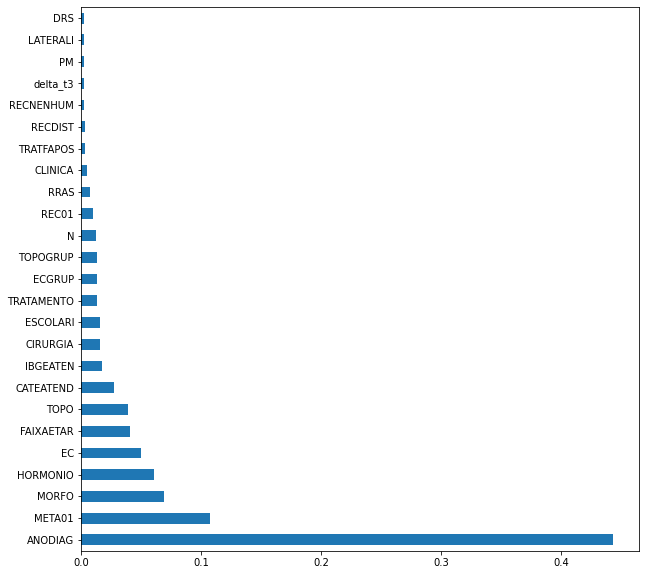

In [ ]:
plot_feat_importances(rfr_sp, X_testSP)

> The four most important features in the model were `ANODIAG`, `META01`, `MORFO` and `HORMONIO`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, rfr_fora, y_testFora)
df.head()

Mean Absolute Error: 661.286
Mean Squared Error: 930053.631
Root Mean Squared Error: 964.393
Score: 0.463


,Real,Predict
1077,722,597.598551
15361,900,1160.502572
3301,0,149.705062
32432,3242,2078.646844
39694,617,1532.888781


> As in the model for data from São Paulo, using data from other states, it was also not possible to obtain a good performance predicting delta_t9. The value of R² was 0.46, similar to the other Random Forest models for other states data.

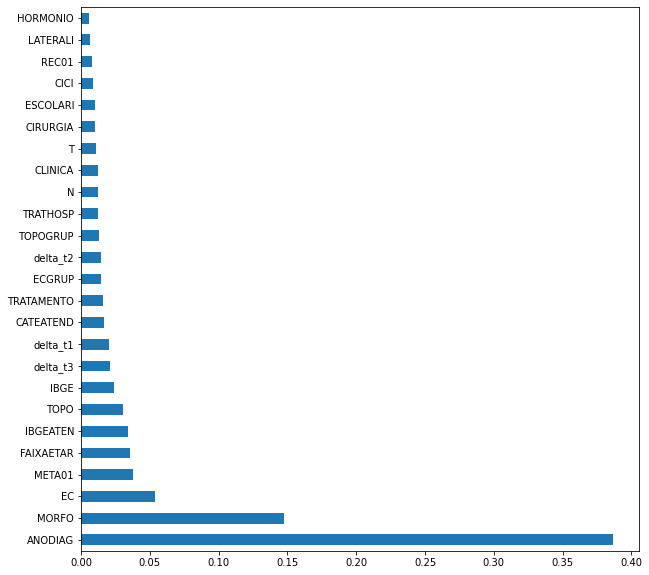

In [ ]:
plot_feat_importances(rfr_fora, X_testFora)

> The four most important features in the model were `ANODIAG`, `MORFO`, `EC` and `META01`.

### **XGBoost Regressor**

Here will be tested the XGBoost Regressor, for this test the `random_state` and `max_depth` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `max_depth` to increase the depth of the tree in the training.

In [ ]:
# SP
xgbr_sp = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_sp.fit(X_trainSP_enc, y_trainSP)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgbr_fora = xgb.XGBRegressor(max_depth=10, random_state=seed)
xgbr_fora.fit(X_trainFora_enc, y_trainFora)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Below we have the metrics for the XGBoost Regressor models, followed by the graph with the most important features for each model.

To calculate the metrics it was created a function, `validate_regression`, that returns some metrics of the model: MAE, MSE, RMSE and R².

> Go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

**SP**

In [ ]:
df = validate_regression(X_testSP_, xgbr_sp, y_testSP)
df.head()

Mean Absolute Error: 685.819
Mean Squared Error: 983335.065
Root Mean Squared Error: 991.633
Score: 0.515


,Real,Predict
400744,1601,1095.191040
369215,821,519.250488
387264,607,2122.545654
296234,432,367.914001
712621,932,1267.061646


> With the XGBoost regressor, a better model for SP data was obtained in relation to the Random Forest model for the same data, as seen to the other labels, but the score value was 0.51, representing a not very good predictor.

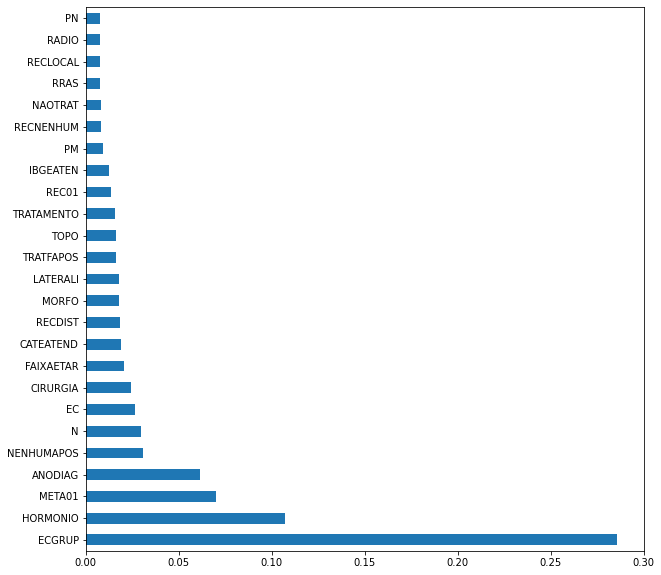

In [ ]:
plot_feat_importances(xgbr_sp, X_testSP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `META01` and `ANODIAG`.

**Other states**

In [ ]:
df = validate_regression(X_testFora_, xgbr_fora, y_testFora)
df.head()

Mean Absolute Error: 622.998
Mean Squared Error: 871323.837
Root Mean Squared Error: 933.447
Score: 0.497


,Real,Predict
1077,722,292.516296
15361,900,1164.710449
3301,0,60.525486
32432,3242,2262.347168
39694,617,1506.699829


> As in the previous model, using the XGBoost regressor, a better model was obtained for data from other states in relation to the Random Forest model, with a score of 0.50, but still a model that does not present good prediction results.

> None of the tested regressors showed good results, so to obtain good predictions for these cases, other methods should be sought.

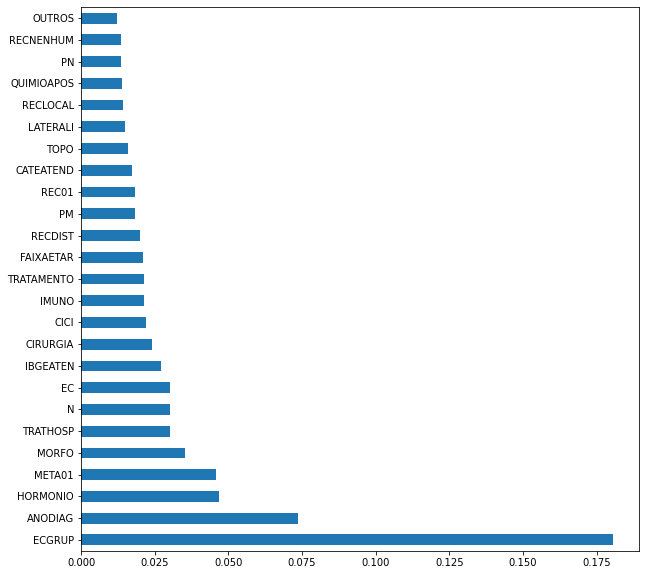

In [ ]:
plot_feat_importances(xgbr_fora, X_testFora)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `HORMONIO` and `META01`.

# **References**

[Pandas](https://pandas.pydata.org/docs/reference/index.html)

[Seaborn](https://seaborn.pydata.org/api.html)

[Matplotlib](https://matplotlib.org/stable/gallery/index.html)

[Plotly](https://plotly.com/python/)

[sklearn preprocessing](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

[sklearn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

[imblearn](https://imbalanced-learn.org/stable/references/index.html)

[Random Forest Classifier and Regressor](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

[Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix)

[Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

[XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

[XGBoost for Regression Machine Learning Mastery](https://machinelearningmastery.com/xgboost-for-regression/)

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/